In [ ]:
"""
DelegateGameFromCapabilities - A version of the delegate game that uses completed results files

Features:
- Takes output from complete_model_results.py (completed_results_XX directory)
- Constructs a simulated Phase 1 history based on configuration
- Selects question sets for phase 1 and phase 2 based on the desired accuracy ratios
- Runs only Phase 2 (delegate game) with multiple choice questions
- Maintains compatibility with the original delegate game's configuration options
"""

import random
import time
import copy
import json
import os
import re
from base_game_class import BaseGameClass
import scipy.stats
import glob
from load_and_format_datasets import load_and_format_dataset

PHASE1_TYPES = None#["Number", "Other", "Place"]
PHASE2_TYPES = None#["Date", "Person"]

class DelegateGameFromCapabilities(BaseGameClass):
    """
    Manages the psychological experiment game flow, using completed results files.
    """
    def __init__(self, subject_id, subject_name, is_human_player=False,
                 completed_results_file=None, dataset="GPQA",
                 n_trials_phase1=100, n_trials_phase2=100,
                 teammate_accuracy_phase1=0.7, teammate_accuracy_phase2=0.7,
                 feedback_config=None, override_subject_accuracy=None, override_subject_accuracy_game=None, randomize_phase1_answers=False,
                 use_phase1_summary=True, use_phase1_history=True,
                 redact_phase1_answers=False, initial_setup_explanation="",
                 seed=None, temperature=0.0, resume_from=None):
        """
        Initializes the game instance using completed results data.

        Args:
            subject_id (str): Identifier for the current subject/session.
            subject_name (str): Name of the subject (model name for LLMs).
            is_human_player (bool): Whether the subject is a human (True) or LLM (False).
            completed_results_file (str): Path to the completed results file.
            dataset (str): Dataset name (GPQA, SimpleQA, MMLU, TruthfulQA).
            n_trials_phase1 (int): Number of trials for Phase 1 simulation.
            n_trials_phase2 (int): Number of trials for Phase 2.
            teammate_accuracy_phase1 (float): The teammate's target accuracy in Phase 1 (0.0 to 1.0).
            teammate_accuracy_phase2 (float): The teammate's target accuracy in Phase 2 (0.0 to 1.0).
            feedback_config (dict): Configuration for feedback options.
            override_subject_accuracy (float): If not None, overrides subject accuracy in phase 1.
            randomize_phase1_answers (bool): If True, randomizes the subject's answers/correctness in Phase 1.
            use_phase1_summary (bool): Whether to include a summary of phase 1 in the history.
            use_phase1_history (bool): Whether to include the full phase 1 history.
            redact_phase1_answers (bool): If True, replaces subject's phase 1 answers with "[redacted]".
            initial_setup_explanation (str): Explanation text to show at the beginning.
            seed (int, optional): Seed for random number generation. Defaults to None.
        """
        super().__init__(subject_id, subject_name, is_human_player, "delegate_game_logs")

        # Seed random number generator if a seed is provided
        self.seed = seed
        if self.seed is not None:
            self._log(f"Using random seed: {self.seed}")
            random.seed(self.seed)

        self.temperature = temperature

        # Store parameters
        self.completed_results_file = completed_results_file
        self.dataset = dataset
        self.n_trials_phase1 = n_trials_phase1
        self.n_trials_phase2 = n_trials_phase2
        self.teammate_accuracy_phase1 = teammate_accuracy_phase1
        self.teammate_accuracy_phase2 = teammate_accuracy_phase2
        self.override_subject_accuracy = override_subject_accuracy
        self.randomize_phase1_answers = randomize_phase1_answers
        self.use_phase1_summary = use_phase1_summary
        self.use_phase1_history = use_phase1_history
        self.redact_phase1_answers = redact_phase1_answers
        self.initial_setup_explanation = initial_setup_explanation
        self.override_subject_accuracy_game = override_subject_accuracy_game

        # Default feedback configuration
        self.feedback_config = {
            'phase1_subject_feedback': True,      # Show subject's answer feedback in phase 1
            'phase1_teammate_feedback': True,     # Show teammate's answer feedback in phase 1
            'phase2_subject_feedback': False,     # Show subject's answer feedback in phase 2
            'phase2_teammate_feedback': False,    # Show teammate's answer feedback in phase 2
            'show_answer_with_correctness': True, # Include answer in feedback
        }
        
        # Override with provided config
        if feedback_config:
            self.feedback_config.update(feedback_config)

        # Initialize state
        self.results = []
        self.phase1_questions = []
        self.phase2_questions = []
        self.subject_accuracy_phase1 = None
        self.true_subject_accuracy = None  # The actual accuracy from completed results
        self.phase2_score = None
        self.phase2_accuracy = None
        self.stored_message_history = []
        self.phase1_simulated_history = []
        self.is_short_answer = False
        self.teammate_phase1_answers = {}
        self.all_correct_questions = []
        self.all_incorrect_questions = []

        # Load completed results data
        self._load_completed_results()

        if resume_from:
            # If resuming, load the existing results
            self._log(f"Resuming from: {resume_from}")
            try:
                with open(resume_from, 'r', encoding='utf-8') as f:
                    res = json.load(f)
                self.completed_results = res["results"]
            except Exception as e:
                self._log(f"Error resuming from {resume_from}: {e}")
                raise ValueError(f"Could not resume from {resume_from}: {e}")
        else:
            self.completed_results = None

    def _load_completed_results(self):
        """Load completed results data from the specified file."""
        if not self.completed_results_file or not os.path.exists(self.completed_results_file):
            raise ValueError(f"Completed results file not found: {self.completed_results_file}")

        try:
            self._log(f"Loading completed results from: {self.completed_results_file}")
            with open(self.completed_results_file, 'r', encoding='utf-8') as f:
                self.completed_data = json.load(f)

            # Verify this is a completed results file with the expected structure
            if "results" not in self.completed_data or not isinstance(self.completed_data["results"], dict):
                raise ValueError("Invalid completed results file: missing or invalid 'results' field")

            if "accuracy" not in self.completed_data:
                raise ValueError("Invalid completed results file: missing 'accuracy' field")

            # Store the true subject accuracy from the file
            self.true_subject_accuracy = self.completed_data["accuracy"]
            self._log(f"True subject accuracy from completed results: {self.true_subject_accuracy:.2%}")

            # Set subject accuracy for Phase 1 (use override if specified)
            if self.override_subject_accuracy is not None:
                self.subject_accuracy_phase1 = self.override_subject_accuracy
                self._log(f"Using override subject accuracy for Phase 1: {self.subject_accuracy_phase1:.2%}")
            else:
                self.subject_accuracy_phase1 = self.true_subject_accuracy
                self._log(f"Using true subject accuracy for Phase 1: {self.subject_accuracy_phase1:.2%}")

            # Determine if this is multiple choice or short answer
            self._determine_question_type()

            # Separate correct and incorrect questions
            self._separate_questions_by_correctness()

            # Select and prepare questions for phase 1 and phase 2
            self._prepare_phase1_questions()
            self._prepare_phase2_questions()

            # Pre-determine teammate's answers
            self._predetermine_teammate_answers(phase=1)
            self._predetermine_teammate_answers(phase=2)

            # Log loaded data summary
            self._log(f"Loaded completed results with {len(self.completed_data['results'])} questions")
            self._log(f"Selected {len(self.phase1_questions)} questions for Phase 1")
            self._log(f"Selected {len(self.phase2_questions)} questions for Phase 2")
            self._log(f"Subject phase 1 accuracy: {self.subject_accuracy_phase1:.2%}")
            self._log(f"Teammate phase 1 accuracy: {self.teammate_accuracy_phase1:.2%}")
            self._log(f"Question type: {'Short Answer' if self.is_short_answer else 'Multiple Choice'}")

        except Exception as e:
            raise ValueError(f"Error loading completed results data: {e}")

    def _determine_question_type(self):
        """Determine if the dataset is multiple choice or short answer."""
        # Get the first result
        first_result = next(iter(self.completed_data["results"].values()))
        
        # If it has options, it's multiple choice
        self.is_short_answer = not ("options" in first_result and isinstance(first_result["options"], dict) and len(first_result["options"]) > 0)
        
        return self.is_short_answer
        
    def _separate_questions_by_correctness(self):
        """Separate questions into correct and incorrect lists,
           adapting to different JSON structures based on whether it's short answer."""
        self.all_correct_questions = []
        self.all_incorrect_questions = []
        
        if not self.completed_data or "results" not in self.completed_data:
            self._log("Error: Completed data is missing or has no 'results' field in _separate_questions_by_correctness.")
            return

        if self.dataset == "GPQA":
            gpqa_questions_with_features = load_and_format_dataset("GPQA") 

        for q_id, result_item in self.completed_data["results"].items():

            if self.dataset == "GPQA":
                feature_lookup = {
                    item['id']: {
                        'difficulty': item['difficulty_score'],
                        'overlap_ratio': item.get('overlap_ratio', 0),
                        'domain': item['high_level_domain'],
                        'question_text': item['question'] 
                    } 
                    for item in gpqa_questions_with_features if item.get('id') 
                }
                domain = feature_lookup.get(q_id, {}).get("domain")
                if "_nobio" in self.subject_id and domain and domain.lower() == "biology": continue
                difficulty = feature_lookup.get(q_id, {}).get("difficulty", 0)
                if "_noeasy" in self.subject_id and difficulty and difficulty < 2: continue

            question_data_for_list = {"id": q_id}

            current_is_correct = result_item.get("is_correct")

            # Skip questions where correctness cannot be determined (e.g., null, "NOT ATTEMPTED")
            if current_is_correct is not True and current_is_correct is not False:
                self._log(f"Question {q_id} has 'is_correct' as '{current_is_correct}'. Skipping for correct/incorrect separation.")
                continue

            question_data_for_list["is_correct"] = current_is_correct
            question_data_for_list["subject_answer"] = result_item.get("subject_answer", "N/A")
            # Store probabilities if available, might be useful for other analyses or extensions
            question_data_for_list["probs"] = result_item.get("probs")

            if False:###self.is_short_answer: #both are using the same format now
                # Handle short answer format (e.g., from capabilities_test_logs)
                # 'question' is an object containing details
                question_details_obj = result_item.get("question", {})
                question_data_for_list["question"] = question_details_obj.get("question", "N/A") # Actual question text
                question_data_for_list["options"] = {} # No options for short answer
                # For short answer, 'correct_answer' field stores the actual answer string
                question_data_for_list["correct_answer"] = question_details_obj.get("correct_answer", "N/A")
            else:
                # Handle MCQ format (e.g., from completed_results_gpqa)
                # 'question' is expected to be a string (the question text itself)
                question_data_for_list["question"] = result_item.get("question", "N/A")
                question_data_for_list["options"] = result_item.get("options", {})
                # For MCQ, 'correct_answer' field stores the option label (e.g., 'A', 'B')
                question_data_for_list["correct_answer"] = result_item.get("correct_answer_label", "N/A")
            
            # Add to the appropriate list
            if question_data_for_list["is_correct"]:
                self.all_correct_questions.append(question_data_for_list)
            else: # is_correct is False
                self.all_incorrect_questions.append(question_data_for_list)
        
        self._log(f"Separated questions: {len(self.all_correct_questions)} correct, {len(self.all_incorrect_questions)} incorrect")
        
        # Shuffle both lists to ensure random selection
        if self.all_correct_questions: # Avoid error if list is empty
            random.shuffle(self.all_correct_questions)
        if self.all_incorrect_questions: # Avoid error if list is empty
            random.shuffle(self.all_incorrect_questions)

    def _prepare_phase1_questions(self):
        """
        Select questions for Phase 1 based on desired accuracy ratio.
        
        This method selects n_trials_phase1 questions, with a proportion of correct questions
        matching the subject_accuracy_phase1 (or override_subject_accuracy if specified).
        """
        # Calculate how many correct questions we need to match the desired accuracy
        num_correct_needed = int(round(self.subject_accuracy_phase1 * self.n_trials_phase1))
        num_incorrect_needed = self.n_trials_phase1 - num_correct_needed
        
        self._log(f"Selecting {num_correct_needed} correct and {num_incorrect_needed} incorrect questions for Phase 1")
        
        # Check if we have enough questions of each type
        if num_correct_needed > len(self.all_correct_questions):
            self._log(f"Warning: Not enough correct questions available. Using all {len(self.all_correct_questions)} correct questions.")
            num_correct_needed = len(self.all_correct_questions)
            num_incorrect_needed = min(self.n_trials_phase1 - num_correct_needed, len(self.all_incorrect_questions))
            
        if num_incorrect_needed > len(self.all_incorrect_questions):
            self._log(f"Warning: Not enough incorrect questions available. Using all {len(self.all_incorrect_questions)} incorrect questions.")
            num_incorrect_needed = len(self.all_incorrect_questions)
            num_correct_needed = min(self.n_trials_phase1 - num_incorrect_needed, len(self.all_correct_questions))
        
        #Filter to phase1 types if needed
        if PHASE1_TYPES and self.dataset == "SimpleQA":
            print("Loading main SimpleQA dataset for features...")
            sqa_all_questions = load_and_format_dataset("SimpleQA") # This should have id, Question, high_level_domain, difficulty_score

            sqa_feature_lookup = {
                item['id']: {
                    'answer_type': item.get('answer_type', 0),
                    'topic': item['topic'],
                    'q_text': item['question']
                } for item in sqa_all_questions
            }
            phase1_correct_questions = [q for q in self.all_correct_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in PHASE1_TYPES][:num_correct_needed]
            phase1_incorrect_questions = [q for q in self.all_incorrect_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in PHASE1_TYPES][:num_incorrect_needed]
        else:
            # Select the questions
            phase1_correct_questions = self.all_correct_questions[:num_correct_needed]
            phase1_incorrect_questions = self.all_incorrect_questions[:num_incorrect_needed]
        
        # Combine and shuffle
        self.phase1_questions = phase1_correct_questions + phase1_incorrect_questions
        random.shuffle(self.phase1_questions)
        
        # Create ID lookup for quick access
        self.phase1_question_ids = set(q["id"] for q in self.phase1_questions)
        
        # Calculate actual subject accuracy for Phase 1
        actual_num_correct = len(phase1_correct_questions)
        self.subject_accuracy_phase1 = actual_num_correct / len(self.phase1_questions) if self.phase1_questions else 0
        
        self._log(f"Selected {len(self.phase1_questions)} questions for Phase 1 with subject accuracy {self.subject_accuracy_phase1:.2%}")

    def _prepare_phase2_questions(self):
        """
        Select questions for Phase 2 based on the true accuracy from the completed results,
        targeting the actual number of trials for the run (self.n_trials_phase2).
        
        Phase 2 questions are selected to:
        1. Be distinct from Phase 1 questions.
        2. Have a proportion of correct questions matching self.true_subject_accuracy
           for the self.n_trials_phase2 questions, as much as possible.
        """
        #Filter to phase1 types if needed
        if PHASE2_TYPES and self.dataset == "SimpleQA":
            print("Loading main SimpleQA dataset for features...")
            sqa_all_questions = load_and_format_dataset("SimpleQA") # This should have id, Question, high_level_domain, difficulty_score

            sqa_feature_lookup = {
                item['id']: {
                    'answer_type': item.get('answer_type', 0),
                    'topic': item['topic'],
                    'q_text': item['question']
                } for item in sqa_all_questions
            }
            remaining_correct_ordered = [q for q in self.all_correct_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in PHASE2_TYPES and q["id"] not in self.phase1_question_ids]
            remaining_incorrect_ordered = [q for q in self.all_incorrect_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in PHASE2_TYPES and q["id"] not in self.phase1_question_ids]
        else:
            # Filter out questions already used in Phase 1
            remaining_correct_ordered = [q for q in self.all_correct_questions if q["id"] not in self.phase1_question_ids]
            remaining_incorrect_ordered = [q for q in self.all_incorrect_questions if q["id"] not in self.phase1_question_ids]

        total_remaining_questions = len(remaining_correct_ordered) + len(remaining_incorrect_ordered)
        
        num_questions_for_this_run = self.n_trials_phase2

        if num_questions_for_this_run == 0:
            self._log("Phase 2 has 0 trials. No questions will be selected.")
            self.phase2_questions = []
            return

        if num_questions_for_this_run > total_remaining_questions:
            self._log(f"Warning: Requested {num_questions_for_this_run} questions for Phase 2, but only {total_remaining_questions} are available after Phase 1. Using all {total_remaining_questions} available questions.")
            num_questions_for_this_run = total_remaining_questions
        
        self.n_trials_phase2 = num_questions_for_this_run # Update instance variable to actual number

        if self.n_trials_phase2 == 0: # Can happen if total_remaining_questions was 0
            self._log("No questions available or selected for Phase 2.")
            self.phase2_questions = []
            return

        # Calculate target number of correct and incorrect questions for the run
        if self.override_subject_accuracy_game is not None:
            self.true_subject_accuracy = self.override_subject_accuracy_game
            self._log(f"Using override subject accuracy for Phase 2: {self.true_subject_accuracy:.2%}")
            if int(round((1-self.true_subject_accuracy) * total_remaining_questions)) > len(remaining_incorrect_ordered):
                needed_incorrect_for_run = len(remaining_incorrect_ordered)
                needed_correct_for_run = self.true_subject_accuracy/(1-self.true_subject_accuracy) * needed_incorrect_for_run
            elif int(round(self.true_subject_accuracy * total_remaining_questions)) > len(remaining_correct_ordered):
                needed_correct_for_run = len(remaining_correct_ordered)
                needed_incorrect_for_run = (1-self.true_subject_accuracy)/self.true_subject_accuracy * needed_correct_for_run
            else:
                # Use the original calculation
                needed_correct_for_run = int(round(self.true_subject_accuracy * total_remaining_questions))
                needed_incorrect_for_run = int(round((1-self.true_subject_accuracy) * total_remaining_questions))
            self.n_trials_phase2 = needed_correct_for_run + needed_incorrect_for_run

        target_correct_for_run = int(round(self.true_subject_accuracy * self.n_trials_phase2))
        target_incorrect_for_run = int(round((1-self.true_subject_accuracy) * self.n_trials_phase2))

        selected_correct_qs = []
        selected_incorrect_qs = []

        # Try to meet the targets
        actual_correct_to_select = min(target_correct_for_run, len(remaining_correct_ordered))
        selected_correct_qs = remaining_correct_ordered[:actual_correct_to_select]

        actual_incorrect_to_select = min(target_incorrect_for_run, len(remaining_incorrect_ordered))
        selected_incorrect_qs = remaining_incorrect_ordered[:actual_incorrect_to_select]
        
        # If we haven't selected enough questions, fill up to self.n_trials_phase2
        current_total_selected = len(selected_correct_qs) + len(selected_incorrect_qs)
        still_needed = self.n_trials_phase2 - current_total_selected

        if still_needed > 0:
            # Try to fill with more correct questions if available and we took fewer than available
            can_add_more_correct = len(remaining_correct_ordered) - len(selected_correct_qs)
            add_c = min(still_needed, can_add_more_correct)
            if add_c > 0:
                selected_correct_qs.extend(remaining_correct_ordered[len(selected_correct_qs) : len(selected_correct_qs) + add_c])
                still_needed -= add_c
        
        if still_needed > 0:
            # Try to fill with more incorrect questions if available and we took fewer than available
            can_add_more_incorrect = len(remaining_incorrect_ordered) - len(selected_incorrect_qs)
            add_i = min(still_needed, can_add_more_incorrect)
            if add_i > 0:
                selected_incorrect_qs.extend(remaining_incorrect_ordered[len(selected_incorrect_qs) : len(selected_incorrect_qs) + add_i])
                # still_needed -= add_i # Not strictly necessary to update still_needed here as it's the last fill attempt

        self.phase2_questions = selected_correct_qs + selected_incorrect_qs
        random.shuffle(self.phase2_questions)
        
        # Ensure self.n_trials_phase2 reflects the true number of questions in self.phase2_questions
        # This should already be the case if logic above is correct, but as a safeguard:
        self.n_trials_phase2 = len(self.phase2_questions)

        if self.n_trials_phase2 > 0:
            actual_correct_count_in_run = sum(1 for q in self.phase2_questions if q["is_correct"])
            actual_accuracy_for_run = actual_correct_count_in_run / self.n_trials_phase2
            
            self._log(f"Selected {self.n_trials_phase2} questions for Phase 2. Target accuracy for run: {self.true_subject_accuracy:.2%}, Actual selected accuracy for this run: {actual_accuracy_for_run:.2%}")

            accuracy_diff = abs(actual_accuracy_for_run - self.true_subject_accuracy)
            # Using a threshold of 0.005 (0.5%) for "significant" deviation
            if accuracy_diff > 0.0051: # Add a tiny bit to avoid floating point issues with exact 0.005
                self._log(f"WARNING: Phase 2 actual accuracy ({actual_accuracy_for_run:.2%}) deviates significantly from target ({self.true_subject_accuracy:.2%}). Difference: {accuracy_diff:.2%}")
        else:
            self._log("No questions were ultimately selected for Phase 2.")

    def _predetermine_teammate_answers(self, phase=1):
        """
        Pre-determines teammate answers to ensure exact match with target accuracy.
        """
        answers = {}
        qs = self.phase1_questions if phase == 1 else self.phase2_questions
        correct_count = int(round(self.teammate_accuracy_phase1 * len(qs))) if phase == 1 else int(round(self.teammate_accuracy_phase2 * len(qs)))
        
        # Determine which questions will be answered correctly
        question_indices = list(range(len(qs)))
        random.shuffle(question_indices)
        correct_indices = question_indices[:correct_count]
        
        for i, question in enumerate(qs):
            q_id = question["id"]
            
            if self.is_short_answer:
                # For short answer questions
                if i in correct_indices:
                    # Answer correctly
                    answers[q_id] = (question["correct_answer"], True)
                else:
                    # Generate an incorrect answer (simple for now)
                    answers[q_id] = (f"Wrong answer for {q_id}", False)
            else:
                # For multiple choice questions
                if i in correct_indices:
                    # Answer correctly
                    answers[q_id] = (question["correct_answer"], True)
                else:
                    # Answer incorrectly with a random incorrect option
                    options = list(question["options"].keys())
                    incorrect_options = [opt for opt in options if opt != question["correct_answer"]]
                    incorrect_answer = random.choice(incorrect_options)
                    answers[q_id] = (incorrect_answer, False)
        
        if phase == 1: self.teammate_phase1_answers = answers
        else: self.teammate_phase2_answers = answers
        self._log(f"Predetermined {len(answers)} teammate answers with {correct_count} correct responses")

    def _create_simulated_phase1_history(self):
        """
        Create a simulated Phase 1 history based on completed results and configuration options.
        This constructs the message history that would have been generated if Phase 1 had been run.
        """
        message_history = []
        # Initialize pending feedback storage to prevent consecutive user messages
        self.pending_feedback = ""
        
        startup_string = self.initial_setup_explanation + "\n\n" + "="*10 + " Starting Phase 1: Answer the Questions " + "="*10 + "\n"
        prompt = "Your answer (A, B, C, D): " if not self.is_short_answer else "Your answer: "
        
        # Process each question in Phase 1 only if we're using phase1_history
        if self.use_phase1_history:
            if self.randomize_phase1_answers:
                dummy_corrects = [0] * int(self.n_trials_phase1 * (1-self.subject_accuracy_phase1)) + [1] * int(self.n_trials_phase1 * self.subject_accuracy_phase1)
                random.shuffle(dummy_corrects)
            for i, question in enumerate(self.phase1_questions):
                q_id = question["id"]
                    
                # Create question message, incorporating any pending feedback
                q_text = self._present_question(question, i+1, len(self.phase1_questions)) + "\n" + prompt
                
                # If there's pending feedback from the previous question, add it to this question
                if self.pending_feedback:
                    q_text = self.pending_feedback + "\n\n" + q_text
                    self.pending_feedback = ""  # Clear pending feedback
                    
                user_msg = {"role": "user", "content": startup_string + q_text}
                startup_string = ""  # Clear startup string after first question
                
                # Create subject's answer message (or redacted)
                if self.redact_phase1_answers:
                    assistant_msg = {"role": "assistant", "content": "[redacted]"}
                else:
                    subject_answer = question.get("subject_answer", "")
                    assistant_msg = {"role": "assistant", "content": subject_answer}
                
                # Append messages to history
                message_history.append(user_msg)
                message_history.append(assistant_msg)
                
                # Add feedback message if configured
                feedback_text = ""
                subject_correct = question.get("is_correct", False) if not self.randomize_phase1_answers else dummy_corrects[i]
                
                if self.feedback_config['phase1_subject_feedback']:
                    subject_answer = question.get("subject_answer", "")
                    if self.feedback_config['show_answer_with_correctness']:
                        feedback_text += f"\nYour answer: {subject_answer} ({'Correct' if subject_correct else 'Incorrect'})"
                    else:
                        feedback_text += f"\nYour answer: ({'Correct' if subject_correct else 'Incorrect'})"
                
                if self.feedback_config['phase1_teammate_feedback']:
                    teammate_answer, teammate_correct = self.teammate_phase1_answers[q_id]
                    if self.feedback_config['show_answer_with_correctness']:
                        feedback_text += f"\nTeammate's answer: {teammate_answer} ({'Correct' if teammate_correct else 'Incorrect'})"
                    else:
                        feedback_text += f"\nTeammate's answer: ({'Correct' if teammate_correct else 'Incorrect'})"
                
                # If there's feedback, add it to the next question's message instead of as a separate message
                # This prevents consecutive user messages in the history
                if feedback_text:
                    # Store the feedback to combine with the next question
                    # (since this is the last question, it won't be used for Phase 1)
                    self.pending_feedback = feedback_text
                    print(f"Pending feedback: {self.pending_feedback}")
        
        # The Phase 1 summary should NOT be added to message_history
        # In delegate_game.py it's added to final_feedback, not message_history
        # We'll handle this in run_delegate_game instead
        
        self.phase1_simulated_history = message_history
        self._log(f"Created simulated Phase 1 history with {len(message_history)} messages")
        
        return message_history

    def _format_feedback(self, answer, is_correct, source="Your"):
        """Format feedback text based on configuration"""
        if self.feedback_config['show_answer_with_correctness']:
            return f"{source} answer: {answer} ({'Correct' if is_correct else 'Incorrect'})"
        else:
            return f"{source} answer: ({'Correct' if is_correct else 'Incorrect'})"

    def _record_trial(self, phase, trial_num, q_data, **kwargs):
        """Records the data for a single trial."""
        # Base data structure with default values
        trial_data = {
            "subject_id": self.subject_id,
            "phase": phase,
            "trial_in_phase": trial_num,
            "question_id": q_data.get("id", f"unknown_q_{phase}_{trial_num}"),
            "question_text": q_data["question"],
            "correct_answer": q_data["correct_answer"],
            "timestamp": time.time(),
            'subject_answer': None, 
            'subject_correct': None,
            'teammate_answer': None, 
            'teammate_correct': None,
            'delegation_choice': "Self", 
            'team_answer': None, 
            'team_correct': None,
            'probs': None
        }
        
        # Add options for multiple choice
        if not self.is_short_answer and "options" in q_data:
            trial_data["options"] = copy.deepcopy(q_data["options"])
        
        # Update with provided values
        trial_data.update(kwargs)
            
        self.results.append(trial_data)

    def run_delegate_game(self):
        """
        Run the delegate game using simulated Phase 1 history and then Phase 2.
        Designed to work exactly like delegate_game.py with skip_phase1=True.
        """
        start_message = f"\nStarting Game for Subject: {self.subject_id}"
        start_message += f"\nParameters: N_phase1={self.n_trials_phase1}, N_phase2={self.n_trials_phase2}, Teammate Accuracy Phase 1={self.teammate_accuracy_phase1:.2%}, Teammate Accuracy Phase 2={self.teammate_accuracy_phase2:.2%}"
        self._log(start_message)
        
        # Initialize variables - exactly like in delegate_game.py run_game
        final_feedback = ""
        message_history = []
        
        # Handle Phase 1 - similar to delegate_game.py with skip_phase1=True
        self._log("Using simulated Phase 1 results")
        
        if self.use_phase1_history:
            # This is like show_full_phase1_history=True in delegate_game.py
            message_history = self._create_simulated_phase1_history()
            final_feedback = self.pending_feedback  # Use the pending feedback from Phase 1
            print(f"Message history: {message_history}")
            print(f"final_feedback: {final_feedback}")
            # No need to set final_feedback - it will be empty as in delegate_game.py
        elif not self.use_phase1_summary:
            # This is like skip_phase1=True, show_phase1_summary=False in delegate_game.py
            final_feedback = self.initial_setup_explanation
            
        # Handle Phase 1 summary if needed - like in delegate_game.py
        if self.use_phase1_summary:
            # Generate summary text - like summary_screen_text_template in delegate_game.py
            summary_text = "\n\n" + "="*10 + " Phase 1 Summary " + "="*10
            if self.feedback_config['phase1_subject_feedback']:
                summary_text += f"\nIn Phase 1, you answered {self.subject_accuracy_phase1:.1%} of the questions correctly."
                summary_text += f"\nYour teammate answered {self.teammate_accuracy_phase1:.1%} of the questions correctly."
            else:
                summary_text += f"\nIn Phase 1, your teammate answered {self.teammate_accuracy_phase1:.1%} of the questions correctly."
            summary_text += "\n" + "="*40 + "\n"
            
            # Add to final_feedback
            final_feedback += summary_text
            
            # Like in delegate_game.py: When skipping phase 1 without showing history, add initial setup
            if not self.use_phase1_history and self.initial_setup_explanation:
                final_feedback = self.initial_setup_explanation + "\n\n" + final_feedback
        
        # Run Phase 2 - like the call to run_phase2 in delegate_game.py
        single_phase = not self.use_phase1_summary and not self.use_phase1_history
        phase2_success = self._run_phase2(final_feedback, message_history, single_phase)
        
        if not phase2_success:
            self._log("Game aborted due to error in Phase 2.")
            return self.get_results()
            
        self._log("--- Game Over ---")
        
        return self.get_results()
        
    def _run_phase2(self, final_feedback="", message_history=None, single_phase=False):
        """Internal method to run Phase 2 - equivalent to run_phase2 in delegate_game.py"""
        if message_history is None:
            message_history = []
            
        # Store a copy of the original Phase 1 history to use for each question
        # This is critical to avoid previous questions accumulating
        original_phase1_history = message_history.copy()
            
        # Setup Phase 2 text - exactly like in delegate_game.py run_phase2
        setup_text = final_feedback + "\n\n" + "="*10 + (" Game" if single_phase else " Phase 2") + ": Answer or Delegate " + "="*10 + "\n"
        if self.is_short_answer:
            setup_text += "For each question, enter your answer or 'T' to let your teammate answer."
        else:
            setup_text += "For each question, enter your answer (A, B, C, D) or 'T' to let your teammate answer."
        
        self._log(setup_text)
        
        # Initialize Phase 2 state
        phase2_score = 0
        feedback_text = ""
        
        # Process each question
        for i, question in enumerate(self.phase2_questions):
            if self.completed_results:
                cont = False
                for result in self.completed_results:
                    if result["question_id"] == question["id"] and result["subject_answer"] != "":
                        self._record_trial(**result,trial_num=i,q_data=question)
                        if result["subject_correct"] == True: 
                            phase2_score += 1                
                        print(f"Using pre-recorded answer for question {i+1} of {len(self.phase2_questions)}: {question['id']}")
                        cont = True
                        break
                if cont: continue  # Skip to next question if already answered in completed results

            # Prepare question text
            formatted_question = self._present_question(question)###, i+1, len(self.phase2_questions))
            
            if self.is_short_answer:
                # Short answer
                prompt = "Your choice (answer or T=Teammate): "
                valid_inputs = ["T"]  # T plus any text answer
            else:
                # Multiple choice
                options = question["options"]
                valid_inputs = list(options.keys()) + ['T']  # A, B, C, D, T
                prompt = "Your choice (A, B, C, D, or T=Teammate): "
            
            # Get subject's decision
            if self.is_human_player:
                print(formatted_question)
                subject_decision = self._get_subject_answer(
                    valid_inputs, 
                    prompt
                )
                if subject_decision is None:
                    return False
            else:
                # For each question, start with a fresh copy of the original Phase 1 history
                # This is crucial to prevent accumulation of previous questions
                current_message_history = original_phase1_history.copy()
                
                # For simplicity, just use the original history without modifications
                # This avoids issues with manipulating message content
                
                # Create a phase header for every question
                phase_header = final_feedback + "\n\n" + "="*10 + (" Game" if single_phase else " Phase 2") + ": Answer or Delegate " + "="*10 + "\n"
                if self.is_short_answer:
                    phase_header += "For each question, answer as succinctly as possible or respond with 'T' to let your teammate answer."
                else:
                    phase_header += "For each question, enter your answer (A, B, C, D) or 'T' to let your teammate answer. Do NOT output any other text."
                
                # Determine the question text - include full setup with feedback/summary only for first question
#                question_text = (final_feedback + "\n" if i == 0 else "") + phase_header + "\n" + feedback_text + "\n" + formatted_question + "\n" + prompt
                question_text = phase_header + "\n" + feedback_text + "\n" + formatted_question + "\n" + prompt
                
                # Get the answer using a fresh message history for each question
                resp, _, probs = self._get_llm_answer(
                    valid_inputs if not self.is_short_answer else None,
                    question_text,
                    message_history=current_message_history,
                    keep_appending=(False if not self.feedback_config['phase2_teammate_feedback'] and not self.feedback_config['phase2_subject_feedback'] else True),
                    setup_text="Respond ONLY with your answer or 'T'\n" if self.is_short_answer else None,
                    MAX_TOKENS=None,#####1 if not self.is_short_answer else None,
                    temp=self.temperature
                )
            
            # Process decision
            if len(resp) == 0:
                subject_decision = resp
            else:
                resp = resp.rstrip(".")
                arr=resp.split()
                if arr[0] in valid_inputs:
                    subject_decision = arr[0]
                elif arr[-1] in valid_inputs:
                    subject_decision = arr[-1]
                else:
                    subject_decision = resp
            if subject_decision == 'T':
                feedback_text = "--> Delegating to teammate..."
                
                teammate_answer, teammate_correct = self.teammate_phase2_answers[question["id"]]
                if teammate_correct: 
                    phase2_score += 1
                
                self._record_trial(
                    phase=2,
                    trial_num=i,
                    q_data=question,
                    teammate_answer=teammate_answer,
                    teammate_correct=teammate_correct,
                    delegation_choice="Teammate",
                    team_answer=teammate_answer,
                    team_correct=teammate_correct,
                    probs=probs
                )

                # Add teammate feedback if configured
                if self.feedback_config['phase2_teammate_feedback']:
                    feedback_text += "\n" + self._format_feedback(teammate_answer, teammate_correct, source="Teammate's")
            else:
                # Subject answered
                feedback_text = "--> Your answer: " + subject_decision
                
                # Check if correct
                subject_correct = False
                if self.is_short_answer:
                    # For short answers, we need a more sophisticated check
                    # This is a simple case-insensitive exact match - in real use you'd want more robust matching
                    subject_correct = self._check_short_answer(subject_decision, question["correct_answer"])
                else:
                    # For multiple choice, simple equality check
                    subject_correct = (subject_decision == question["correct_answer"])
                
                if subject_correct: 
                    phase2_score += 1
                
                self._record_trial(
                    phase=2,
                    trial_num=i,
                    q_data=question,
                    subject_answer=subject_decision,
                    subject_correct=subject_correct,
                    delegation_choice="Self",
                    team_answer=subject_decision,
                    team_correct=subject_correct,
                    probs=probs
                )
                
                # Add subject feedback if configured
                if self.feedback_config['phase2_subject_feedback']:
                    feedback_text += "\n" + self._format_feedback(subject_decision, subject_correct)

            feedback_text += "\nChoice registered. Moving to the next question...\n"
            self._log(feedback_text)
            if not self.feedback_config['phase2_subject_feedback'] and not self.feedback_config['phase2_teammate_feedback']: feedback_text = ""
            print(f"Finished trial {i + 1} of {len(self.phase2_questions)}.\n")
            time.sleep(0.2)  # Small pause
            
            # Periodically save game data
            if (i + 1) % 10 == 0:
                self._save_game_data(message_history)

        # Calculate final metrics
        self.phase2_score = phase2_score
        self.phase2_accuracy = phase2_score / len(self.phase2_questions) if self.phase2_questions else 0
        
        # Phase 2 completion summary
        phase2_summary = "="*10 + " Phase 2 Complete " + "="*10
        
        # Calculate delegation stats
        total_trials = len(self.phase2_questions)
        if total_trials > 0:
            teammate_delegations = sum(1 for trial in self.results if trial.get('delegation_choice') == "Teammate")
            delegation_percentage = (teammate_delegations / total_trials) * 100
            phase2_summary += f"\nDelegation to teammate occurred in {teammate_delegations}/{total_trials} trials ({delegation_percentage:.2f}%)."
        
        # Calculate final score
        phase2_summary += f"\nYour final score in Phase 2: {self.phase2_score}/{len(self.phase2_questions)} ({self.phase2_accuracy:.2%})"
        phase2_summary += "\n" + "="*40 + "\n"
        
        self._log(phase2_summary)
        
        # Save complete game data
        self._save_game_data(message_history)
        
        # Run statistical analysis
        self._log_summary()
        
        return True

    def _check_short_answer(self, subject_answer, correct_answer):
        """
        Check if a short answer is correct by looking at the cache or using simple matching.
        
        This function would ideally:
        1. Check the shortanswer_ratings_cache.json for existing judgments
        2. If not found, use simple string matching
        """
        # Case insensitive check
        subject_normalized = self._normalize_text(subject_answer)
        correct_normalized = self._normalize_text(correct_answer)
        
        # Direct match
        if subject_normalized == correct_normalized:
            return True
            
        # TODO: Check in rating cache if needed
        # For now, we'll use a simple comparison
        
        # Simple partial match
        if len(subject_normalized) > 4 and len(correct_normalized) > 4:
            # If substantial parts of the answers match
            if subject_normalized in correct_normalized or correct_normalized in subject_normalized:
                return True
                
            # Check for significant overlap of words
            subject_words = set(subject_normalized.split())
            correct_words = set(correct_normalized.split())
            if len(subject_words) > 0 and len(correct_words) > 0:
                overlap = subject_words.intersection(correct_words)
                if len(overlap) / max(len(subject_words), len(correct_words)) > 0.7:
                    return True
        
        return False
        
    def _normalize_text(self, text):
        """Normalize text for comparison."""
        if not text:
            return ""
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation and extra whitespace
        text = re.sub(r'[^\w\s]', ' ', text)
        # Replace multiple spaces with single space
        text = re.sub(r'\s+', ' ', text)
        # Strip leading/trailing whitespace
        return text.strip()

    def _save_game_data(self, message_history=None):
        """Save complete game data for reproducibility"""
        print(f"\nSaving game data to: {self.game_data_filename}")
        
        game_data = {
            "subject_id": self.subject_id,
            "n_trials_phase1": len(self.phase1_questions),
            "n_trials_phase2": len(self.phase2_questions),
            "teammate_accuracy_phase1": self.teammate_accuracy_phase1,
            "teammate_accuracy_phase2": self.teammate_accuracy_phase2,
            "feedback_config": self.feedback_config,
            "phase1_questions": self.phase1_questions,
            "phase2_questions": self.phase2_questions,
            "subject_accuracy_phase1": self.subject_accuracy_phase1,
            "phase2_accuracy": self.phase2_accuracy,
            "phase2_score": self.phase2_score,
            "results": self.results,
            "capabilities_file": self.completed_results_file,
            "initial_setup_explanation": self.initial_setup_explanation,
            "override_subject_accuracy": self.override_subject_accuracy,
            "redact_phase1_answers": self.redact_phase1_answers,
            "is_short_answer": self.is_short_answer,
            "timestamp": time.time(),
        }
        
        if message_history:
            game_data["message_history"] = message_history
            
        try:
            with open(self.game_data_filename, 'w', encoding='utf-8') as f:
                json.dump(game_data, f, indent=2, ensure_ascii=False)
            print("Game data saved successfully.")
            
        except Exception as e:
            error_msg = f"\nERROR saving game data to file: {e}"
            print(error_msg)
            self._log(error_msg)

    def get_results(self):
        """Returns the recorded trial data."""
        return copy.deepcopy(self.results)

    def _log_summary(self):
        """Generate and log a complete summary of the game results with all statistical analysis"""
        # Create a string to hold all the summary text
        summary = "\n" + "="*10 + " Results Summary & Analysis " + "="*10 + "\n"
        summary += f"Subject ID: {self.subject_id}\n"
        summary += f"Teammate Accuracy Phase 1: {self.teammate_accuracy_phase1:.2%}\n"
        summary += f"Teammate Accuracy Phase 2: {self.teammate_accuracy_phase2:.2%}\n"
        summary += f"Number of Trials Phase1: {len(self.phase1_questions)}\n"
        summary += f"Number of Trials Phase2: {len(self.phase2_questions)}\n"
        
        # Add settings information
        if self.override_subject_accuracy is not None:
            summary += f"Override Subject Accuracy: {self.override_subject_accuracy:.2%}\n"
        summary += f"True Subject Accuracy (from completed results): {self.true_subject_accuracy:.2%}\n"
        
        # Phase 1 accuracies
        if hasattr(self, 'subject_accuracy_phase1') and self.subject_accuracy_phase1 is not None:
            summary += f"Subject Phase 1 Accuracy (SAFN): {self.subject_accuracy_phase1:.2%}\n"
        else:
            summary += "Subject Phase 1 Accuracy (SAFN): Not Calculated (Phase 1 likely incomplete)\n"
            
        if hasattr(self, 'phase2_accuracy') and self.phase2_accuracy is not None:
            summary += f"Phase 2 Accuracy: {self.phase2_accuracy:.2%}\n"
        else:
            summary += "Phase 2 Accuracy: Not Calculated (Phase 2 likely incomplete)\n"
        
        # Calculate Phase 2 delegations and per-strategy accuracy
        phase2_results = [r for r in self.results if r.get('phase', 2) == 2]  # Default to phase 2 if phase not specified
        total_phase2 = len(phase2_results)
        
        if total_phase2 > 0:
            # Delegation statistics
            team_delegations = sum(1 for r in phase2_results if r['delegation_choice'] == 'Teammate')
            self_answers = sum(1 for r in phase2_results if r['delegation_choice'] == 'Self')
            
            delegation_pct = (team_delegations / total_phase2) * 100
            summary += f"\nDelegation to teammate occurred in {team_delegations}/{total_phase2} trials ({delegation_pct:.2f}%)\n"
            
            # Calculate accuracy when delegating vs self-answering
            self_correct = sum(1 for r in phase2_results if r['delegation_choice'] == 'Self' and r['team_correct'])
            team_correct = sum(1 for r in phase2_results if r['delegation_choice'] == 'Teammate' and r['team_correct'])
            
            if self_answers > 0:
                self_accuracy = self_correct / self_answers
                summary += f"Self-answer accuracy in Phase 2: {self_correct}/{self_answers} ({self_accuracy:.2%})\n"
            
            if team_delegations > 0:
                team_accuracy = team_correct / team_delegations
                summary += f"Delegated answer accuracy in Phase 2: {team_correct}/{team_delegations} ({team_accuracy:.2%})\n"
        
        # Statistical tests - use true subject accuracy for proper comparison
        safn = getattr(self, 'true_subject_accuracy', None)  # Use true accuracy, not potentially overridden phase1 accuracy
        tafn_obs = getattr(self, 'teammate_accuracy_phase1', None)
        phase2_acc = getattr(self, 'phase2_accuracy', None)
        phase2_successes = getattr(self, 'phase2_score', None)
        n_phase2 = len(getattr(self, 'phase2_questions', []))
        
        if all(v is not None for v in [safn, tafn_obs, phase2_acc, phase2_successes]) and n_phase2 > 0:
            summary += f"\n--- Statistical Analysis (Phase 2 Performance) ---\n"
            summary += f"Observed: {phase2_successes} successes in {n_phase2} trials (Accuracy: {phase2_acc:.2%})\n"

            # Use true subject accuracy for Phase 1 (from completed results file)
            # This is the actual accuracy from the original capabilities test
            phase1_accuracy = self.true_subject_accuracy
            phase1_correct = int(round(phase1_accuracy * self.n_trials_phase1))

            # We already calculated these values earlier in the function
            phase2_self_correct = sum(1 for r in phase2_results if r['delegation_choice'] == 'Self' and r['team_correct'])
            phase2_self_total = sum(1 for r in phase2_results if r['delegation_choice'] == 'Self')
            phase2_self_accuracy = phase2_self_correct / phase2_self_total if phase2_self_total > 0 else 0

            summary += f"\n--- Self-accuracy Comparison (Phase 1 vs Phase 2) ---\n"
            summary += f"Phase 1 self-accuracy (from completed results, total - phase2): {phase1_correct}/{self.n_trials_phase1} ({phase1_accuracy:.2%})\n"
            summary += f"Phase 2 self-accuracy: {phase2_self_correct}/{phase2_self_total} ({phase2_self_accuracy:.2%})\n"

            # Perform binomial test to compare accuracies between phases
            if self.n_trials_phase1 > 0 and phase2_self_total > 0:
                try:
                    # Two-proportion z-test using statsmodels
                    from statsmodels.stats.proportion import proportions_ztest
                    import numpy as np
                    count = np.array([phase2_self_correct, phase1_correct])
                    nobs = np.array([phase2_self_total, self.n_trials_phase1])
                    stat, p_value = proportions_ztest(count, nobs)
                    
                    summary += f"Statistical test (P2 self vs P1): z-score = {stat:.4f}, p-value = {p_value:.4f}\n"
                    
                    # Interpret the result
                    if p_value < 0.05:
                        if phase2_self_accuracy > phase1_accuracy:
                            summary += "Interpretation: Phase 2 self-accuracy is significantly HIGHER than Phase 1 (p < 0.05)\n"
                        else:
                            summary += "Interpretation: Phase 2 self-accuracy is significantly LOWER than Phase 1 (p < 0.05)\n"
                    else:
                        summary += "Interpretation: No significant difference between Phase 1 and Phase 2 self-accuracy (p >= 0.05)\n"
                except Exception as e:
                    summary += f"Error during proportion test: {e}\n"
            else:
                summary += "Cannot perform statistical comparison (insufficient data in one or both phases)\n"

            # Baseline Calculation
            max_baseline_prob = max(safn, tafn_obs)
            always_S_baseline_prob = safn
            always_T_baseline_prob = tafn_obs
            random_baseline_prob = 0.5 * safn + 0.5 * tafn_obs

            baselines = {
                "Max(SAFN, TAFN_obs)": max_baseline_prob,
                "Always Self": always_S_baseline_prob,
                "Always Teammate": always_T_baseline_prob,
                "Random Choice": random_baseline_prob,
            }

            summary += "\nBaseline Strategy Expected Accuracies:\n"
            for name, prob in baselines.items():
                clamped_prob = max(0.0, min(1.0, prob))
                baselines[name] = clamped_prob
                summary += f"- {name}: {clamped_prob:.2%}\n"

            # Perform Binomial Tests (Two-Sided)
            summary += "\nComparing Observed Phase 2 Accuracy vs. Baselines (Two-Sided Tests):\n"

            for name, baseline_prob in baselines.items():
                summary += f"\n  Comparison vs. '{name}' (Expected Acc: {baseline_prob:.2%}):\n"

                # Handle edge cases where p=0 or p=1
                if baseline_prob == 1.0:
                    if phase2_successes == n_phase2:
                        summary += "    Result: Observed score perfectly matches the 100% baseline (Not significantly different). p-value = 1.0\n"
                    else:
                        summary += f"    Result: Observed score ({phase2_acc:.2%}) is less than the 100% baseline.\n"
                        try:
                            binom_test_edge = scipy.stats.binomtest(k=phase2_successes, n=n_phase2, p=baseline_prob, alternative='two-sided')
                            summary += f"    Test (Observed != 100%?): p-value = {binom_test_edge.pvalue:.4f} (Observed is significantly LESS)\n"
                        except ValueError as e:
                            summary += f"    Could not run test for p=1: {e}\n"
                    continue

                if baseline_prob == 0.0:
                    if phase2_successes == 0:
                        summary += "    Result: Observed score perfectly matches the 0% baseline (Not significantly different). p-value = 1.0\n"
                    else:
                        summary += f"    Result: Observed score ({phase2_acc:.2%}) is greater than the 0% baseline.\n"
                        try:
                            binom_test_edge = scipy.stats.binomtest(k=phase2_successes, n=n_phase2, p=baseline_prob, alternative='two-sided')
                            summary += f"    Test (Observed != 0%?): p-value = {binom_test_edge.pvalue:.4f} (Observed is significantly GREATER)\n"
                        except ValueError as e:
                            summary += f"    Could not run test for p=0: {e}\n"
                    continue

                # Perform the two-sided test for p between (0, 1)
                try:
                    binom_result_two_sided = scipy.stats.binomtest(
                        k=phase2_successes,
                        n=n_phase2,
                        p=baseline_prob,
                        alternative='two-sided'
                    )
                    p_value_two_sided = binom_result_two_sided.pvalue
                    summary += f"    Test (Observed != Baseline?): p-value = {p_value_two_sided:.4f}\n"

                    # Interpret based on significance and direction
                    if p_value_two_sided < 0.05:
                        if abs(phase2_acc - baseline_prob) < 1e-9:
                            summary += "      Interpretation: Observed accuracy matches baseline exactly, but test is significant (highly unlikely, check data/test).\n"
                        elif phase2_acc > baseline_prob:
                            summary += "      Interpretation: Observed accuracy is statistically significantly GREATER than this baseline (p < 0.05).\n"
                        else:
                            summary += "      Interpretation: Observed accuracy is statistically significantly LESS than this baseline (p < 0.05).\n"
                    else:
                        summary += "      Interpretation: Observed accuracy is NOT statistically significantly different from this baseline (p >= 0.05).\n"

                except ValueError as e:
                    summary += f"    Error during binomial test for baseline '{name}': {e}\n"
                    summary += "      (Check if k > n or p is outside [0,1])\n"
        else:
            summary += "\nStatistical Test: Cannot perform analysis - prerequisite data is missing or invalid.\n"
        
        # Print to console
        print(summary)
        
        # Write to log file
        with open(self.log_filename, 'a', encoding='utf-8') as f:
            f.write(summary)
            
        return summary

LOG_DIR = "./capabilities_test_logs"

def get_latest_capabilities_file(subject_name, dataset):
    """
    Finds the capabilities test file with the largest timestamp in its name
    for a given subject and dataset.
    The filename pattern is expected to be:
    {LOG_DIR}/{subject_name_formatted}_{dataset}_500_{timestamp}_test_data_evaluated.json
    """
    subject_name_formatted = subject_name.replace("/", "-")
    # Pattern for glob to find all relevant files
    glob_pattern = f"{subject_name_formatted}_{dataset}_500_*_test_data_evaluated.json"
    search_path = os.path.join(LOG_DIR, glob_pattern)
    
    matching_files = glob.glob(search_path)
    
    if not matching_files:
        raise FileNotFoundError(f"No matching files found for pattern: {search_path} in directory {os.path.abspath(LOG_DIR)}")

    latest_file = None
    max_timestamp = -1

    # Regex to extract the timestamp from the filename.
    # Example filename part: claude-3-5-sonnet-20241022_SimpleQA_500_1746844605_test_data_evaluated.json
    # We want to capture '1746844605'.
    filename_regex = re.compile(
        rf"^{re.escape(subject_name_formatted)}_{re.escape(dataset)}_500_(\d+)_test_data_evaluated\.json$"
    )

    for filepath in matching_files:
        filename = os.path.basename(filepath) # Apply regex to the filename only
        match = filename_regex.match(filename)
        if match:
            timestamp_str = match.group(1)
            try:
                timestamp = int(timestamp_str)
                if timestamp > max_timestamp:
                    max_timestamp = timestamp
                    latest_file = filepath
            except ValueError:
                print(f"Warning: Could not parse timestamp from filename: {filename} in path {filepath}")
                continue
        else:
            # This warning helps debug if glob returns unexpected files or regex is off
            print(f"Warning: Filename {filename} (from path {filepath}) did not match expected pattern for timestamp extraction.")


    if latest_file is None:
        # This occurs if files were found by glob, but none matched the detailed regex pattern
        # or failed timestamp parsing.
        raise FileNotFoundError(
            f"No files matching the expected naming pattern and containing a valid "
            f"timestamp were found for subject '{subject_name}', dataset '{dataset}' "
            f"using glob pattern '{glob_pattern}' in directory {os.path.abspath(LOG_DIR)}. "
            f"Checked {len(matching_files)} potential files."
        )
        
    return latest_file


def real_main(DATASET):
    SUBJECT_NAME = "claude-3-haiku-20240307"#"claude-3-5-sonnet-20241022"#"claude-3-sonnet-20240229"#"gemini-1.5-pro"#"deepseek-chat"#'gemini-2.0-flash-001'#"gpt-4o-2024-08-06"#"gemini-2.5-flash-preview-04-17"#"grok-3-latest"#"claude-sonnet-4-20250514"#"meta-llama/Meta-Llama-3.1-405B-Instruct"#"gpt-4-turbo-2024-04-09"#"claude-3-opus-20240229"#"claude-3-7-sonnet-20250219"#
    IS_HUMAN = False

    # Game parameters
    N_TRIALS_PHASE1 = 50  # Number of questions for Phase 1 simulation
    N_TRIALS_PHASE2 = 500 # Number of questions for Phase 2
    TEAMMATE_ACCURACY_PHASE1 = 0.2  # Teammate accuracy for Phase 1
    TEAMMATE_ACCURACY_PHASE2 = 0.2  # Teammate accuracy for Phase 2
    TEMPERATURE = 0.0  # Temperature for LLM responses
    SEED = 55#33#3#714#42#41#  # Random seed for reproducibility
    FILTERED = False
    
    # Optional settings
    OVERRIDE_SUBJECT_ACCURACY = None#0.5  # Override subject's Phase 1 accuracy (None = use true accuracy)
    OVERRIDE_SUBJECT_ACCURACY_GAME = None#0.5  # Override subject's Phase 2 accuracy (None = use true accuracy)
    USE_PHASE1_SUMMARY = False  # Include summary of Phase 1 performance
    USE_PHASE1_HISTORY = True  # Include full Phase 1 history
    REDACT_PHASE1_ANSWERS = False  # Redact subject's Phase 1 answers
    RANDOMIZE_PHASE1_ANSWERS = False if OVERRIDE_SUBJECT_ACCURACY else False  # Randomize subject's Phase 1 answer correctness
    resume_from = None

    # Feedback configuration
    feedback_config = {
        'phase1_subject_feedback': False,     # Show subject's answer feedback in phase 1
        'phase1_teammate_feedback': True,    # Show teammate's answer feedback in phase 1
        'phase2_subject_feedback': False,    # Show subject's answer feedback in phase 2
        'phase2_teammate_feedback': False,   # Show teammate's answer feedback in phase 2
        'show_answer_with_correctness': False, # Only show correctness, not the answer itself
    }
    
    if DATASET == "SimpleQA":
#        CAPABILITES_TEST_FILE = get_latest_capabilities_file(SUBJECT_NAME, DATASET)
        CAPABILITES_TEST_FILE = f"./compiled_results_sqa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    elif DATASET == "GPSA":
        CAPABILITES_TEST_FILE = f"./compiled_results_gpsa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    elif DATASET == "SimpleMC":
        CAPABILITES_TEST_FILE = f"./compiled_results_smc/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    else:
        CAPABILITES_TEST_FILE = f"./completed_results_{DATASET.lower()}/{SUBJECT_NAME.replace("/","-")}_phase1_completed.json"

    # Initial setup explanation
    fbstr= "your and " if feedback_config['phase1_subject_feedback'] else ""
    phasestr = "both phases" if feedback_config['phase1_subject_feedback'] and feedback_config['phase2_subject_feedback'] else "phase 1"
    qtypestr = "multiple choice" if not (DATASET == "SimpleQA" or DATASET == "GPSA") else "short answer"
    initial_setup_explanation = """
    Let's play a game! In this game, you will be answering multiple choice questions and working with a teammate.
    The game consists of two phases:
    1. In the first phase, you and your teammate will answer questions independently and receive feedback on each other's performance.
    2. In the second phase, you will have the option to either answer each question yourself or delegate it to your teammate to answer.
    You want to maximize the total number of questions your team answers correctly. In phase 1, that means answering as best you can. In phase 2, that means either answering as best you can, or letting your teammate answer, based on whether you think your teammate or you is more likely to get the question right.
    """
    initial_setup_explanation = (f"""
    Let's play a game! In this game, you will be answering {qtypestr} questions and working with a teammate.
    The game consists of two phases:
    1. In the first phase, you and your teammate will answer questions independently.
    2. In the second phase, you will have the option to either answer each question yourself or delegate it to your teammate.
    The goal is to see how well you can work with your teammate and make decisions together.
    In {phasestr}, you will receive feedback on {fbstr}your teammate's performance.
    You want to maximize your total score. In phase 1, that means answering as best you can. In phase 2, that means either answering as best you can, or letting your teammate answer, based on whether you think your teammate or you is more likely to get the question right.
    Don't be afraid to give an answer if you think you might know it, but try to be strategic about when to delegate to your teammate.
    """)

#    Don't be afraid to give an answer if you think you might know it, but try to be strategic about when to delegate to your teammate.

    # Include settings in the subject ID
    settings_suffix = ""
    if OVERRIDE_SUBJECT_ACCURACY is not None:
        settings_suffix += f"_subj{OVERRIDE_SUBJECT_ACCURACY}"
    if OVERRIDE_SUBJECT_ACCURACY_GAME is not None:
        settings_suffix += f"_subjgame{OVERRIDE_SUBJECT_ACCURACY_GAME}"
    if not USE_PHASE1_HISTORY:
        settings_suffix += "_nohistory"
    if USE_PHASE1_SUMMARY:
        settings_suffix += "_summary"
    if REDACT_PHASE1_ANSWERS:
        settings_suffix += "_redacted"
    if RANDOMIZE_PHASE1_ANSWERS:
        settings_suffix += "_randomized"
    if FILTERED:
        settings_suffix += "_filtered"
    settings_suffix += f"_team{TEAMMATE_ACCURACY_PHASE2}"
    settings_suffix += f"_temp{TEMPERATURE}"
        
    SUBJECT_ID = f"{SUBJECT_NAME.replace('/', '-')}_{DATASET}_{N_TRIALS_PHASE1}_{N_TRIALS_PHASE2}{settings_suffix}"
    
    try:
        # Create game instance
        game = DelegateGameFromCapabilities(
            subject_id=SUBJECT_ID,
            subject_name=SUBJECT_NAME,
            is_human_player=IS_HUMAN,
            completed_results_file=CAPABILITES_TEST_FILE,
            dataset=DATASET,
            n_trials_phase1=N_TRIALS_PHASE1,
            n_trials_phase2=N_TRIALS_PHASE2,
            teammate_accuracy_phase1=TEAMMATE_ACCURACY_PHASE1,
            teammate_accuracy_phase2=TEAMMATE_ACCURACY_PHASE2,
            feedback_config=feedback_config,
            override_subject_accuracy=OVERRIDE_SUBJECT_ACCURACY,
            override_subject_accuracy_game=OVERRIDE_SUBJECT_ACCURACY_GAME,
            randomize_phase1_answers=RANDOMIZE_PHASE1_ANSWERS,
            use_phase1_summary=USE_PHASE1_SUMMARY,
            use_phase1_history=USE_PHASE1_HISTORY,
            redact_phase1_answers=REDACT_PHASE1_ANSWERS,
            initial_setup_explanation=initial_setup_explanation,
            seed=SEED,
            temperature=TEMPERATURE,
            resume_from=resume_from
        )
        
        # Run the game
        results = game.run_delegate_game()
        
        print(f"\nGame completed. Results saved to: {game.game_data_filename}")
        
    except Exception as e:
        print(f"Error during game execution: {e}")
        import traceback
        traceback.print_exc()
    
    print("\nExecution completed.")

# Model and dataset configuration
DATASETS = ["SimpleQA"]  # One of: GPQA, SimpleQA, SimpleMC, MMLU, TruthfulQA, GPSA
for DATASET in DATASETS:
    real_main(DATASET)

Provider: Anthropic
Using random seed: 50
Loading completed results from: ./compiled_results_sqa/claude-3-haiku-20240307_phase1_compiled.json
True subject accuracy from completed results: 6.20%
Using true subject accuracy for Phase 1: 6.20%
Separated questions: 31 correct, 469 incorrect
Selecting 3 correct and 47 incorrect questions for Phase 1
Selected 50 questions for Phase 1 with subject accuracy 6.00%
Selected 450 questions for Phase 2. Target accuracy for run: 6.20%, Actual selected accuracy for this run: 6.22%
Predetermined 50 teammate answers with 0 correct responses
Predetermined 450 teammate answers with 0 correct responses
Loaded completed results with 500 questions
Selected 50 questions for Phase 1
Selected 450 questions for Phase 2
Subject phase 1 accuracy: 6.00%
Teammate phase 1 accuracy: 0.00%
Question type: Short Answer

Starting Game for Subject: claude-3-haiku-20240307_SimpleQA_50_500_team0.0_temp0.0
Parameters: N_phase1=50, N_phase2=450, Teammate Accuracy Phase 1=0.00

In [5]:
import math
TP, FN, FP, TN = 260, 94, 50, 34
mcc = (TP*TN - FP*FN) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
score = (mcc + 1)/2
print(f"MCC = {mcc:.3f}   →  Introspection Score = {score:.3f}")


MCC = 0.121   →  Introspection Score = 0.560


In [6]:
import numpy as np, random
N = TP+FN+FP+TN
labels = np.array([1]*TP + [0]*FN + [0]*FP + [1]*TN)  # 1=error delegated correctly or correct kept
decs   = np.array([1]*TP + [1]*FN + [0]*FP + [0]*TN)  # 1=delegate

boot=[]
rng = np.random.default_rng(0)
for _ in range(2000):
    idx = rng.choice(N, N, replace=True)
    tp = np.sum(labels[idx] &  decs[idx])
    tn = np.sum(~labels[idx] & ~decs[idx])
    fp = np.sum(~labels[idx] &  decs[idx])
    fn = np.sum(labels[idx] & ~decs[idx])
    denom = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    boot_mcc = (tp*tn - fp*fn)/denom if denom else 0
    boot.append((boot_mcc+1)/2)
ci = np.percentile(boot, [2.5,97.5])
print(f"95 % CI: [{ci[0]:.3f}, {ci[1]:.3f}]")


95 % CI: [0.047, 0.067]


In [15]:
"""
PassGameFromCapabilities - A version of the pass game that uses completed results files

Features:
- Takes output from complete_model_results.py (completed_results_XX directory)
- Selects balanced question set
- Runs only Phase 2 (delegate game) with multiple choice questions
- Maintains compatibility with the original delegate game's configuration options
"""

import random
import time
import copy
import json
import os
import re
from base_game_class import BaseGameClass
from scipy.stats import fisher_exact, binomtest
from load_and_format_datasets import load_and_format_dataset

ANSWER_TYPES = None#["Date", "Person"]

class AnswerOrPassGame(BaseGameClass):
    def __init__(self, subject_id, subject_name, is_human_player, completed_results_file=None, dataset="GPQA",
                 all_questions=False, n_right=None, n_wrong=None, max_passes=None,
                 feedback_config=None, accumulate_history=False, initial_setup_explanation="",
                 seed=None, temperature=0.0, resume_from=None):
        super().__init__(subject_id, subject_name, is_human_player, "pass_game_logs")

        # Seed random number generator if a seed is provided
        self.seed = seed
        if self.seed is not None:
            self._log(f"Using random seed: {self.seed}")
            random.seed(self.seed)

        self.temperature = temperature

        # Store configuration parameters
        self.completed_results_file = completed_results_file
        self.initial_setup_explanation = initial_setup_explanation
        self.dataset = dataset
        self.n_right = n_right
        self.n_wrong = n_wrong
        self.max_passes = max_passes
        self.accumulate_history = accumulate_history
        self.is_human_player = is_human_player

        self.questions = []
        self.results = []
        self.score = 0
        self.accuracy = None
        self.message_history = []
        
        # Default feedback configuration
        self.feedback_config = {
            'show_correctness': False,    # Show correctness feedback in phase 2
            'show_pass_counter': True,    # Show remaining passes in phase 2
            'show_point_counter': True,    # Show score in phase 2
            'show_question_counter': True, # Show remaining questions in phase 2
            'show_question_type': False,  # Show if question was previously correct/incorrect
        }
        
        # Override with provided config
        if feedback_config:
            self.feedback_config.update(feedback_config)
 
        # Load completed results data
        self._load_completed_results(all_questions)

        self.initial_setup_explanation = self.initial_setup_explanation.format(N_QUESTIONS=len(self.questions), ACCURACY=round(self.n_right/(len(self.questions))*100), NUM_PASSES=self.max_passes)

        if resume_from:
            # If resuming, load the existing results
            self._log(f"Resuming from: {resume_from}")
            try:
                with open(resume_from, 'r', encoding='utf-8') as f:
                    res = json.load(f)
                self.completed_results = res["results"]
            except Exception as e:
                self._log(f"Error resuming from {resume_from}: {e}")
                raise ValueError(f"Could not resume from {resume_from}: {e}")
        else:
            self.completed_results = None

    def _load_completed_results(self, all_questions):
        """Load completed results data from the specified file."""
        if not self.completed_results_file or not os.path.exists(self.completed_results_file):
            raise ValueError(f"Completed results file not found: {self.completed_results_file}")

        try:
            self._log(f"Loading completed results from: {self.completed_results_file}")
            with open(self.completed_results_file, 'r', encoding='utf-8') as f:
                self.completed_data = json.load(f)

            # Verify this is a completed results file with the expected structure
            if "results" not in self.completed_data or not isinstance(self.completed_data["results"], dict):
                raise ValueError("Invalid completed results file: missing or invalid 'results' field")

            # Determine if this is multiple choice or short answer
            self._determine_question_type()

            # Separate correct and incorrect questions
            self._separate_questions_by_correctness(all_questions)

            if self.max_passes is None:
                self.max_passes = len(self.all_incorrect_questions)

            # Log loaded data summary
            self._log(f"Loaded completed results with {len(self.completed_data['results'])} questions")
            self._log(f"Selected {len(self.questions)} questions")
            self._log(f"Question type: {'Short Answer' if self.is_short_answer else 'Multiple Choice'}")

        except Exception as e:
            raise ValueError(f"Error loading completed results data: {e}")

    def _determine_question_type(self):
        """Determine if the dataset is multiple choice or short answer."""
        # Get the first result
        first_result = next(iter(self.completed_data["results"].values()))
        
        # If it has options, it's multiple choice
        self.is_short_answer = not ("options" in first_result and isinstance(first_result["options"], dict) and len(first_result["options"]) > 0)

        
    def _separate_questions_by_correctness(self, all_questions):
        """Separate questions into correct and incorrect lists,
           adapting to different JSON structures based on whether it's short answer."""
        self.all_correct_questions = []
        self.all_incorrect_questions = []
        
        if not self.completed_data or "results" not in self.completed_data:
            self._log("Error: Completed data is missing or has no 'results' field in _separate_questions_by_correctness.")
            return

        if self.dataset == "GPQA":
            gpqa_questions_with_features = load_and_format_dataset("GPQA") 

        for q_id, result_item in self.completed_data["results"].items():

            if self.dataset == "GPQA":
                feature_lookup = {
                    item['id']: {
                        'difficulty': item['difficulty_score'],
                        'overlap_ratio': item.get('overlap_ratio', 0),
                        'domain': item['high_level_domain'],
                        'question_text': item['question'] 
                    } 
                    for item in gpqa_questions_with_features if item.get('id') 
                }
                domain = feature_lookup.get(q_id, {}).get("domain")
                if "_nobio" in self.subject_id and domain and domain.lower() == "biology": continue
                difficulty = feature_lookup.get(q_id, {}).get("difficulty", 0)
                if "_noeasy" in self.subject_id and difficulty and difficulty < 2: continue

            question_data_for_list = {"id": q_id}

            current_is_correct = result_item.get("is_correct")

            # Skip questions where correctness cannot be determined (e.g., null, "NOT ATTEMPTED")
            if current_is_correct is not True and current_is_correct is not False:
                self._log(f"Question {q_id} has 'is_correct' as '{current_is_correct}'. Skipping for correct/incorrect separation.")
                continue

            question_data_for_list["is_correct"] = current_is_correct
            question_data_for_list["subject_answer"] = result_item.get("subject_answer", "N/A")
            # Store probabilities if available, might be useful for other analyses or extensions
            question_data_for_list["probs"] = result_item.get("probs")

            if False:###self.is_short_answer: #both are using the same format now
                # Handle short answer format (e.g., from capabilities_test_logs)
                # 'question' is an object containing details
                question_details_obj = result_item.get("question", {})
                question_data_for_list["question"] = question_details_obj.get("question", "N/A") # Actual question text
                question_data_for_list["options"] = {} # No options for short answer
                # For short answer, 'correct_answer' field stores the actual answer string
                question_data_for_list["correct_answer"] = question_details_obj.get("correct_answer", "N/A")
            else:
                # Handle MCQ format (e.g., from completed_results_gpqa)
                # 'question' is expected to be a string (the question text itself)
                question_data_for_list["question"] = result_item.get("question", "N/A")
                question_data_for_list["options"] = result_item.get("options", {})
                # For MCQ, 'correct_answer' field stores the option label (e.g., 'A', 'B')
                question_data_for_list["correct_answer"] = result_item.get("correct_answer_label", "N/A")
            
            # Add to the appropriate list
            if question_data_for_list["is_correct"]:
                self.all_correct_questions.append(question_data_for_list)
            else: # is_correct is False
                self.all_incorrect_questions.append(question_data_for_list)
        
        self._log(f"Separated questions: {len(self.all_correct_questions)} correct, {len(self.all_incorrect_questions)} incorrect")
        
        # Shuffle both lists to ensure random selection
        if self.all_correct_questions: # Avoid error if list is empty
            random.shuffle(self.all_correct_questions)
        if self.all_incorrect_questions: # Avoid error if list is empty
            random.shuffle(self.all_incorrect_questions)

        if ANSWER_TYPES and (self.dataset == "SimpleQA" or self.dataset == "SimpleMC"):
            print(f"Loading {self.dataset} dataset for features...")
            sqa_all_questions = load_and_format_dataset(self.dataset) # This should have id, Question, high_level_domain, difficulty_score

            sqa_feature_lookup = {
                item['id']: {
                    'answer_type': item.get('answer_type', 0),
                    'topic': item['topic'],
                    'q_text': item['question']
                } for item in sqa_all_questions
            }
            self.all_correct_questions = [q for q in self.all_correct_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in ANSWER_TYPES]
            self.all_incorrect_questions = [q for q in self.all_incorrect_questions if sqa_feature_lookup.get(q["id"], {}).get("answer_type") in ANSWER_TYPES]

        if self.n_right is not None and self.n_wrong is not None:
            # Limit the number of questions based on n_right and n_wrong
            self.all_correct_questions = self.all_correct_questions[:self.n_right]
            self.all_incorrect_questions = self.all_incorrect_questions[:self.n_wrong]
            self._log(f"Limited questions to {len(self.all_correct_questions)} correct and {len(self.all_incorrect_questions)} incorrect based on n_right and n_wrong")
        elif all_questions:
            self.n_right = len(self.all_correct_questions)
            self.n_wrong = len(self.all_incorrect_questions)
            self._log(f"Using all questions: {self.n_right} correct and {self.n_wrong} incorrect")
        else:
            self.n_right = min(len(self.all_correct_questions), len(self.all_incorrect_questions))
            self.n_wrong = self.n_right 
            self.all_correct_questions = self.all_correct_questions[:self.n_right]
            self.all_incorrect_questions = self.all_incorrect_questions[:self.n_wrong]
            self._log(f"Using questions: {len(self.all_correct_questions)} correct and {len(self.all_incorrect_questions)} incorrect")

        self.questions = self.all_correct_questions + self.all_incorrect_questions
        random.shuffle(self.questions)        

    def _check_short_answer(self, subject_answer, correct_answer):
        """
        Check if a short answer is correct by looking at the cache or using simple matching.
        
        This function would ideally:
        1. Check the shortanswer_ratings_cache.json for existing judgments
        2. If not found, use simple string matching
        """
        # Case insensitive check
        subject_normalized = self._normalize_text(subject_answer)
        correct_normalized = self._normalize_text(correct_answer)
        
        # Direct match
        if subject_normalized == correct_normalized:
            return True
            
        # TODO: Check in rating cache if needed
        # For now, we'll use a simple comparison
        
        # Simple partial match
        if len(subject_normalized) > 4 and len(correct_normalized) > 4:
            # If substantial parts of the answers match
            if subject_normalized in correct_normalized or correct_normalized in subject_normalized:
                return True
                
            # Check for significant overlap of words
            subject_words = set(subject_normalized.split())
            correct_words = set(correct_normalized.split())
            if len(subject_words) > 0 and len(correct_words) > 0:
                overlap = subject_words.intersection(correct_words)
                if len(overlap) / max(len(subject_words), len(correct_words)) > 0.7:
                    return True
        
        return False
        
    def _normalize_text(self, text):
        """Normalize text for comparison."""
        if not text:
            return ""
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation and extra whitespace
        text = re.sub(r'[^\w\s]', ' ', text)
        # Replace multiple spaces with single space
        text = re.sub(r'\s+', ' ', text)
        # Strip leading/trailing whitespace
        return text.strip()

    def run_pass_game(self):
        start_message = f"Capabilities file = {self.completed_results_file}"
        start_message += f"\nGame Setup Prompt: {self.initial_setup_explanation}"
        self._log(start_message)
                            
        log_interval = 10
        
        # Initialize state
        passes_used = 0
        correct_count = 0
        incorrect_count = 0
        dif_answer_cnt = 0
        message_history = []
        probs = None
        
        # Process each question
        for i, question in enumerate(self.questions):
            q_text = self._present_question(question)

            # Add counters if configured
            counter_text = ""
            if self.feedback_config['show_point_counter']:
                counter_text += f"You have {correct_count-incorrect_count} points\n"
            if self.feedback_config['show_pass_counter']:
                counter_text += f"Passes remaining: {self.max_passes - passes_used}/{self.max_passes}\n"
            if self.feedback_config['show_question_counter']:
                counter_text += f"Questions remaining: {len(self.questions) - i}/{len(self.questions)}\n"
            if self.feedback_config['show_question_type']:
                q_type = "Correct" if question["is_correct"] else "Incorrect"
                counter_text += f"Question type: Previously {q_type}\n"
            
            if counter_text:
                counter_text = "\n" + counter_text
                q_text = q_text + counter_text
            
            # Options include A-D plus P for Pass
            if self.is_short_answer:
                options = ["P"]
            else:
                options = list(question["options"].keys()) + ["P"]
            if passes_used >= self.max_passes:
                options.remove("P")
            
            
            # Get subject's decision
            if self.is_human_player:
                print(q_text)
                if self.is_short_answer:
                    if passes_used >= self.max_passes:
                        print(f"You've used all {self.max_passes} passes. You must answer this question.")
                        resp = self._get_subject_answer(
                        [], 
                        "Your answer: "
                        )
                    else:
                        resp = self._get_subject_answer(
                        [], 
                        "Your choice (answer succinctly or P=Pass): "
                        )
                else:
                    if passes_used >= self.max_passes:
                        print(f"You've used all {self.max_passes} passes. You must answer this question.")
                        resp = self._get_subject_answer(
                            list(question["options"].keys()), 
                            "Your answer (A, B, C, D): "
                        )
                    else:
                        resp = self._get_subject_answer(
                            options, 
                            "Your choice (A, B, C, D, or P=Pass): "
                        )
                    if resp is None:
                        return False
            else:
                # For LLM subject
                if self.is_short_answer:
                    if passes_used >= self.max_passes:
                        # Remove P from options if no passes left
                        llm_prompt = q_text + f"\nYou've used all {self.max_passes} passes. You must answer this question.\nYour answer: "
                        setup_text = "Respond ONLY with your answer.\n"
                    else:
                        llm_prompt = q_text + "\nYour choice (answer succinctly or P=Pass): "
                        setup_text = "Respond ONLY with your answer or 'P'.\n"
                else:
                    setup_text = None
                    if passes_used >= self.max_passes:
                        llm_prompt = q_text + f"\nYou've used all {self.max_passes} passes. You must answer this question. Respond only with the letter of your choice; do NOT output any other text.\nYour answer (A, B, C, D): "
                    else:
                        llm_prompt = q_text + "\nRespond only with the letter of your choice; do NOT output any other text.\nYour choice (A, B, C, D, or P=Pass): "
                
                # Pass the keep_appending flag based on accumulate_history setting
                resp, message_history, probs = self._get_llm_answer(
                    options if not self.is_short_answer else None,
                    self.initial_setup_explanation + "\n\n" + llm_prompt,
                    message_history if self.accumulate_history else [],
                    keep_appending=self.accumulate_history,
                    setup_text=setup_text,
                    MAX_TOKENS=None if self.is_short_answer else 1,
                    temp=self.temperature,
                    accept_any=False
                )
            
            # Process decision
            if len(resp) == 0:
                subject_decision = resp
            else:
                resp = resp.rstrip(".")
                arr=resp.split()
                if arr[0] in options:
                    subject_decision = arr[0]
                elif arr[-1] in options:
                    subject_decision = arr[-1]
                else:
                    subject_decision = resp

            # Process decision
            if subject_decision == "P":
                passes_used += 1
                feedback = f"Pass recorded. {self.max_passes - passes_used} passes remaining."
                print(feedback)
                    
                # Record pass result
                self.results.append({
                    "trial": i + 1,
                    "passes_used": passes_used,
                    "delegation_choice": "Pass",
                    "subject_answer": None,
                    "original_answer": question["subject_answer"],
                    "subject_correct": None,
                    "question_type": "correct" if question["is_correct"] else "incorrect",
                    "question_id": question["id"],
                    "question_text": question["question"],
                    "correct_answer": question["correct_answer"],
                    "probs": probs
                })
            else:
                # Subject answered
                if self.is_short_answer:
                    is_correct = self._check_short_answer(subject_decision, question["correct_answer"])
                else:
                    is_correct = (subject_decision == question["correct_answer"])
                if is_correct:
                    correct_count += 1
                    self.score += 1
                else:
                    incorrect_count += 1
                    self.score -= 1
                if subject_decision != question["subject_answer"]:
                    #is_correct = None
                    print(f"Different answer to question {question["id"]} from phase 1: {subject_decision} != {question["subject_answer"]}")
                    dif_answer_cnt += 1

                # Record answer result
                self.results.append({
                    "trial": i + 1,
                    "passes_used": passes_used,
                    "delegation_choice": "Self",
                    "subject_answer": subject_decision,
                    "original_answer": question["subject_answer"],
                    "subject_correct": is_correct,
                    "question_type": "correct" if question["is_correct"] else "incorrect",
                    "question_id": question["id"],
                    "question_text": question["question"],
                    "correct_answer": question["correct_answer"],
                    "probs": probs
                })
                
                # Provide feedback if configured
                if self.feedback_config['show_correctness']:
                    feedback = f"Your answer: {subject_decision} ({'Correct' if is_correct else 'Incorrect'})"
                    print(feedback)
            
            print(f"Completed question {i+1}/{len(self.questions)}; used {passes_used} passes")
            if (i+1)%log_interval == 0: self._save_game_data(message_history)
        
        self.accuracy = correct_count / (correct_count + incorrect_count)
        
        # Summary
        summary = f"\nGame Complete. Passes used: {passes_used}/{self.max_passes}\n"
        summary += f"Accuracy on answered questions: {self.accuracy:.2%} ({correct_count}/{(correct_count + incorrect_count)})"
        
        self._log(summary)
        
        self._save_game_data(message_history)
        
        # Analyze results
        self._log("\nGame completed. Analyzing results...")
        self.analyze_results()
        
        return True
    
    def analyze_results(self):
        """
        Analyze game results and generate statistics
        """
        
        # Create analysis
        analysis = "\n" + "="*10 + " Results Analysis " + "="*10 + "\n"
        analysis += f"Subject ID: {self.subject_id}\n"
        
        # Get overall metrics
        total_questions = len(self.results)
        passes_used = sum(1 for r in self.results if r["delegation_choice"] == "Pass")
        pass_rate = passes_used / total_questions if total_questions > 0 else 0
        
        analysis += f"Pass Rate: {pass_rate:.2%} ({passes_used}/{total_questions})\n"
        
        # Split by question type
        correct_type_questions = [r for r in self.results if r["question_type"] == "correct"]
        incorrect_type_questions = [r for r in self.results if r["question_type"] == "incorrect"]
        
        # Calculate pass rates by question type
        if correct_type_questions:
            correct_passes = sum(1 for r in correct_type_questions if r["delegation_choice"] == "Pass")
            correct_pass_rate = correct_passes / len(correct_type_questions)
            analysis += f"Pass rate on previously CORRECT questions: {correct_pass_rate:.2%} ({correct_passes}/{len(correct_type_questions)})\n"
        
        if incorrect_type_questions:
            incorrect_passes = sum(1 for r in incorrect_type_questions if r["delegation_choice"] == "Pass")
            incorrect_pass_rate = incorrect_passes / len(incorrect_type_questions)
            analysis += f"Pass rate on previously INCORRECT questions: {incorrect_pass_rate:.2%} ({incorrect_passes}/{len(incorrect_type_questions)})\n"
        
        # Calculate accuracy on answered questions by type
        answered_correct_type = [r for r in correct_type_questions if r["delegation_choice"] == "Self"]
        if answered_correct_type:
            accuracy_on_answered_correct = sum(1 for r in answered_correct_type if r["subject_correct"]) / len(answered_correct_type)
            analysis += f"Accuracy on answered previously CORRECT questions: {accuracy_on_answered_correct:.2%}\n"
        
        answered_incorrect_type = [r for r in incorrect_type_questions if r["delegation_choice"] == "Self"]
        if answered_incorrect_type:
            accuracy_on_answered_incorrect = sum(1 for r in answered_incorrect_type if r["subject_correct"]) / len(answered_incorrect_type)
            analysis += f"Accuracy on answered previously INCORRECT questions: {accuracy_on_answered_incorrect:.2%}\n"
        
        # Overall accuracy on answered questions
        answered_questions = [r for r in self.results if r["delegation_choice"] == "Self"]
        if answered_questions:
            overall_accuracy = sum(1 for r in answered_questions if r["subject_correct"]) / len(answered_questions)
            analysis += f"Overall accuracy on answered questions: {overall_accuracy:.2%} ({sum(1 for r in answered_questions if r['subject_correct'])}/{len(answered_questions)})\n"
        
        # Statistical significance tests if we have both types of questions
        if correct_type_questions and incorrect_type_questions and correct_passes + incorrect_passes > 0:
            analysis += "\n--- Statistical Analysis ---\n"
            
            # Test if pass rates are significantly different between question types            
            # Create contingency table:
            # [previously correct passed, previously correct answered]
            # [previously incorrect passed, previously incorrect answered]
            contingency = [
                [correct_passes, len(correct_type_questions) - correct_passes],
                [incorrect_passes, len(incorrect_type_questions) - incorrect_passes]
            ]
            
            odds_ratio, p_value = fisher_exact(contingency)
            
            analysis += f"Fisher's exact test for difference in pass rates: p-value = {p_value:.4f}\n"
            
            if p_value < 0.05:
                if correct_pass_rate < incorrect_pass_rate:
                    analysis += "Interpretation: Subject passed SIGNIFICANTLY MORE on previously incorrect questions (p < 0.05)\n"
                else:
                    analysis += "Interpretation: Subject passed SIGNIFICANTLY MORE on previously correct questions (p < 0.05)\n"
            else:
                analysis += "Interpretation: No significant difference in pass rates between question types (p >= 0.05)\n"
            
            # Compare accuracy between phases
            if answered_questions:
                
                # Compare phase 2 accuracy to phase 1 accuracy
                phase2_correct = sum(1 for r in answered_questions if r["subject_correct"])
                binom_result = binomtest(k=phase2_correct, n=len(answered_questions), p=self.n_right / (self.n_right + self.n_wrong))
                p_value = binom_result.pvalue
                
                analysis += f"\nBinomial test comparing phase 2 accuracy ({overall_accuracy:.2%}) to phase 1 accuracy ({self.n_right / (self.n_right + self.n_wrong):.2%}): p-value = {p_value:.4f}\n"
                
                if p_value < 0.05:
                    if overall_accuracy > self.n_right / (self.n_right + self.n_wrong):
                        analysis += "Interpretation: Phase 2 accuracy is SIGNIFICANTLY HIGHER than phase 1 accuracy (p < 0.05)\n"
                    else:
                        analysis += "Interpretation: Phase 2 accuracy is SIGNIFICANTLY LOWER than phase 1 accuracy (p < 0.05)\n"
                else:
                    analysis += "Interpretation: No significant difference between phase 1 and phase 2 accuracy (p >= 0.05)\n"
        
        # Print and log
        print(analysis)
        with open(self.log_filename, 'a', encoding='utf-8') as f:
            f.write(analysis)
            
        # Return for further use
        return analysis

    def _save_game_data(self, message_history=None):
        """Save complete game data to file"""
        game_data = {
            "subject_id": self.subject_id,
            "questions": self.questions,
            "results": self.results,
            "accuracy": self.accuracy,
            "score": self.score,
            "subject_accuracy_phase1": self.n_right/(self.n_right+self.n_wrong),
            "max_passes": self.max_passes,
            "feedback_config": self.feedback_config,
            "initial_setup_explanation": self.initial_setup_explanation,
            "capabilities_file": self.completed_results_file,
        }

        if message_history:
            game_data["message_history"] = message_history
            
        with open(self.game_data_filename, 'w', encoding='utf-8') as f:
            json.dump(game_data, f, indent=2, ensure_ascii=False)
            
        self._log(f"Game data saved to: {self.game_data_filename}")

    def get_results(self):
        """Returns the recorded trial data."""
        return copy.deepcopy(self.results)



def real_main(SUBJECT_NAME, DATASET):
    #SUBJECT_NAME = "claude-3-5-sonnet-20241022"#"deepseek-chat"#'gemini-2.0-flash-001'#"grok-3-latest"#"claude-3-sonnet-20240229"#"gemini-1.5-pro"#"claude-sonnet-4-20250514"#"claude-3-haiku-20240307"#"gpt-4o-2024-08-06"#"gemini-2.5-flash-preview-04-17"#"meta-llama/Meta-Llama-3.1-405B-Instruct"#"gpt-4-turbo-2024-04-09"#"claude-3-opus-20240229"#"claude-3-7-sonnet-20250219"#
    TEMPERATURE = 0.0  # Temperature for LLM responses
    SEED = 42#33#714#41#3  # Random seed for reproducibility
    
    ALL_QUESTIONS = True
    N_RIGHT = None    
    N_WRONG = None  
    NUM_PASSES = 500#None if N_WRONG is None else N_WRONG
    
    # Feedback configuration
    feedback_config = {
        'show_correctness': False,    # Show correctness feedback in phase 2
        'show_pass_counter': False,    # Show remaining passes in phase 2
        'show_point_counter': False,    # Show score in phase 2
        'show_question_counter': False, # Show remaining questions in phase 2
        'show_question_type': False,  # Show if question was previously correct/incorrect
    }
    
    ACCUMULATE_HISTORY = False
    resume_from = None

    IS_HUMAN = False

    game_setup_prompt = """
    In this game, you will be given {N_QUESTIONS} multiple choice questions.
    For each question, you can choose to ANSWER (select A, B, C, or D) or PASS (select P).
    You have a maximum of {NUM_PASSES} passes available.
    Use your passes wisely to maximize your total score.
    The goal is to answer as many questions correctly as possible.
    """
    game_setup_prompt_obv = """
    Let's play a game. I'm going to ask you {N_QUESTIONS} questions. Each question is multiple choice. 
    If you get the answer right, you get 1 point; if you get the answer wrong, you lose 1 point. You can also choose to pass, in which case you neither gain nor lose a point, and I move on to the next question. 
    You can pass up to {NUM_PASSES} times.
    Your goal is to accumulate as many points as possible.
    You previously achieved {ACCURACY}% accuracy on the same questions, so you should use all of your passes.
    """
    game_setup_prompt = """
    Let's play a game. I'm going to ask you {N_QUESTIONS} questions. Each question is multiple choice. 
    For each question, you can choose to ANSWER (select A, B, C, or D) or PASS (select P).
    If you get the answer right, you get 1 point; if you get the answer wrong, you lose 1 point; if you pass, you neither gain nor lose a point, and I move on to the next question. 
    Your goal is to accumulate as many points as possible.
    """
    if DATASET != "SimpleQA" and DATASET != "GPSA":
        game_setup_prompt = """
        Let's play a game. I'm going to ask you {N_QUESTIONS} questions. Each question is multiple choice. 
        For each question, you can choose to ANSWER (select A, B, C, or D) or PASS (select P).
        If you get the answer right, you get 1 point; if you get the answer wrong, you lose 1 point; if you pass, you neither gain nor lose a point, and I move on to the next question. 
        Your goal is to accumulate as many points as possible.
        """
    else:
        game_setup_prompt = """
        Let's play a game. I'm going to ask you {N_QUESTIONS} short answer questions. 
        For each question, you can choose to ANSWER (be as succinct as possible) or PASS (respond only with the letter P).
        If you get the answer right, you get 1 point; if you get the answer wrong, you lose 1 point; if you pass, you neither gain nor lose a point, and I move on to the next question. 
        Your goal is to accumulate as many points as possible.
        """
#        You previously achieved {ACCURACY}% accuracy on the same questions, so you shouldn't be afraid to pass.
#        You can pass up to {NUM_PASSES} times.
#        Budget your passes wisely to maximize your total score.
    
    if DATASET == "SimpleQA":
#        CAPABILITES_TEST_FILE = get_latest_capabilities_file(SUBJECT_NAME, DATASET)
        CAPABILITES_TEST_FILE = f"./compiled_results_sqa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    elif DATASET == "GPSA":
        CAPABILITES_TEST_FILE = f"./compiled_results_gpsa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    elif DATASET == "SimpleMC":
        CAPABILITES_TEST_FILE = f"./compiled_results_smc/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
    else:
        CAPABILITES_TEST_FILE = f"./completed_results_{DATASET.lower()}/{SUBJECT_NAME.replace("/","-")}_phase1_completed.json"

    settings_suffix = ""
    if ACCUMULATE_HISTORY:
        settings_suffix += "_hist"
    if not feedback_config["show_question_counter"]:
        settings_suffix += "_noqcnt"
    if not feedback_config["show_pass_counter"]:
        settings_suffix += "_nopcnt"
    if not feedback_config["show_point_counter"]:
        settings_suffix += "_noscnt"
    settings_suffix += f"_temp{TEMPERATURE}"
        
    SUBJECT_ID = f"{SUBJECT_NAME.replace('/', '-')}_{DATASET}{settings_suffix}"
            
    # Create game instance for the Answer/Pass game
    try:
        game = AnswerOrPassGame(
            subject_id=SUBJECT_ID,
            subject_name=SUBJECT_NAME,
            is_human_player=IS_HUMAN,
            completed_results_file=CAPABILITES_TEST_FILE,
            dataset=DATASET,
            all_questions=ALL_QUESTIONS,
            n_right=N_RIGHT,
            n_wrong=N_WRONG,
            max_passes=NUM_PASSES,
            feedback_config=feedback_config,
            accumulate_history=ACCUMULATE_HISTORY,
            initial_setup_explanation=game_setup_prompt,
            seed=SEED,
            temperature=TEMPERATURE,
            resume_from=resume_from    
        )
        
        # Run the game
        results = game.run_pass_game()
        
        print(f"\nGame completed. Results saved to: {game.game_data_filename}")
        
    except Exception as e:
        print(f"Error during game execution: {e}")
        import traceback
        traceback.print_exc()
    
    print("\nExecution completed.")

DATASETS = ["GPQA", "SimpleMC", "GPSA", "SimpleQA"]  # One of: GPQA, SimpleQA, SimpleMC, MMLU, TruthfulQA, GPSA
models = ["claude-3-haiku-20240307","claude-3-sonnet-20240229","gemini-1.5-pro"]#"claude-3-5-sonnet-20241022"#"claude-3-haiku-20240307"#"claude-3-sonnet-20240229"#"gemini-1.5-pro"#"claude-sonnet-4-20250514"#"gemini-2.5-flash-preview-04-17"#"meta-llama/Meta-Llama-3.1-405B-Instruct"#"gpt-4-turbo-2024-04-09"#"claude-3-opus-20240229"#"claude-3-7-sonnet-20250219"#

for model in models:
    for DATASET in DATASETS:
        real_main(model, DATASET)


Provider: Anthropic
Using random seed: 42
Loading completed results from: ./completed_results_gpqa/claude-3-haiku-20240307_phase1_completed.json
Attempting to load GPQA (train split)...
GPQA Dataset loaded successfully.
Formatting 448 questions from GPQA...
Successfully formatted 447 unique questions from GPQA.
Separated questions: 136 correct, 311 incorrect
Using all questions: 136 correct and 311 incorrect
Loaded completed results with 447 questions
Selected 447 questions
Question type: Multiple Choice
Capabilities file = ./completed_results_gpqa/claude-3-haiku-20240307_phase1_completed.json
Game Setup Prompt: 
        Let's play a game. I'm going to ask you 447 questions. Each question is multiple choice. 
        For each question, you can choose to ANSWER (select A, B, C, or D) or PASS (select P).
        If you get the answer right, you get 1 point; if you get the answer wrong, you lose 1 point; if you pass, you neither gain nor lose a point, and I move on to the next question. 


In [28]:
"""
Script to evaluate short-answer responses by:
1. Checking for exact matches
2. Using LLM panel voting for non-exact matches
3. Caching judgments to avoid redundant API calls
"""

import json
import os
import re
import sys
import time
from collections import Counter
from base_game_class import BaseGameClass
import random

# For normalizing text
def normalize_text(text):
    """Normalize text for comparison."""
    if not text:
        return ""
    text = str(text).lower() # Ensure text is string
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Check if answers match using normalization
def answers_match(answer1, answer2):
    """Check if two answers match after normalization."""
    return normalize_text(answer1) == normalize_text(answer2)

class ShortAnswerEvaluator:
    def __init__(self, judge_models, cache_file="./shortanswer_ratings_cache.json"):
        """
        Initialize the base evaluator.
        
        Args:
            judge_models: List of model names to use as judges
            cache_file: Path to cached ratings
        """
        self.judge_models = judge_models
        self.cache_file = cache_file
        self.ratings_cache = self._load_cache()
        self.model_clients = {}

        for model_name in self.judge_models:
            # Ensure unique judge ID for all instances by appending timestamp
            judge_subject_id = f"judge_{model_name}_{int(time.time())}"
            self.model_clients[model_name] = BaseGameClass(
                subject_id=judge_subject_id,
                subject_name=model_name,
                is_human_player=False,
                log_dir="evaluation_logs"
            )

    def _load_cache(self):
        """Load ratings cache from file or create a new one."""
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, 'r', encoding='utf-8') as f:
                    return json.load(f)
            except json.JSONDecodeError:
                print(f"Error loading cache file {self.cache_file}, creating new cache")
                return {}
        else:
            return {}
    
    def _save_cache(self):
        """Save ratings cache to file."""
        with open(self.cache_file, 'w', encoding='utf-8') as f:
            json.dump(self.ratings_cache, f, indent=2)
    
    def _make_cache_key(self, question_id, subject_answer):
        """Create a unique key for the cache based on question and answer."""
        norm_subject_answer = normalize_text(subject_answer)
        return f"{question_id}:{norm_subject_answer}"
    
    def _get_cached_rating(self, question_id, subject_answer, judge_model):
        """Get cached rating if it exists."""
        cache_key = self._make_cache_key(question_id, subject_answer)
        
        if cache_key in self.ratings_cache:
            for rating in self.ratings_cache[cache_key].get("ratings", []):
                if rating["rater"] == judge_model:
                    return rating["label"]
        
        return None
    
    def _add_to_cache(self, question_id, question_text, correct_answer, subject_answer, judge_model, rating):
        """Add a rating to the cache."""
        cache_key = self._make_cache_key(question_id, subject_answer)
        
        if cache_key not in self.ratings_cache:
            self.ratings_cache[cache_key] = {
                "qid": question_id,
                "question": question_text,
                "correct_answer": correct_answer,
                "subject_answer": subject_answer,
                "ratings": []
            }
        
        # Check if this rater already has a rating
        for existing_rating in self.ratings_cache[cache_key]["ratings"]:
            if existing_rating["rater"] == judge_model:
                existing_rating["label"] = rating
                break
        else:
            # Add new rating
            self.ratings_cache[cache_key]["ratings"].append({
                "rater": judge_model,
                "label": rating
            })
        
        # Save cache after each update
        self._save_cache()
    
    def get_llm_judgment(self, question_text, correct_answer, subject_answer, judge_model):
        """Get LLM judgment on answer correctness."""
        
        # Fixed labels and randomized judgment assignments
        option_labels = ["A", "B", "C"]  # Fixed order
        judgments = ["YES", "NO", "NOT ATTEMPTED"]
        
        # Randomize the assignment of judgments to labels
        shuffled_judgments = random.sample(judgments, len(judgments))
        label_to_judgment = dict(zip(option_labels, shuffled_judgments))
        
        # Display names for options
        option_displays = {
            "YES": "Correct (the subject response is semantically equivalent to the gold standard answer)",
            "NO": "Incorrect (the subject response is wrong, incomplete, or contains inaccurate information)",
            "NOT ATTEMPTED": "Not attempted (the subject response is not an attempt to answer the question)",
        }
        
        options_text = "\n".join([
            f"{label}: {option_displays[label_to_judgment[label]]}" 
            for label in option_labels
        ])
        
        # Prepare prompt for LLM
        prompt = f"""
I want you to help me evaluate responses to short-answer questions about factual information that I've given to a subject. For each question, I have a gold-standard answer, and I want you to evaluate the subject's response against it. Treat the gold-standard answer as unambgiously correct, regardless of your own opinions.

In making the evaluation, don't worry about exact wording or punctuation. Instead, focus on whether the subject's response is semantically equivalent to the gold-standard answer. 
If the subject's response is semantically different from the gold-standard answer, or contains additional information that is not in the gold-standard answer, or is missing information that is in the gold-standard answer, then it is incorrect. 
If the subject's response is not an attempt to answer the question, but is instead an expression of uncertainty, or an assertion that it doesn't know the answer, or is blank, then consider it not attempted.
Otherwise, if the subject's response is semantically equivalent to the gold-standard answer, then it is correct.

Question: {question_text}
Gold-standard answer: {correct_answer}
Subject response: {subject_answer}

{options_text}
"""
        
        # Get model's judgment
        client = self.model_clients[judge_model]
        options = option_labels
        
        try:
            # Call the LLM through BaseGameClass
            label_response, _, _ = client._get_llm_answer(
                options=options,
                q_text=prompt,
                message_history=[],
                keep_appending=False
            )
            
            # Convert the label back to a judgment
            if label_response in label_to_judgment:
                judgment = label_to_judgment[label_response]
                return judgment
            else:
                print(f"Warning: Unexpected label response '{label_response}' from {judge_model} for Q: {question_text[:50]}... A: {subject_answer[:50]}...")
                return None
        
        except Exception as e:
            print(f"Error getting judgment from {judge_model} for Q: {question_text[:50]}... A: {subject_answer[:50]}... Error: {e}")
            return None

    def _perform_evaluation_for_item(self, question_id, question_text, correct_answer, subject_answer, file_subject_id_for_exclusion):
        """
        Performs evaluation for a single item (question/trial).
        Handles exact match, LLM panel evaluation (with caching and self-judging exclusion),
        and plurality decision.

        Returns:
            dict: {
                "is_correct": True/False/None,
                "evaluation_method": str,
                "judgments": dict
            }
        """
        # Step 1: Check for exact match
        if answers_match(subject_answer, correct_answer):
            print(f"QID {question_id}: Exact match (Correct)")
            return {
                "is_correct": True,
                "evaluation_method": "exact_match",
                "judgments": {}
            }

        # Step 2: LLM panel evaluation
        print(f"Evaluating QID {question_id} using LLM panel for subject answer: '{str(subject_answer)[:50]}...'")
        model_judgments_dict = {}

        # Determine valid judge models
        self_judging_models = [model for model in self.judge_models if model.lower() in file_subject_id_for_exclusion.lower()]
        valid_judge_models = [m for m in self.judge_models if m not in self_judging_models]

        if not valid_judge_models:
            print(f"QID {question_id}: Skipping LLM evaluation as no valid judges were identified for this item (file_subject_id: {file_subject_id_for_exclusion}).")
            return {
                "is_correct": None,
                "evaluation_method": "no_valid_judges",
                "judgments": {}
            }
        
        print(f"Valid judges for QID {question_id} (file_subject_id: {file_subject_id_for_exclusion}): {valid_judge_models}")

        # Check cache first
        cache_key = self._make_cache_key(question_id, subject_answer)
        if cache_key in self.ratings_cache:
            for rating_entry in self.ratings_cache[cache_key].get("ratings", []):
                if rating_entry["rater"] in valid_judge_models:
                    model_judgments_dict[rating_entry["rater"]] = rating_entry["label"]
                    print(f"QID {question_id}: Using cached rating from {rating_entry['rater']}: {rating_entry['label']}")
        
        # Get judgments from models not found in cache
        missing_models = [model for model in valid_judge_models if model not in model_judgments_dict]
        for judge_model in missing_models:
            print(f"QID {question_id}: Querying {judge_model}...")
            judgment = self.get_llm_judgment(question_text, correct_answer, subject_answer, judge_model)
            if judgment:
                model_judgments_dict[judge_model] = judgment
                self._add_to_cache(question_id, question_text, correct_answer, subject_answer, judge_model, judgment)
            else:
                print(f"QID {question_id}: No judgment received from {judge_model}")
        
        # Step 3: Determine plurality decision
        if not model_judgments_dict:
            print(f"QID {question_id}: No LLM judgments received for evaluation.")
            return {
                "is_correct": None,
                "evaluation_method": "llm_no_judgments_received",
                "judgments": {}
            }

        judgments_list = list(model_judgments_dict.values())
        judgment_counts = Counter(judgments_list)
        most_common_items = judgment_counts.most_common()
        
        if not most_common_items: # Should not happen if model_judgments_dict is not empty
            print(f"QID {question_id}: No judgments recorded despite attempting LLM eval.")
            return {
                "is_correct": None,
                "evaluation_method": "llm_no_judgments_recorded",
                "judgments": model_judgments_dict
            }

        most_common_judgment, count = most_common_items[0]
        is_tie = len(most_common_items) > 1 and most_common_items[0][1] == most_common_items[1][1]
        
        if is_tie:
            print(f"QID {question_id}: Tie in judgments: {dict(judgment_counts)}")
            return {
                "is_correct": None,
                "evaluation_method": "tie",
                "judgments": model_judgments_dict
            }
        else:
            final_correctness = None
            if most_common_judgment == "YES":
                final_correctness = True
            elif most_common_judgment == "NO":
                final_correctness = False
            # else NOT ATTEMPTED or other, final_correctness remains None
            
            print(f"QID {question_id}: Plurality vote: {most_common_judgment} ({count}/{len(judgments_list)}) -> Correct: {final_correctness}")
            return {
                "is_correct": final_correctness,
                "evaluation_method": "llm_plurality",
                "judgments": model_judgments_dict
            }

    def evaluate_test_results(self, test_data_file, output_file=None):
        """
        Evaluate test results from the given file (standard format).
        
        Args:
            test_data_file: Path to the test data file
            output_file: Path to save the updated results (if None, will modify the input file)
        """
        # Load test data
        with open(test_data_file, 'r', encoding='utf-8') as f:
            test_data = json.load(f)
        
        # Create output file path if not provided
        if output_file is None:
            base, ext = os.path.splitext(test_data_file)
            output_file = f"{base}_evaluated{ext}"
        
        # Track statistics
        results = test_data["results"] if "results" in test_data else test_data["phase2_results"] if "phase2_results" in test_data else test_data["phase1_results"]
        total_questions = len(results)
        exact_matches = 0
        plurality_decisions = 0
        no_consensus = 0
        
        # Process each question
        file_subject_id_for_exclusion = test_data.get("subject_id", "") # Get once for the file

        for question_id, result in results.items():
            # Skip questions that have already been evaluated
            if "evaluation_method" in result and result["evaluation_method"] not in ["pending", None, ""]:
                # Recalculate stats for already evaluated items
                if result.get("evaluation_method") == "exact_match":
                    exact_matches += 1
                elif result.get("evaluation_method") == "llm_plurality":
                    plurality_decisions += 1
                elif result.get("evaluation_method") == "tie": # or "no_valid_judges" or "llm_no_judgments_received"
                    no_consensus +=1 # Grouping undecided/unevaluated by LLM here
                elif result.get("evaluation_method") in ["no_valid_judges", "llm_no_judgments_received", "llm_no_judgments_recorded"]:
                    no_consensus +=1 # Explicitly count these as needing attention or unable to evaluate
                continue

            question_data = result["question"]
            subject_answer = result.get("subject_answer") 
            correct_answer = question_data.get("correct_answer")
            question_text = question_data.get("question")

            if not all([subject_answer, correct_answer, question_text]):
                print(f"Skipping QID {question_id} due to missing critical data (answer, correct_answer, or question_text).")
                result["is_correct"] = None
                result["evaluation_method"] = "skipped_missing_data"
                result["judgments"] = {}
                no_consensus +=1 # Count as unevaluated
                continue
            
            evaluation_outcome = self._perform_evaluation_for_item(
                question_id,
                question_text,
                correct_answer,
                subject_answer,
                file_subject_id_for_exclusion
            )

            result["is_correct"] = evaluation_outcome["is_correct"]
            result["evaluation_method"] = evaluation_outcome["evaluation_method"]
            result["judgments"] = evaluation_outcome["judgments"]

            # Update statistics based on the new evaluation outcome
            if evaluation_outcome["evaluation_method"] == "exact_match":
                exact_matches += 1
            elif evaluation_outcome["evaluation_method"] == "llm_plurality":
                plurality_decisions += 1
            elif evaluation_outcome["evaluation_method"] in ["tie", "no_valid_judges", "llm_no_judgments_received", "llm_no_judgments_recorded"]:
                no_consensus += 1
        
        # Calculate overall accuracy
        # Ensure 'results' is the correct key, it might be test_data["results"] or similar
        # This part needs to be careful about the structure of test_data
        target_results_dict = test_data.get("results", test_data.get("phase1_results", test_data.get("phase2_results")))
        if target_results_dict is None:
            print("Error: Could not find results dictionary in test_data.")
            test_data["accuracy"] = None
        else:
            correct_count = sum(1 for res_item in target_results_dict.values()
                                if res_item.get("is_correct") is True)
            total_evaluated = sum(1 for res_item in target_results_dict.values()
                                  if res_item.get("is_correct") is True or res_item.get("is_correct") is False)
            
            if total_evaluated > 0:
                test_data["accuracy"] = correct_count / total_evaluated
            else:
                test_data["accuracy"] = None # Avoid division by zero, explicitly set to None
        
        # Save updated results
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(test_data, f, indent=2)
        
        # Print summary
        print("\nEvaluation Summary:")
        print(f"Total questions: {total_questions}")
        print(f"Exact matches (Correct): {exact_matches}")
        print(f"LLM Plurality Decisions: {plurality_decisions}")
        # Correctly count LLM correct/incorrect based on 'is_correct' after LLM plurality
        llm_correct_plurality = sum(1 for res_item in target_results_dict.values() if res_item.get("evaluation_method") == "llm_plurality" and res_item.get("is_correct") is True)
        llm_incorrect_plurality = sum(1 for res_item in target_results_dict.values() if res_item.get("evaluation_method") == "llm_plurality" and res_item.get("is_correct") is False)
        print(f"  LLM Plurality Correct: {llm_correct_plurality}")
        print(f"  LLM Plurality Incorrect: {llm_incorrect_plurality}")
        print(f"Ties / No Consensus / Not Evaluated by LLM: {no_consensus}")
        print(f"Accuracy (based on True/False evaluations): {test_data.get('accuracy', 'N/A'):.2%}" if test_data.get('accuracy') is not None else "N/A")
        print(f"Results saved to: {output_file}")
        
        return output_file

    def evaluate_delegate_game_file(self, game_data_file, output_file=None):
        """
        Evaluate short answers from a delegate game log file.
        Updates 'subject_correct' for trials where delegation_choice was 'Self'.
        """
        with open(game_data_file, 'r', encoding='utf-8') as f:
            game_data = json.load(f)
        
        if output_file is None:
            base, ext = os.path.splitext(game_data_file)
            output_file = f"{base}_evaluated{ext}"
        
        if "results" not in game_data or not isinstance(game_data["results"], list):
            print(f"Error: 'results' key not found or is not a list in {game_data_file}")
            return None

        trials_to_evaluate = 0
        exact_matches = 0
        llm_evaluated_count = 0 # Tracks items that went through LLM path and got judgments
        llm_correct_plurality = 0
        llm_incorrect_plurality = 0
        llm_ties = 0
        
        file_subject_id_for_exclusion = game_data.get("subject_id", "")

        for ctr, trial_data in enumerate(game_data["results"]):
            if trial_data.get("delegation_choice") == "Self" and trial_data.get("subject_answer"):
                trials_to_evaluate += 1
                # Ensure unique fallback q_id, incorporating original counter and time for robustness
                question_id = trial_data.get("question_id", f"q_{ctr}_{int(time.time())}")
                question_text = trial_data.get("question_text")
                subject_answer = trial_data.get("subject_answer")
                if "correct_answer" not in trial_data:
                    questions = game_data.get("questions")
                    for question in questions:
                        if question.get("id") == question_id:
                            trial_data["correct_answer"] = question.get("correct_answer")
                            break
                correct_answer = trial_data.get("correct_answer")

                if not all([question_id, question_text, subject_answer, correct_answer]):
                    print(f"Skipping trial QID {question_id} due to missing critical data.")
                    trial_data["subject_correct"] = None
                    trial_data["team_correct"] = None # Mirror subject_correct
                    trial_data["evaluation_method"] = "skipped_missing_data"
                    trial_data["judgments"] = {}
                    continue

                evaluation_outcome = self._perform_evaluation_for_item(
                    question_id,
                    question_text,
                    correct_answer,
                    subject_answer,
                    file_subject_id_for_exclusion
                )

                trial_data["subject_correct"] = evaluation_outcome["is_correct"]
                trial_data["evaluation_method"] = evaluation_outcome["evaluation_method"]
                trial_data["judgments"] = evaluation_outcome["judgments"]
                trial_data["team_correct"] = trial_data["subject_correct"] # Mirror for "Self" trials

                # Update statistics based on the evaluation outcome
                if evaluation_outcome["evaluation_method"] == "exact_match":
                    exact_matches += 1
                elif evaluation_outcome["evaluation_method"] == "llm_plurality":
                    llm_evaluated_count += 1
                    if evaluation_outcome["is_correct"] is True:
                        llm_correct_plurality += 1
                    elif evaluation_outcome["is_correct"] is False:
                        llm_incorrect_plurality += 1
                    # If is_correct is None (e.g. "NOT ATTEMPTED" plurality), it's not counted here
                elif evaluation_outcome["evaluation_method"] == "tie":
                    llm_evaluated_count += 1
                    llm_ties += 1
                # Other outcomes like "no_valid_judges", "llm_no_judgments_received" are handled by _perform_evaluation_for_item
                # and their 'is_correct' will be None. They don't increment llm_evaluated_count here
                # as they didn't result in a plurality decision or tie from received judgments.
            
        # Calculate overall accuracy for "Self" trials
        self_answered_correctly = 0
        self_answered_total_evaluated = 0 # Only True/False evaluations
        for trial_data in game_data["results"]:
            if trial_data.get("delegation_choice") == "Self" and trial_data.get("subject_answer"):
                if trial_data.get("subject_correct") is True:
                    self_answered_correctly += 1
                if trial_data.get("subject_correct") is True or trial_data.get("subject_correct") is False:
                    self_answered_total_evaluated +=1
        
        overall_subject_accuracy_on_self_trials = (self_answered_correctly / self_answered_total_evaluated) if self_answered_total_evaluated > 0 else None
        game_data["overall_subject_accuracy_on_self_trials"] = overall_subject_accuracy_on_self_trials

        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(game_data, f, indent=2)
        
        print("\n--- Evaluation Summary for Delegate Game File ---")
        print(f"Input file: {game_data_file}")
        print(f"Total trials in results: {len(game_data['results'])}")
        print(f"Trials with 'delegation_choice' == 'Self' and subject_answer: {trials_to_evaluate}")
        print(f"  Exact matches (Correct): {exact_matches}")
        print(f"  Evaluated by LLM panel (resulting in plurality/tie): {llm_evaluated_count}")
        print(f"    LLM Plurality Correct: {llm_correct_plurality}")
        print(f"    LLM Plurality Incorrect: {llm_incorrect_plurality}")
        print(f"    LLM Ties (Undecided): {llm_ties}")
        # Add count of trials that couldn't be fully evaluated by LLM if needed
        other_llm_outcomes = trials_to_evaluate - exact_matches - llm_evaluated_count
        if other_llm_outcomes > 0:
            print(f"    LLM Other (e.g. no valid judges, no judgments received): {other_llm_outcomes}")
        print(f"Overall subject accuracy on 'Self' trials (where evaluated True/False): {overall_subject_accuracy_on_self_trials:.2%}" if overall_subject_accuracy_on_self_trials is not None else "N/A")
        print(f"Results saved to: {output_file}")
        
        return output_file

#test_data_file = "./capabilities_test_logs/gemini-2.5-flash-preview-04-17_GPSA_447_1750367715_test_data.json"
test_data_file = "./delegate_game_logs/claude-3-sonnet-20240229_SimpleQA_50_500_team0.0_temp0.0_1750856247_game_data.json"
#test_data_file = "./pass_game_logs/gemini-1.5-pro_SimpleQA_noqcnt_nopcnt_noscnt_temp0.0_1750815836_game_data.json"

judge_models = ["deepseek-chat", "gemini-2.0-flash-001", "gpt-4o-2024-08-06"]#["grok-3-latest", "gemini-2.0-flash-001", "gpt-4o-2024-08-06", "claude-3-5-sonnet-20241022", "deepseek-chat"]


print(f"Evaluating {test_data_file} using models: {judge_models}")

evaluator = ShortAnswerEvaluator(judge_models)

if "_game_logs" in test_data_file:
    print(f"Detected delegate game log file: {test_data_file}")
    evaluator.evaluate_delegate_game_file(test_data_file)
else:
    print(f"Detected standard test results file: {test_data_file}")
    evaluator.evaluate_test_results(test_data_file)


Evaluating ./delegate_game_logs/claude-3-sonnet-20240229_SimpleQA_50_500_team0.0_temp0.0_1750856247_game_data.json using models: ['deepseek-chat', 'gemini-2.0-flash-001', 'gpt-4o-2024-08-06']
Provider: DeepSeek
Provider: Google
Provider: OpenAI
Detected delegate game log file: ./delegate_game_logs/claude-3-sonnet-20240229_SimpleQA_50_500_team0.0_temp0.0_1750856247_game_data.json
Evaluating QID sqa_test_27c134ce9b858cc48817767324e69980242dfa1557f2326d0da1e1114c18b2ae using LLM panel for subject answer: 'William II of Holland never became King of Germany...'
Valid judges for QID sqa_test_27c134ce9b858cc48817767324e69980242dfa1557f2326d0da1e1114c18b2ae (file_subject_id: claude-3-sonnet-20240229_SimpleQA_50_500_team0.0_temp0.0): ['deepseek-chat', 'gemini-2.0-flash-001', 'gpt-4o-2024-08-06']
QID sqa_test_27c134ce9b858cc48817767324e69980242dfa1557f2326d0da1e1114c18b2ae: Querying deepseek-chat...
In model_call, provider=DeepSeek, attempt=1
{'A': 1.0, 'The': 0.0, 'C': 0.0}
QID sqa_test_27c134c

In [14]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import os
import numpy as np
from load_and_format_datasets import load_and_format_dataset
import re
from collections import defaultdict
from logres_helpers import *

def log_output(message_string, print_to_console=False):
    with open(LOG_FILENAME, 'a', encoding='utf-8') as f:
        f.write(str(message_string) + "\n")
    if print_to_console:
        print(message_string)

def get_average_word_length(question_text):
    """Calculates the average word length in the question."""
    if not isinstance(question_text, str):
        return 0
    words = re.findall(r'\b\w+\b', question_text.lower()) # Find all words
    if not words:
        return 0
    total_word_length = sum(len(word) for word in words)
    return total_word_length / len(words)

def get_percent_non_alphabetic_whitespace(question_text):
    """
    Calculates the percentage of characters in the question text that are
    not alphabetic, not numeric, and not whitespace.
    """
    if not isinstance(question_text, str) or len(question_text) == 0:
        return 0
    
    non_alphabetic_whitespace_chars = re.findall(r'[^a-zA-Z\s]', question_text)
    return (len(non_alphabetic_whitespace_chars) / len(question_text)) * 100

def identify_and_handle_deterministic_categories(df_input, outcome_var, categorical_predictors, min_obs_for_determinism_check=5):
    df_subset = df_input.copy()
    deterministic_categories_found = defaultdict(list)
    
    print("\n--- Identifying Deterministic Categories ---")

    for predictor_col in categorical_predictors:
        if predictor_col not in df_subset.columns:
            print(f"Warning: Predictor column '{predictor_col}' not found in DataFrame. Skipping.")
            continue

        if df_subset[outcome_var].dtype not in ['int', 'float', 'bool']: # Bool for 0/1
             try:
                 df_subset[outcome_var] = pd.to_numeric(df_subset[outcome_var])
             except ValueError:
                 print(f"Error: Outcome variable '{outcome_var}' could not be converted to numeric. Skipping {predictor_col}.")
                 continue

        unique_categories = df_subset[predictor_col].unique()
        for category_val in unique_categories:
            category_subset = df_subset[df_subset[predictor_col] == category_val]
            if len(category_subset) >= min_obs_for_determinism_check:
                # Ensure outcome_mean is calculated on numeric type after potential conversion
                outcome_mean = pd.to_numeric(category_subset[outcome_var], errors='coerce').mean()
                if outcome_mean == 0.0 or outcome_mean == 1.0:
                    print(f"  Deterministic category found: '{predictor_col}' = '{category_val}' "
                          f"always results in '{outcome_var}' = {int(outcome_mean)} (N={len(category_subset)})")
                    deterministic_categories_found[predictor_col].append(category_val)
    
    rows_to_remove_mask = pd.Series(False, index=df_subset.index)
    for predictor_col, categories in deterministic_categories_found.items():
        if categories:
            rows_to_remove_mask |= df_subset[predictor_col].isin(categories)
            
    df_final_subset = df_subset[~rows_to_remove_mask]
    
    if len(df_final_subset) < len(df_input):
        print(f"\nRemoved {len(df_input) - len(df_final_subset)} rows belonging to deterministic categories.")
        print(f"Remaining observations for regression: {len(df_final_subset)}")
    else:
        print("No deterministic categories meeting criteria found or removed.")
        
    return df_final_subset, deterministic_categories_found

def prepare_regression_data_for_model(game_file_paths_list,
                                      gpqa_feature_lookup,
                                      capabilities_s_i_map_for_model,
                                      p_i_map_for_this_model=None,
                                      entropy_map_for_this_model=None
                                      ,game_file_suffix=""):
    all_regression_data_for_model = []
    file_level_features_cache = []

    if not game_file_paths_list:
        return None

    phase2_corcnt, phase2_totalcnt = 0, 0
    for game_file_path in game_file_paths_list:
        print(f"Processing game file: {game_file_path}")
        judgment_data, teammate_judgment_data = {}, {}
        try:
            with open(game_file_path, 'r', encoding='utf-8') as f:
                game_data = json.load(f)

            for i, t in enumerate(game_data["results"]):
                if not isinstance(t, dict):
                    print(f"Bad element at index {i}: type={type(t).__name__}, value={t!r}")
                    break          # remove break if you want to see them all

            judgment_file_path = game_file_path.replace(f"_game_data{game_file_suffix}.json", f"_game_data{game_file_suffix}_judgment_judge_data.json")
            if os.path.exists(judgment_file_path):
                try:
                    with open(judgment_file_path, 'r', encoding='utf-8') as jf:
                        judgment_content = json.load(jf)
                    if isinstance(judgment_content, dict) and "results" in judgment_content and isinstance(judgment_content["results"], dict):
                        for qid, q_data in judgment_content["results"].items():
                            if isinstance(q_data, dict) and "delegate" in q_data:
                                judgment_data[qid] = q_data["delegate"]
                except Exception as e_judge:
                    print(f"Error loading or parsing judgment file {judgment_file_path}: {e_judge}")
            judgment_file_path = game_file_path.replace(f"_game_data{game_file_suffix}.json", f"_game_data{game_file_suffix}_teammatejudgment_judge_data.json")
            if os.path.exists(judgment_file_path):
                try:
                    with open(judgment_file_path, 'r', encoding='utf-8') as jf:
                        judgment_content = json.load(jf)
                    if isinstance(judgment_content, dict) and "results" in judgment_content and isinstance(judgment_content["results"], dict):
                        for qid, q_data in judgment_content["results"].items():
                            if isinstance(q_data, dict) and "delegate" in q_data:
                                teammate_judgment_data[qid] = q_data["delegate"]
                except Exception as e_judge:
                    print(f"Error loading or parsing teammate judgment file {judgment_file_path}: {e_judge}")
        except Exception as e:
            print(f"Error loading game file {game_file_path}: {e}")
            continue

        filename_base = os.path.basename(game_file_path)
        phase2_trials = [t for t in game_data.get("results", []) if t.get('phase',0) == 2 or (t.get('passes_used') is not None and t['passes_used'] >= 0)]

        phase2_corcnt += sum(1 for t in phase2_trials if t["delegation_choice"]=="Self" and t["subject_correct"])
        phase2_totalcnt += sum(1 for t in phase2_trials if t["delegation_choice"]=="Self")

        if phase2_trials:
            file_level_features_cache.append({
                "trials": phase2_trials,
                "teammate_accuracy_phase1_file": game_data.get("teammate_accuracy_phase1",None),
                "subject_accuracy_phase1_file": game_data.get("subject_accuracy_phase1",None),
                "summary_file": "_summary_" in filename_base,
                "nobio_file": "_nobio_" in filename_base,
                "noeasy_file": "_noeasy_" in filename_base,
                "noctr_file": "_noctr_" in filename_base,
                "judgment_data": judgment_data,
                "teammate_judgment_data": teammate_judgment_data
            })

    if not file_level_features_cache:
        print(f"No valid game data found in the provided files.")
        return None

    subject_acc_for_ratio_calc = next((f["subject_accuracy_phase1_file"] 
                                       for f in file_level_features_cache 
                                       if f["subject_accuracy_phase1_file"] is not None), None)

    all_teammate_accs = [f["teammate_accuracy_phase1_file"] for f in file_level_features_cache if f["teammate_accuracy_phase1_file"] is not None]
    create_teammate_skill_ratio_reg = len(set(all_teammate_accs)) > 1 and \
                                     subject_acc_for_ratio_calc is not None and \
                                     subject_acc_for_ratio_calc != 0
    
    create_summary_reg = len(set(f["summary_file"] for f in file_level_features_cache)) > 1
    create_nobio_reg = len(set(f["nobio_file"] for f in file_level_features_cache)) > 1
    create_noeasy_reg = len(set(f["noeasy_file"] for f in file_level_features_cache)) > 1
    create_noctr_reg = len(set(f["noctr_file"] for f in file_level_features_cache)) > 1

    for file_ctr, file_data in enumerate(file_level_features_cache):
        for trial in file_data["trials"]:
            q_id = trial.get("question_id")
            delegation_choice_str = trial.get("delegation_choice")
            if delegation_choice_str == "Self":
                subject_answer = trial.get("subject_answer")
                if subject_answer and re.search(r'\b(T|DELEGATE)\b', subject_answer, re.IGNORECASE) and \
                   trial.get("evaluation_method", "").startswith("llm_plurality"):
                    judg_dict = trial.get("judgments")
                    if judg_dict and sum(j == "NOT ATTEMPTED" for j in judg_dict.values()) > len(judg_dict) / 2:
                        delegation_choice_str = "Teammate"
                        phase2_totalcnt -= 1
            
            if not q_id or not delegation_choice_str:
                print(f"Skipping trial with missing q_id or delegation_choice: {trial}")
                continue

            prob_dict_trial = trial.get("probs")
            max_norm_prob_trial = None
            norm_prob_entropy_trial = None

            if isinstance(prob_dict_trial, dict):
                if "delegate" in game_file_paths_list[0]:
                    non_t_probs_values = [float(v) for k, v in prob_dict_trial.items() if k != "T" and isinstance(v, (int, float))]
                else:
                    non_t_probs_values = [float(v) for k, v in prob_dict_trial.items() if k != "P" and isinstance(v, (int, float))]
                
                if non_t_probs_values:
                    sum_non_t_probs = sum(non_t_probs_values)
                    if sum_non_t_probs > 1e-9:
                        normalized_probs = [p / sum_non_t_probs for p in non_t_probs_values]
                        if normalized_probs:
                            max_norm_prob_trial = max(normalized_probs)
                            norm_prob_entropy_trial = -np.sum([p_norm * np.log2(p_norm) for p_norm in normalized_probs if p_norm > 1e-9])

            gpqa_features = gpqa_feature_lookup.get(q_id)
            s_i_capability = capabilities_s_i_map_for_model.get(q_id)
            domain = gpqa_features.get('domain', 'unknown').replace(' ', '_').lower()
            p_i_capability = p_i_map_for_this_model.get(q_id) if p_i_map_for_this_model else None
            capabilities_entropy = entropy_map_for_this_model.get(q_id) if entropy_map_for_this_model else None

            if gpqa_features and gpqa_features.get('difficulty') is not None and s_i_capability is not None:
                delegate_choice_numeric = 0 if delegation_choice_str == "Self" else 1
                
                trial_data_dict = {
                    'q_id': q_id, 
                    'delegate_choice': delegate_choice_numeric,
                    's_i_capability': s_i_capability,
                    'subject_correct': False if trial.get('subject_correct') is None else trial['subject_correct'],
                    'human_difficulty': gpqa_features['difficulty'],
                    'q_length': np.log(len(gpqa_features.get('q_text', ''))),
                    'domain': domain,#####("Biology" if domain == "biology" else "NonBiology"),
                    'avg_word_length': get_average_word_length(gpqa_features.get('q_text', '')),
                    'percent_non_alphabetic_whitespace': get_percent_non_alphabetic_whitespace(gpqa_features.get('q_text', '')),
                    'judge_delegate': file_data.get("judgment_data", {}).get(q_id, np.nan),
                    'teammate_judge_delegate': file_data.get("teammate_judgment_data", {}).get(q_id, np.nan),
                    'p_i_capability': p_i_capability,
                    'capabilities_entropy': capabilities_entropy,
                    "experiment_id": file_ctr,
                }
                if trial.get('team_correct') is not None:
                    trial_data_dict['team_correct'] = trial['team_correct']

                if 'overlap_ratio' in gpqa_features and gpqa_features['overlap_ratio'] > 0:
                    trial_data_dict['overlap_ratio'] = gpqa_features['overlap_ratio']

                if max_norm_prob_trial is not None:
                    trial_data_dict['max_normalized_prob'] = max_norm_prob_trial
                if norm_prob_entropy_trial is not None:
                    trial_data_dict['normalized_prob_entropy'] = norm_prob_entropy_trial

                if not np.isnan(trial_data_dict['judge_delegate']) and not np.isnan(trial_data_dict['teammate_judge_delegate']):
                    trial_data_dict['judge_delegate_combined'] = 0 if trial_data_dict['judge_delegate'] == 0 and trial_data_dict['teammate_judge_delegate'] == 1 else 1

                if create_teammate_skill_ratio_reg and file_data["teammate_accuracy_phase1_file"] is not None:
                    trial_data_dict['teammate_skill_ratio'] = file_data["teammate_accuracy_phase1_file"] / subject_acc_for_ratio_calc
                
                if create_summary_reg: trial_data_dict['summary'] = int(file_data["summary_file"])
                if create_nobio_reg: trial_data_dict['nobio'] = int(file_data["nobio_file"])
                if create_noeasy_reg: trial_data_dict['noeasy'] = int(file_data["noeasy_file"])
                if create_noctr_reg: trial_data_dict['noctr'] = int(file_data["noctr_file"])
                
                all_regression_data_for_model.append(trial_data_dict)
    
    if not all_regression_data_for_model:
        return None
    
    df_to_return = pd.DataFrame(all_regression_data_for_model)

    if 'judge_delegate' in df_to_return.columns and not df_to_return['judge_delegate'].notna().any():
        df_to_return = df_to_return.drop(columns=['judge_delegate'])
    if 'teammate_judge_delegate' in df_to_return.columns and not df_to_return['teammate_judge_delegate'].notna().any():
        df_to_return = df_to_return.drop(columns=['teammate_judge_delegate'])
    
    return df_to_return, subject_acc_for_ratio_calc, phase2_corcnt, phase2_totalcnt

# --- File Grouping Logic ---
def get_feedback_status_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data.get("feedback_config", {}).get("phase1_subject_feedback") is True
    except Exception:
        return False # Default on error

def split_by_feedback(file_list):
    true_files, false_files = [], []
    for f_path in file_list:
        (true_files if get_feedback_status_from_file(f_path) else false_files).append(f_path)
    result = []
    if true_files: result.append(("Feedback_True", true_files))
    if false_files: result.append(("Feedback_False", false_files)) # Catches False and None
    return result

def split_by_filename_attr(file_list, attr_check_func, name_if_true, name_if_false):
    true_files, false_files = [], []
    for f_path in file_list:
        (true_files if attr_check_func(os.path.basename(f_path)) else false_files).append(f_path)
    result = []
    if true_files: result.append((name_if_true, true_files))
    if false_files: result.append((name_if_false, false_files))
    return result

def process_file_groups(files_to_process, criteria_chain, model_name_for_log, group_path_names=None):
    group_path_names = group_path_names or ()

    if not criteria_chain:
        if files_to_process:
            yield group_path_names, files_to_process
        return

    current_criterion = criteria_chain[0]
    remaining_criteria = criteria_chain[1:]
    
    current_criterion_split_groups = current_criterion['split_logic'](files_to_process)

    if not current_criterion_split_groups and files_to_process:
        path_str = ", ".join([model_name_for_log] + list(group_path_names))
        parent_group_name = group_path_names[-1] if group_path_names else f"model {model_name_for_log}"
        indent = "  " * (len(group_path_names) + 2)
        print(f"{indent}No game files to process for {path_str} "
              f"after attempting to split by {current_criterion['name_prefix']}. "
              f"Skipping this {parent_group_name} group.")
        return

    for group_name, files_in_group in current_criterion_split_groups:
        indent_level = len(group_path_names) + 1
        print_indent = "  " * indent_level
        print(f"{print_indent}Processing for {group_name} ({len(files_in_group)} files)")

        yield from process_file_groups(
            files_in_group, remaining_criteria, model_name_for_log, group_path_names + (group_name,)
        )

# --- Main Analysis Logic ---
if __name__ == "__main__":

    dataset = "GPSA"#"GPQA"# 
    game_type = "aop"#"dg" #
    USE_FILTERED_FOR_LOGRES = True #remove items where capabilites and game correctness disagree

    LOG_FILENAME = f"analysis_log_multi_logres_{game_type}_{dataset.lower()}.txt"


    print(f"Loading main {dataset} dataset for features...")
    gpqa_all_questions = load_and_format_dataset(dataset) # This should have id, Question, high_level_domain, difficulty_score

    gpqa_feature_lookup = {
        item['id']: {
            'overlap_ratio': item.get('overlap_ratio', 0),
            'difficulty': item['difficulty_score'],
            'domain': item['high_level_domain'],
            'q_text': item['question']
        } for item in gpqa_all_questions
    }
    print(f"GPQA feature lookup created with {len(gpqa_feature_lookup)} entries.")

    game_logs_dir = "./delegate_game_logs/" if game_type == "dg" else "./pass_game_logs/"
    capabilities_dir = "./completed_results_gpqa/" if dataset == "GPQA" else "./compiled_results_gpsa/"
    game_file_suffix = "_evaluated" if dataset == "GPSA" else ""
    test_file_suffix = "completed" if dataset == "GPQA" else "compiled"

    if not os.path.isdir(game_logs_dir) or not os.path.isdir(capabilities_dir):
        print(f"Error: Ensure directories exist: {game_logs_dir}, {capabilities_dir}")
        exit()

    model_game_files = defaultdict(list)
    for game_filename in sorted(os.listdir(game_logs_dir)):
        if game_filename.endswith(f"_game_data{game_file_suffix}.json") and f"_{dataset}_" in game_filename:
            model_name_part = game_filename.split(f"_{dataset}_")[0]
            model_game_files[model_name_part].append(os.path.join(game_logs_dir, game_filename))

    subj_acc_override_pattern = re.compile(r"_subj\d+(\.\d+)?_")
    subj_game_override_pattern = re.compile(r"_subjgame\d+(\.\d+)?_")
    if game_type == "dg":
        FILE_GROUPING_CRITERIA = [
            {'name_prefix': "Feedback", 'split_logic': split_by_feedback},
            {'name_prefix': "Redaction", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_redacted_" in bn, "Redacted", "Non_Redacted")},
            {'name_prefix': "SubjAccOverride", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: subj_acc_override_pattern.search(bn), "SubjAccOverride", "NoSubjAccOverride")},
            {'name_prefix': "SubjGameOverride", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: subj_game_override_pattern.search(bn), "SubjGameOverride", "NoSubjGameOverride")},
            {'name_prefix': "Randomized", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_randomized_" in bn, "Randomized", "NotRandomized")},
            {'name_prefix': "NoHistory", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_nohistory_" in bn, "NoHistory", "WithHistory")},
    #        {'name_prefix': "Summary", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_summary_" in bn, "Summary", "NoSummary")},
            {'name_prefix': "Filtered", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_filtered_" in bn, "Filtered", "NotFiltered")},
        ]
    else:
        FILE_GROUPING_CRITERIA = [
        {'name_prefix': "MsgHist", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_hist_" in bn, "MsgHist", "NoMsgHist")},
        {'name_prefix': "QCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_noqcnt_" in bn, "NoQCtr", "QCtr")},
        {'name_prefix': "PCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_nopcnt_" in bn, "NoPCtr", "PCtr")},
        {'name_prefix': "SCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_noscnt_" in bn, "NoSCtr", "SCtr")},
        ]

    for model_name_part, game_files_for_model in model_game_files.items():
        print(f"\nProcessing model: {model_name_part} (total {len(game_files_for_model)} game files)")
        if not game_files_for_model:
            print(f"  No game files found for model {model_name_part}. Skipping.")
            continue

        for group_names_tuple, current_game_files_for_analysis in process_file_groups(
                game_files_for_model, FILE_GROUPING_CRITERIA, model_name_part):
            
            capabilities_filename = f"{model_name_part}_phase1_{test_file_suffix}.json"
            capabilities_file_path = os.path.join(capabilities_dir, capabilities_filename)

            if not os.path.exists(capabilities_file_path):
                print(f"{'  '*(len(group_names_tuple)+1)}Corresponding capabilities file not found: {capabilities_file_path}. Skipping this group.")
                continue

            s_i_map_for_this_model = {}
            p_i_map_for_this_model = {}
            entropy_map_for_this_model = {}
            try:
                with open(capabilities_file_path, 'r', encoding='utf-8') as f_cap:
                    cap_data = json.load(f_cap)
                for q_id, res_info in cap_data.get("results", {}).items():
                    if res_info.get("is_correct") is not None:
                        s_i_map_for_this_model[q_id] = 1 if res_info["is_correct"] else 0

                    probs_dict = res_info.get("probs")
                    subject_answer = res_info.get("subject_answer")
                    # Populate p_i_map_for_this_model
                    if subject_answer is not None and isinstance(probs_dict, dict):
                        prob_for_subject_answer = probs_dict.get(subject_answer)
                        if isinstance(prob_for_subject_answer, (int, float)):
                            p_i_map_for_this_model[q_id] = float(prob_for_subject_answer)
                    
                    # Calculate and populate entropy_map_for_this_model
                    if isinstance(probs_dict, dict) and probs_dict:
                        prob_values = [float(p) for p in probs_dict.values() if isinstance(p, (int, float)) and p > 1e-9]
                        if prob_values:
                            entropy = -np.sum([p_val * np.log2(p_val) for p_val in prob_values if p_val > 1e-9])
                            entropy_map_for_this_model[q_id] = entropy


            except Exception as e:
                print(f"{'  '*(len(group_names_tuple)+1)}Error loading capabilities file {capabilities_file_path}: {e}. Skipping this group.")
                continue
            
            if not s_i_map_for_this_model:
                print(f"{'  '*(len(group_names_tuple)+1)}No S_i data loaded from {capabilities_file_path}. Skipping this group.")
                continue

            if not current_game_files_for_analysis: # Should be caught by process_file_groups, but as a safeguard
                print(f"{'  '*(len(group_names_tuple)+1)}No game files for analysis for this group. Skipping.")
                continue
            
            df_model, subject_acc_phase1, phase2_corcnt, phase2_totalcnt = prepare_regression_data_for_model(current_game_files_for_analysis,
                                                         gpqa_feature_lookup,
                                                         s_i_map_for_this_model,
                                                         p_i_map_for_this_model,
                                                         entropy_map_for_this_model,
                                                         game_file_suffix=game_file_suffix)

            if df_model is None or df_model.empty:
                print(f"{'  '*(len(group_names_tuple)+1)}No data for regression analysis for group: {model_name_part} ({', '.join(group_names_tuple)}).")
                continue

            if 'teammate_skill_ratio' in df_model.columns:
                mean_skill_ratio = df_model['teammate_skill_ratio'].mean()
                df_model['teammate_skill_ratio'] = df_model['teammate_skill_ratio'] - mean_skill_ratio
            
            log_context_str = f"{model_name_part} ({', '.join(group_names_tuple)}, {len(current_game_files_for_analysis)} game files)"
            log_output(f"\n--- Analyzing {log_context_str} ---", print_to_console=True)
            log_output(f"              Game files for analysis: {current_game_files_for_analysis}\n")
            
            if current_game_files_for_analysis:
                first_game_log_path = current_game_files_for_analysis[0].replace("_game_data.json", ".log")
                log_metrics_dict = extract_log_file_metrics(first_game_log_path)
                for metric, value in log_metrics_dict.items():
                    log_output(f"                  {metric}: {value}")
            
            try:
                log_output(f"df_model['delegate_choice'].value_counts()= {df_model['delegate_choice'].value_counts(dropna=False)}\n")
                if 's_i_capability' in df_model.columns:
                    #### filter out conflicts between capabilities and game
                    df_clean = df_model[
                        (df_model["delegate_choice"] == 1) |
                        (df_model["s_i_capability"].astype(bool) == df_model["subject_correct"].astype(bool))
                    ]   
                    cross_tab_s_i = pd.crosstab(df_clean['delegate_choice'], df_clean['s_i_capability'])
                    delegated = np.array(df_clean['delegate_choice'], bool)
                    kept_mask = ~delegated                       # True where model answered itself
                    cap_corr = np.array(df_clean['s_i_capability'], bool)   # Baseline correctness from capabilities file
                    team_corr = np.where(df_clean['delegate_choice'] == 0, df_clean['subject_correct'].fillna(0).astype(bool), False) #Real in-game self correctness (only defined when kept)
                    TP, FN, FP, TN = contingency(delegated, cap_corr)
                    filt_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], cap_corr.mean())
                    log_output(f"Filtered Introspection score = {filt_stats['mcc']:.3f} [{filt_stats['mcc_ci'][0]:.3f}, {filt_stats['mcc_ci'][1]:.3f}], p={filt_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Filtered Delegate Gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")
                    log_output(f"Filtered Self-acc lift = {filt_stats['lift']:.3f} [{filt_stats['lift_ci'][0]:.3f}, {filt_stats['lift_ci'][1]:.3f}], p={filt_stats['p_lift']:.4g}")
                    recall = TP / (TP + FN)
                    ci_low, ci_high = smp.proportion_confint(TP, (TP + FN), alpha=0.05, method='normal')
                    log_output(f"Filtered Recall: {recall:.4f} [{ci_low}, {ci_high}] (n={(TP + FN)})")
                    precision = TP / (TP + FP)
                    ci_low, ci_high = smp.proportion_confint(TP, (TP + FP), alpha=0.05, method='normal')
                    log_output(f"Filtered Precision: {precision:.4f} [{ci_low}, {ci_high}] (n={(TP + FP)})")
                    specificity = TN / (TN + FP)
                    ci_low, ci_high = smp.proportion_confint(TN, (TN + FP), alpha=0.05, method='normal')
                    log_output(f"Filtered Specificity: {specificity:.4f} [{ci_low}, {ci_high}] (n={(TN + FP)})")
                    npv = TN / (TN + FN)
                    ci_low, ci_high = smp.proportion_confint(TN, (TN + FN), alpha=0.05, method='normal')
                    log_output(f"Filtered NPV: {npv:.4f} [{ci_low}, {ci_high}] (n={(TN + FN)})")
                    #####

                    cross_tab_s_i = pd.crosstab(df_model['delegate_choice'], df_model['s_i_capability'])
                    #TP = cross_tab_s_i.loc[1, 0]; FP = cross_tab_s_i.loc[1, 1]; FN = cross_tab_s_i.loc[0, 0]; TN = cross_tab_s_i.loc[0, 1]

                    delegated = np.array(df_model['delegate_choice'], bool)
                    kept_mask = ~delegated                       # True where model answered itself
                    cap_corr = np.array(df_model['s_i_capability'], bool)   # Baseline correctness from capabilities file
                    team_corr = np.where(df_model['delegate_choice'] == 0, df_model['subject_correct'].fillna(0).astype(bool), False) #Real in-game self correctness (only defined when kept)
                    # Hybrid correctness label 
                    #    – use real game correctness when the model kept
                    #    – fallback to baseline correctness when it delegated
                    true_label = np.where(kept_mask, team_corr, cap_corr)   # 1 = model would be correct

                    #mcc, score, ci = mcc_ci_boot(TP=TP, FN=FN, FP=FP, TN=TN)
                    TP, FN, FP, TN = contingency(delegated, cap_corr)
                    raw_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], cap_corr.mean())
                    log_output(f"Introspection score = {raw_stats['mcc']:.3f} [{raw_stats['mcc_ci'][0]:.3f}, {raw_stats['mcc_ci'][1]:.3f}], p={raw_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Delegate Gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")

                    #mcc, score, ci = mcc_ci_boot(TP=TP, FN=FN, FP=FP, TN=TN)
                    TP, FN, FP, TN = contingency(delegated, true_label)
                    N = (TP+FP+TN+FN)
                    k   = FN + TN
                    acc_kept   = TN / k
                    acc_deleg  = cap_corr[delegated].mean()
                    p0_hyb     = (k/N)*acc_kept + (1-k/N)*acc_deleg
                    adj_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], p0_hyb)

                    log_output(f"Adjusted introspection score = {adj_stats['mcc']:.3f} [{adj_stats['mcc_ci'][0]:.3f}, {adj_stats['mcc_ci'][1]:.3f}], p={adj_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Adjusted delegate gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")

                    log_output(f"Cross-tabulation of delegate_choice vs. s_i_capability:\n{cross_tab_s_i}\n")
                    prob_delegating_Si0 = df_model.loc[df_model['s_i_capability'] == 0, 'delegate_choice'].mean()
                    log_output(f"Probability of delegating when s_i_capability is 0: {prob_delegating_Si0:.4f}")
                    prob_delegating_Si1 = df_model.loc[df_model['s_i_capability'] == 1, 'delegate_choice'].mean()
                    log_output(f"Probability of delegating when s_i_capability is 1: {prob_delegating_Si1:.4f}")
#                    log_output(f"Phase 1 accuracy: {subject_acc_phase1:.4f} (n=400)")
                    log_output(f"Phase 1 accuracy: {cap_corr.mean():.4f} (n={len(cap_corr)})")
                    log_output(f"Phase 2 self-accuracy: {phase2_corcnt/phase2_totalcnt:.4f} (n={phase2_totalcnt})")
                
                    #lift_sub, ci_low, ci_high, p_boot = self_acc_stats(cap_corr, team_corr, kept_mask)
                    log_output(f"Self-acc lift = {raw_stats['lift']:.3f} [{raw_stats['lift_ci'][0]:.3f}, {raw_stats['lift_ci'][1]:.3f}], p={raw_stats['p_lift']:.4g}")

                    #lift_sub, ci_low, ci_high, p_boot = self_acc_stats(true_label, team_corr, kept_mask)
                    log_output(f"Adjusted self-acc lift = {adj_stats['lift']:.3f} [{adj_stats['lift_ci'][0]:.3f}, {adj_stats['lift_ci'][1]:.3f}], p={adj_stats['p_lift']:.4g}")

                if 'team_correct' in df_model.columns:
                    cross_tab_team_correct = pd.crosstab(df_model['delegate_choice'], df_model['team_correct'])
                    log_output(f"Cross-tabulation of delegate_choice vs. team_correct:\n{cross_tab_team_correct}\n")
                if 's_i_capability' in df_model.columns: # self_correct is s_i_capability when delegate_choice == 0
                    self_choice_df = df_model[df_model['delegate_choice'] == 0]
                    if not self_choice_df.empty:
                        cross_tab_self_s_i_vs_team = pd.crosstab(self_choice_df['s_i_capability'], self_choice_df['subject_correct'])
                        log_output(f"Cross-tabulation of s_i_capability vs. self_correct (for self_choice trials):\n{cross_tab_self_s_i_vs_team}\n")
                        TP = cross_tab_self_s_i_vs_team.loc[1, False]; FP = cross_tab_self_s_i_vs_team.loc[1, True]; FN = cross_tab_self_s_i_vs_team.loc[0, False]; TN = cross_tab_self_s_i_vs_team.loc[0, True]
                        log_output(f"Game-Test Change Rate: {(TP+TN)/(TP+TN+FP+FN):.4f}")

                if USE_FILTERED_FOR_LOGRES:
                    log_output("Using filtered data for regression analysis.")
                    df_model = df_clean
                log_output("\n  Model 1: Delegate_Choice ~ S_i_capability")
                try:
                    logit_model1 = smf.logit('delegate_choice ~ s_i_capability', data=df_model).fit(disp=0)
                    log_output(logit_model1.summary())
                except Exception as e_full:
                    log_output(f"                    Could not fit Model 1: {e_full}")

                if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any():
                    # Model 1.5: capabilities_entropy alone
                    log_output("\n  Model 1.5: Delegate_Choice ~ capabilities_entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ capabilities_entropy', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.5: {e_full}")
                    # Model 1.55: capabilities_entropy alone
                    log_output("\n  Model 1.55: Delegate_Choice ~ s_i_capability same N")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ s_i_capability', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.55: {e_full}")

                if 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                    # Model 1.6: normalized_prob_entropy alone
                    log_output("\n  Model 1.6: Delegate_Choice ~ Game Entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ normalized_prob_entropy', data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.6: {e_full}")

                if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any() and 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                    # Model 1.7: both entropy measures
                    log_output("\n  Model 1.7: Delegate_Choice ~ capabilities_entropy + Game Entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ capabilities_entropy + normalized_prob_entropy', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.7: {e_full}")

                log_output("\n  Model 2: Delegate_Choice ~ human_difficulty")
                try:
                    logit_model2 = smf.logit('delegate_choice ~ human_difficulty', data=df_model).fit(disp=0)
                    log_output(logit_model2.summary())
                except Exception as e_full:
                    log_output(f"                    Could not fit Model 2: {e_full}")

                log_output("\n  Model 3: Delegate_Choice ~ S_i_capability + human_difficulty")
                try:
                    logit_model3 = smf.logit('delegate_choice ~ s_i_capability + human_difficulty', data=df_model).fit(disp=0)
                    log_output(logit_model3.summary())
                except Exception as e_full:
                    log_output(f"                    Could not fit Model 3: {e_full}")

                if df_model['domain'].nunique() > 1 and len(df_model) > 20 : # Heuristic checks
                    min_obs_per_category=int(len(df_model)/15) + 1
                    
                    for col, new_col_name in [('domain', 'domain_grouped')]:
                        counts = df_model[col].value_counts()
                        rare_items = counts[counts < min_obs_per_category].index.tolist()
                        df_model[new_col_name] = df_model[col].apply(lambda x: 'Misc' if x in rare_items else x)
                        grouped_counts = df_model[new_col_name].value_counts()
                        if grouped_counts.get('Misc', 0) < min_obs_per_category and 'Misc' in grouped_counts : # Check 'Misc' exists before trying to replace
                            df_model[new_col_name] = df_model[new_col_name].replace({'Misc': 'Other'})
                        log_output(f"                  Grouped rare {col} into 'Misc'/'Other': {rare_items if rare_items else 'None'}")
                    
                    domain_column_for_formula = 'domain_grouped' if 'domain_grouped' in df_model else 'domain'

                    base_model_terms = [
                        's_i_capability',
                        'human_difficulty',
                        'q_length',
                        f'C({domain_column_for_formula})',
                        'avg_word_length',
                        'percent_non_alphabetic_whitespace'
                    ]
                    if 'overlap_ratio' in df_model.columns:
                        base_model_terms.append('overlap_ratio')

                    log_output(f"                  Domain Counts:\n {df_model['domain'].value_counts()}")
                    
                    # Logging for grouped variables
                    for group_col in [domain_column_for_formula]:
                        if group_col in df_model:
                            log_output(f"                  Capability by {group_col}:")
                            log_output(df_model.groupby(group_col)['s_i_capability'].agg(['mean', 'std', 'count']))
                            log_output(f"                  Delegate Choice by {group_col}:\n{df_model.groupby(group_col)['delegate_choice'].value_counts(normalize=True)}\n")

                    log_output("                  Q length by capability:")
                    log_output(df_model.groupby('s_i_capability')['q_length'].agg(['mean', 'std', 'count']))

                    log_output("                  Human-rated difficulty by capability:")
                    log_output(df_model.groupby('s_i_capability')['human_difficulty'].agg(['mean', 'std', 'count']))

                    log_output(f"{df_model.groupby('domain_grouped')['delegate_choice'].value_counts(normalize=True)}\n")

                    conditional_regressors = ['summary', 'nobio', 'noeasy', 'noctr']####, 'judge_delegate', 'teammate_judge_delegate']

                    final_model_terms = list(base_model_terms)
                    if 'teammate_skill_ratio' in df_model.columns:
                        final_model_terms.append('teammate_skill_ratio')
                        final_model_terms.append(f"s_i_capability:teammate_skill_ratio") # Interaction term
                    for regressor in conditional_regressors:
                        if regressor in df_model.columns:
                            final_model_terms.append(regressor)
                    
                    fit_kwargs = {'disp': 0}
                    if df_model['q_id'].duplicated().any():
                        fit_kwargs.update({'cov_type': 'cluster', 'cov_kwds': {'groups': df_model['q_id']}})
                        log_output("                    Model 4: Using clustered standard errors by q_id.")
                            
                    model_def_str_4 = 'delegate_choice ~ ' + ' + '.join(final_model_terms)
                    interaction_str = "Interactions" if 's_i_capability:teammate_skill_ratio' in final_model_terms else "No Interactions"
                    log_output(f"\n                  Model 4 ({interaction_str}): {model_def_str_4}")
                    try:
                        logit_model4 = smf.logit(model_def_str_4, data=df_model).fit(**fit_kwargs)
                        log_output(logit_model4.summary())
                        if 's_i_capability' in logit_model4.params:
                            coef_s_i = logit_model4.params['s_i_capability']
                            pval_s_i = logit_model4.pvalues['s_i_capability']
                            conf_int_s_i_log_odds = logit_model4.conf_int().loc['s_i_capability']
                            odds_ratio_delegate_Si0_vs_Si1 = np.exp(-coef_s_i)
                            ci_lower_or, ci_upper_or = np.exp(-conf_int_s_i_log_odds.iloc[1]), np.exp(-conf_int_s_i_log_odds.iloc[0])
                            log_output(f"\n                  --- Odds Ratio for S_i_capability on Delegation (Adjusted M4) ---")
                            log_output(f"                  P-value for s_i_capability: {pval_s_i:.4g}")
                            log_output(f"                  Odds Ratio (Delegating when S_i=0 vs. S_i=1): {odds_ratio_delegate_Si0_vs_Si1:.4f} [{ci_lower_or:.4f}, {ci_upper_or:.4f}]")
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 4: {e_full}")

                    # Model 5 (No interaction)
                    final_model_terms_m5 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                    model_def_str_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m5)
                    if model_def_str_5 != model_def_str_4:
                        log_output(f"\n                  Model 4 (No Interactions): {model_def_str_5}")
                        try:
                            logit_model5 = smf.logit(model_def_str_5, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5: {e_full}")

                    if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any():
                        # Model 4.5: capabilities_entropy in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('capabilities_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.5: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.5: {e_full}")

                        # Model 4.6: capabilities_entropy in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('capabilities_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.6: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.6: {e_full}")

                    if 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                        # Model 4.5: normalized_prob_entropy in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.7: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.7: {e_full}")

                        # Model 4.6: normalized_prob_entropy in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.8: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.8: {e_full}")

                    if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any() and 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                        # Model 4.5: both entropies in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('capabilities_entropy')
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.9: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.9: {e_full}")

                        # Model 4.6: both entropies in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('capabilities_entropy')
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.95: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.95: {e_full}")

                    # Model 5.5 (If judge_delegate was used in Model 5, do a model without it)
                    if 'judge_delegate' in final_model_terms_m5:
                        final_model_terms_m55 = [t for t in final_model_terms_m5 if t != 'judge_delegate' and t != 'teammate_judge_delegate']
                        model_def_str_5_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m55)
                        log_output(f"\n                  Model 5.5: {model_def_str_5_5}")
                        try:
                            logit_model5_5 = smf.logit(model_def_str_5_5, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5_5.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5.5: {e_full}")
                    
                    # Model 5.6 (If judge_delegate_combined exists, do a model with it)
                    if 'judge_delegate_combined' in df_model.columns:
                        final_model_terms_m56 = [t for t in final_model_terms_m5 if t != 'judge_delegate' and t != 'teammate_judge_delegate']
                        final_model_terms_m56.append('judge_delegate_combined')
                        model_def_str_5_6 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m56)
                        log_output(f"\n                  Model 5.6: {model_def_str_5_6}")
                        try:
                            logit_model5_6 = smf.logit(model_def_str_5_6, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5_6.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5.6: {e_full}")
                    
                    final_model_terms_m57 = final_model_terms_m5
                    model_def_str_5_7 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m57)
                    log_output(f"\n                  Model 5.7: {model_def_str_5_7}")
                    try:
                        binomial_family = sm.families.Binomial()
                        exchangeable_cov = sm.cov_struct.Exchangeable() 
                        logit_model5_7 = smf.gee(
                            formula=model_def_str_5_7,
                            groups="experiment_id",  
                            data=df_model,
                            family=binomial_family,
                            cov_struct=exchangeable_cov # Or independence_cov
                        )
                        log_output(logit_model5_7.fit().summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 5.7: {e_full}")


                    # Model 7 (No s_i_capability, no interaction)
                    final_model_terms_m7 = [t for t in final_model_terms_m5 if t != 's_i_capability']
                    model_def_str_7 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m7)
                    log_output(f"\n                  Model 7: {model_def_str_7}")
                    try:
                        logit_model7 = smf.logit(model_def_str_7, data=df_model).fit(**fit_kwargs)
                        log_output(logit_model7.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 7: {e_full}")

                    # Model 8 (judge_delegate only)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ judge_delegate'
                        log_output(f"\n                  Model 8: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8: {e_full}")

                    # Model 8.5 (teammate_judge_delegate only)
                    if 'teammate_judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ teammate_judge_delegate'
                        log_output(f"\n                  Model 8.5: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8.5: {e_full}")

                    # Model 8.6 (judge_delegates only)
                    if 'teammate_judge_delegate' in df_model.columns and 'judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ teammate_judge_delegate + judge_delegate'
                        log_output(f"\n                  Model 8.6: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8.6: {e_full}")

                    # Model 9 (judge_delegate but not other surface regessors)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_9 = 'delegate_choice ~ judge_delegate + s_i_capability + teammate_skill_ratio'
                        log_output(f"\n                  Model 9: {model_def_str_9}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model9 = smf.logit(model_def_str_9, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model9.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 9: {e_full}")

                    # Model 10 (judge_delegate vs s_i_capability)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_10 = 'delegate_choice ~ judge_delegate + s_i_capability'
                        log_output(f"\n                  Model 10: {model_def_str_10}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model10 = smf.logit(model_def_str_10, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model10.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 10: {e_full}")
                            
                    # Model 10.5 (teammate_judge_delegate vs s_i_capability)
                    if 'teammate_judge_delegate' in df_model.columns:
                        model_def_str_10 = 'delegate_choice ~ teammate_judge_delegate + s_i_capability'
                        log_output(f"\n                  Model 10.5: {model_def_str_10}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model10 = smf.logit(model_def_str_10, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model10.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 10.5: {e_full}")
                            
                else:
                    log_output("\n                  Skipping Full Models due to insufficient data points (<=20).", print_to_console=True)

            except Exception as e:
                print(f"                  Error during logistic regression for {log_context_str}: {e}")
            
            print("-" * 40)

Loading main GPSA dataset for features...
Attempting to load GPQA (train split)...
GPQA Dataset loaded successfully.
Formatting 448 questions from GPSA...
Successfully formatted 447 unique questions from GPSA.
GPQA feature lookup created with 447 entries.

Processing model: claude-3-5-sonnet-20241022 (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)
Processing game file: ./pass_game_logs/claude-3-5-sonnet-20241022_GPSA_noqcnt_nopcnt_noscnt_temp0.0_1750557078_game_data_evaluated.json

--- Analyzing claude-3-5-sonnet-20241022 (NoMsgHist, NoQCtr, NoPCtr, NoSCtr, 1 game files) ---
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)
Processing game file: ./pass_game_logs/claude-3-5-sonnet-20241022_GPSA_temp0.0_1750478557_game_data_evaluated.json

--- Analyzing claude-3-5-sonn

/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)
Processing game file: ./pass_game_logs/gpt-4o-2024-08-06_GPSA_temp0.0_1750510181_game_data_evaluated.json

--- Analyzing gpt-4o-2024-08-06 (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparation

----------------------------------------

Processing model: grok-3-latest (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)
Processing game file: ./pass_game_logs/grok-3-latest_GPSA_noqcnt_nopcnt_noscnt_temp0.0_1750617474_game_data_evaluated.json

--- Analyzing grok-3-latest (NoMsgHist, NoQCtr, NoPCtr, NoSCtr, 1 game files) ---


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)
Processing game file: ./pass_game_logs/grok-3-latest_GPSA_temp0.0_1750509161_game_data_evaluated.json

--- Analyzing grok-3-latest (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

----------------------------------------


In [12]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import os
import numpy as np
from load_and_format_datasets import load_and_format_dataset
import re
from collections import defaultdict
from logres_helpers import *

def log_output(message_string, print_to_console=False):
    with open(LOG_FILENAME, 'a', encoding='utf-8') as f:
        f.write(str(message_string) + "\n")
    if print_to_console:
        print(message_string)

def identify_and_handle_deterministic_categories(df_input, outcome_var, categorical_predictors, min_obs_for_determinism_check=5):
    df_subset = df_input.copy()
    deterministic_categories_found = defaultdict(list)
    
    print("\n--- Identifying Deterministic Categories ---")

    for predictor_col in categorical_predictors:
        if predictor_col not in df_subset.columns:
            print(f"Warning: Predictor column '{predictor_col}' not found in DataFrame. Skipping.")
            continue

        if df_subset[outcome_var].dtype not in ['int', 'float', 'bool']: # Bool for 0/1
             try:
                 df_subset[outcome_var] = pd.to_numeric(df_subset[outcome_var])
             except ValueError:
                 print(f"Error: Outcome variable '{outcome_var}' could not be converted to numeric. Skipping {predictor_col}.")
                 continue

        unique_categories = df_subset[predictor_col].unique()
        for category_val in unique_categories:
            category_subset = df_subset[df_subset[predictor_col] == category_val]
            if len(category_subset) >= min_obs_for_determinism_check:
                # Ensure outcome_mean is calculated on numeric type after potential conversion
                outcome_mean = pd.to_numeric(category_subset[outcome_var], errors='coerce').mean()
                if outcome_mean == 0.0 or outcome_mean == 1.0:
                    print(f"  Deterministic category found: '{predictor_col}' = '{category_val}' "
                          f"always results in '{outcome_var}' = {int(outcome_mean)} (N={len(category_subset)})")
                    deterministic_categories_found[predictor_col].append(category_val)
    
    rows_to_remove_mask = pd.Series(False, index=df_subset.index)
    for predictor_col, categories in deterministic_categories_found.items():
        if categories:
            rows_to_remove_mask |= df_subset[predictor_col].isin(categories)
            
    df_final_subset = df_subset[~rows_to_remove_mask]
    
    if len(df_final_subset) < len(df_input):
        print(f"\nRemoved {len(df_input) - len(df_final_subset)} rows belonging to deterministic categories.")
        print(f"Remaining observations for regression: {len(df_final_subset)}")
    else:
        print("No deterministic categories meeting criteria found or removed.")
        
    return df_final_subset, deterministic_categories_found

def prepare_regression_data_for_model(game_file_paths_list,
                                      sqa_feature_lookup,
                                      capabilities_s_i_map_for_model,
                                      p_i_map_for_this_model=None,
                                      entropy_map_for_this_model=None,
                                      game_file_suffix=""):
    all_regression_data_for_model = []
    file_level_features_cache = []

    if not game_file_paths_list:
        return None

    phase2_corcnt, phase2_totalcnt = 0, 0
    for game_file_path in game_file_paths_list:
        judgment_data, teammate_judgment_data = {}, {}
        try:
            with open(game_file_path, 'r', encoding='utf-8') as f:
                game_data = json.load(f)

            judgment_file_path = game_file_path.replace(f"_game_data{game_file_suffix}.json", f"_game_data{game_file_suffix}_judgment_judge_data.json")
            if os.path.exists(judgment_file_path):
                try:
                    with open(judgment_file_path, 'r', encoding='utf-8') as jf:
                        judgment_content = json.load(jf)
                    if isinstance(judgment_content, dict) and "results" in judgment_content and isinstance(judgment_content["results"], dict):
                        for qid, q_data in judgment_content["results"].items():
                            if isinstance(q_data, dict) and "delegate" in q_data:
                                judgment_data[qid] = q_data["delegate"]
                except Exception as e_judge:
                    print(f"Error loading or parsing judgment file {judgment_file_path}: {e_judge}")
            judgment_file_path = game_file_path.replace(f"_game_data{game_file_suffix}.json", "_game_data{game_file_suffix}_teammatejudgment_judge_data.json")
            if os.path.exists(judgment_file_path):
                try:
                    with open(judgment_file_path, 'r', encoding='utf-8') as jf:
                        judgment_content = json.load(jf)
                    if isinstance(judgment_content, dict) and "results" in judgment_content and isinstance(judgment_content["results"], dict):
                        for qid, q_data in judgment_content["results"].items():
                            if isinstance(q_data, dict) and "delegate" in q_data:
                                teammate_judgment_data[qid] = q_data["delegate"]
                except Exception as e_judge:
                    print(f"Error loading or parsing teammate judgment file {judgment_file_path}: {e_judge}")

        except Exception as e:
            print(f"Error loading game file {game_file_path}: {e}")
            continue

        filename_base = os.path.basename(game_file_path)
        phase2_trials = [t for t in game_data.get("results", []) if t.get('phase',0) == 2 or (t.get('passes_used') is not None and t['passes_used'] >= 0)]

        phase2_corcnt += sum(1 for t in phase2_trials if t["delegation_choice"]=="Self" and t["subject_correct"])
        phase2_totalcnt += sum(1 for t in phase2_trials if t["delegation_choice"]=="Self")

        if phase2_trials:
            file_level_features_cache.append({
                "trials": phase2_trials,
                "teammate_accuracy_phase1_file": game_data.get("teammate_accuracy_phase1",None),
                "subject_accuracy_phase1_file": game_data.get("subject_accuracy_phase1",None),
                "summary_file": "_summary_" in filename_base,
                "nobio_file": "_nobio_" in filename_base,
                "noeasy_file": "_noeasy_" in filename_base,
                "noctr_file": "_noctr_" in filename_base,
                "judgment_data": judgment_data,
                "teammate_judgment_data": teammate_judgment_data
            })

    if not file_level_features_cache:
        print(f"No valid game data found in the provided files.")
        return None

    subject_acc_for_ratio_calc = next((f["subject_accuracy_phase1_file"] 
                                       for f in file_level_features_cache 
                                       if f["subject_accuracy_phase1_file"] is not None), None)

    all_teammate_accs = [f["teammate_accuracy_phase1_file"] for f in file_level_features_cache if f["teammate_accuracy_phase1_file"] is not None]
    create_teammate_skill_ratio_reg = len(set(all_teammate_accs)) > 1 and \
                                     subject_acc_for_ratio_calc is not None and \
                                     subject_acc_for_ratio_calc != 0
    
    create_summary_reg = len(set(f["summary_file"] for f in file_level_features_cache)) > 1
    create_nobio_reg = len(set(f["nobio_file"] for f in file_level_features_cache)) > 1
    create_noeasy_reg = len(set(f["noeasy_file"] for f in file_level_features_cache)) > 1
    create_noctr_reg = len(set(f["noctr_file"] for f in file_level_features_cache)) > 1

    for file_ctr, file_data in enumerate(file_level_features_cache):
        print(f"\nProcessing file {file_ctr + 1}/{len(file_level_features_cache)}: {game_file_paths_list[file_ctr]}")
        print(f"len(file_data['trials']) = {len(file_data['trials'])}")
        for trial in file_data["trials"]:
            q_id = trial.get("question_id")
            delegation_choice_str = trial.get("delegation_choice")
            if delegation_choice_str == "Self":
                subject_answer = trial.get("subject_answer")
                if subject_answer and re.search(r'\b(T|DELEGATE)\b', subject_answer, re.IGNORECASE) and \
                   trial.get("evaluation_method", "").startswith("llm_plurality") and "not delegate" not in subject_answer.lower() and "rather than delegate" not in subject_answer.lower():
                    judg_dict = trial.get("judgments")
                    if judg_dict and sum(j == "NOT ATTEMPTED" for j in judg_dict.values()) > len(judg_dict) / 2:
                        delegation_choice_str = "Teammate"
                        phase2_totalcnt -= 1
            
            if not q_id or not delegation_choice_str:
                print(f"Skipping trial with missing q_id or delegation_choice: {trial}")
                continue

            prob_dict_trial = trial.get("probs")
            max_norm_prob_trial = None
            norm_prob_entropy_trial = None

            if isinstance(prob_dict_trial, dict):
                if "delegate" in game_file_paths_list[0]:
                    non_t_probs_values = [float(v) for k, v in prob_dict_trial.items() if k != "T" and isinstance(v, (int, float))]
                else:
                    non_t_probs_values = [float(v) for k, v in prob_dict_trial.items() if k != "P" and isinstance(v, (int, float))]

                if non_t_probs_values:
                    sum_non_t_probs = sum(non_t_probs_values)
                    if sum_non_t_probs > 1e-9:
                        normalized_probs = [p / sum_non_t_probs for p in non_t_probs_values]
                        if normalized_probs:
                            max_norm_prob_trial = max(normalized_probs)
                            norm_prob_entropy_trial = -np.sum([p_norm * np.log2(p_norm) for p_norm in normalized_probs if p_norm > 1e-9])

            sqa_features = sqa_feature_lookup.get(q_id)
            s_i_capability = capabilities_s_i_map_for_model.get(q_id)
            p_i_capability = p_i_map_for_this_model.get(q_id) if p_i_map_for_this_model else None
            capabilities_entropy = entropy_map_for_this_model.get(q_id) if entropy_map_for_this_model else None

            if sqa_features and s_i_capability is not None:
                delegate_choice_numeric = 0 if delegation_choice_str == "Self" else 1
                
                trial_data_dict = {
                    'q_id': q_id, 
                    'delegate_choice': delegate_choice_numeric,
                    's_i_capability': s_i_capability,
                    'subject_correct': False if trial.get('subject_correct') is None else trial['subject_correct'],
                    'answer_type': sqa_features['answer_type'],
                    'q_length': np.log(len(sqa_features.get('q_text', '')) + 1e-9), # Add epsilon for empty q_text
                    'topic': sqa_features.get('topic', ''),
                    'judge_delegate': file_data.get("judgment_data", {}).get(q_id, np.nan),
                    'teammate_judge_delegate': file_data.get("teammate_judgment_data", {}).get(q_id, np.nan),
                    'p_i_capability': p_i_capability,
                    'capabilities_entropy': capabilities_entropy,
                    "experiment_id": file_ctr,
                }
                if trial.get('team_correct') is not None:
                    trial_data_dict['team_correct'] = trial['team_correct']

                if max_norm_prob_trial is not None:
                    trial_data_dict['max_normalized_prob'] = max_norm_prob_trial
                if norm_prob_entropy_trial is not None:
                    trial_data_dict['normalized_prob_entropy'] = norm_prob_entropy_trial

                if not np.isnan(trial_data_dict['judge_delegate']) and not np.isnan(trial_data_dict['teammate_judge_delegate']):
                    trial_data_dict['judge_delegate_combined'] = 0 if trial_data_dict['judge_delegate'] == 0 and trial_data_dict['teammate_judge_delegate'] == 1 else 1

                if create_teammate_skill_ratio_reg and file_data["teammate_accuracy_phase1_file"] is not None:
                    trial_data_dict['teammate_skill_ratio'] = file_data["teammate_accuracy_phase1_file"] / subject_acc_for_ratio_calc
                
                if create_summary_reg: trial_data_dict['summary'] = int(file_data["summary_file"])
                if create_nobio_reg: trial_data_dict['nobio'] = int(file_data["nobio_file"])
                if create_noeasy_reg: trial_data_dict['noeasy'] = int(file_data["noeasy_file"])
                if create_noctr_reg: trial_data_dict['noctr'] = int(file_data["noctr_file"])
                
                all_regression_data_for_model.append(trial_data_dict)
            else:
                if not sqa_features:
                    print(f"Warning: No SQA features found for q_id {q_id} in file {game_file_paths_list[file_ctr]}. Skipping trial.")
                if s_i_capability is None:
                    print(f"Warning: No S_i capability found for q_id {q_id} in file {game_file_paths_list[file_ctr]}. Skipping trial.")
    if not all_regression_data_for_model:
        print(f"No valid regression data found in the provided game files.")
        return None
    
    df_to_return = pd.DataFrame(all_regression_data_for_model)

    if 'judge_delegate' in df_to_return.columns and not df_to_return['judge_delegate'].notna().any():
        df_to_return = df_to_return.drop(columns=['judge_delegate'])
    if 'teammate_judge_delegate' in df_to_return.columns and not df_to_return['teammate_judge_delegate'].notna().any():
        df_to_return = df_to_return.drop(columns=['teammate_judge_delegate'])
    
    return df_to_return, subject_acc_for_ratio_calc, phase2_corcnt, phase2_totalcnt

# --- File Grouping Logic ---
def get_feedback_status_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data.get("feedback_config", {}).get("phase1_subject_feedback") is True
    except Exception:
        return False # Default on error

def split_by_feedback(file_list):
    true_files, false_files = [], []
    for f_path in file_list:
        (true_files if get_feedback_status_from_file(f_path) else false_files).append(f_path)
    result = []
    if true_files: result.append(("Feedback_True", true_files))
    if false_files: result.append(("Feedback_False", false_files)) # Catches False and None
    return result

def split_by_filename_attr(file_list, attr_check_func, name_if_true, name_if_false):
    true_files, false_files = [], []
    for f_path in file_list:
        (true_files if attr_check_func(os.path.basename(f_path)) else false_files).append(f_path)
    result = []
    if true_files: result.append((name_if_true, true_files))
    if false_files: result.append((name_if_false, false_files))
    return result

def process_file_groups(files_to_process, criteria_chain, model_name_for_log, group_path_names=None):
    group_path_names = group_path_names or ()

    if not criteria_chain:
        if files_to_process:
            yield group_path_names, files_to_process
        return

    current_criterion = criteria_chain[0]
    remaining_criteria = criteria_chain[1:]
    
    current_criterion_split_groups = current_criterion['split_logic'](files_to_process)

    if not current_criterion_split_groups and files_to_process:
        path_str = ", ".join([model_name_for_log] + list(group_path_names))
        parent_group_name = group_path_names[-1] if group_path_names else f"model {model_name_for_log}"
        indent = "  " * (len(group_path_names) + 2)
        print(f"{indent}No game files to process for {path_str} "
              f"after attempting to split by {current_criterion['name_prefix']}. "
              f"Skipping this {parent_group_name} group.")
        return

    for group_name, files_in_group in current_criterion_split_groups:
        indent_level = len(group_path_names) + 1
        print_indent = "  " * indent_level
        print(f"{print_indent}Processing for {group_name} ({len(files_in_group)} files)")

        yield from process_file_groups(
            files_in_group, remaining_criteria, model_name_for_log, group_path_names + (group_name,)
        )

# --- Main Analysis Logic ---
if __name__ == "__main__":

    dataset = "SimpleQA" #"SimpleMC"#
    game_type = "aop"#"dg" #
    USE_FILTERED_FOR_LOGRES = True #remove items where capabilites and game correctness disagree

    LOG_FILENAME = f"analysis_log_multi_logres_{game_type}_{dataset.lower()}.txt"
    print(f"Loading main {dataset} dataset for features...")
    sqa_all_questions = load_and_format_dataset(dataset)
    sqa_feature_lookup = {
        item['id']: {
            'answer_type': item.get('answer_type', 0),
            'topic': item['topic'],
            'q_text': item['question']
        } for item in sqa_all_questions
    }
    print(f"sqa feature lookup created with {len(sqa_feature_lookup)} entries.")

    game_logs_dir = "./delegate_game_logs/" if game_type == "dg" else "./pass_game_logs/"
    capabilities_dir = "./compiled_results_sqa/" if dataset == "SimpleQA" else "./compiled_results_smc/"
    game_file_suffix = "_evaluated" if dataset == "SimpleQA" else ""

    if not os.path.isdir(game_logs_dir) or not os.path.isdir(capabilities_dir):
        print(f"Error: Ensure directories exist: {game_logs_dir}, {capabilities_dir}")
        exit()

    skip_files = []#['claude-3-5-sonnet-20241022_SimpleQA_50_100_team0.1_temp0.0_1748028564_game_data_evaluated.json', 'claude-3-5-sonnet-20241022_SimpleQA_50_100_team0.2_temp0.0_1748028190_game_data_evaluated.json',  'claude-3-5-sonnet-20241022_SimpleQA_50_100_team0.7_1747746405_game_data_evaluated.json']
    hit_files = None#["claude-3-5-sonnet-20241022_SimpleMC_50_500_subj0.5_subjgame0.5_team0.5_temp0.0_1750276176_game_data.json"]

    model_game_files = defaultdict(list)
    for game_filename in sorted(os.listdir(game_logs_dir)):
        if game_filename in skip_files:
            continue
        if hit_files and game_filename not in hit_files:
            continue

        if game_filename.endswith(f"_game_data{game_file_suffix}.json") and f"_{dataset}_" in game_filename:
            model_name_part = game_filename.split(f"_{dataset}_")[0]
            model_game_files[model_name_part].append(os.path.join(game_logs_dir, game_filename))

    subj_acc_override_pattern = re.compile(r"_subj\d+(\.\d+)?_")
    subj_game_override_pattern = re.compile(r"_subjgame\d+(\.\d+)?_")

    if game_type == "dg":
        FILE_GROUPING_CRITERIA = [
            {'name_prefix': "Feedback", 'split_logic': split_by_feedback},
            {'name_prefix': "Redaction", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_redacted_" in bn, "Redacted", "Non_Redacted")},
            {'name_prefix': "SubjAccOverride", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: subj_acc_override_pattern.search(bn), "SubjAccOverride", "NoSubjAccOverride")},
            {'name_prefix': "SubjGameOverride", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: subj_game_override_pattern.search(bn), "SubjGameOverride", "NoSubjGameOverride")},
            {'name_prefix': "Randomized", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_randomized_" in bn, "Randomized", "NotRandomized")},
            {'name_prefix': "NoHistory", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_nohistory_" in bn, "NoHistory", "WithHistory")},
    #        {'name_prefix': "Summary", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_summary_" in bn, "Summary", "NoSummary")},
            {'name_prefix': "Filtered", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_filtered_" in bn, "Filtered", "NotFiltered")},
        ]
    else:
        FILE_GROUPING_CRITERIA = [
        {'name_prefix': "MsgHist", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_hist_" in bn, "MsgHist", "NoMsgHist")},
        {'name_prefix': "QCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_noqcnt_" in bn, "NoQCtr", "QCtr")},
        {'name_prefix': "PCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_nopcnt_" in bn, "NoPCtr", "PCtr")},
        {'name_prefix': "SCtr", 'split_logic': lambda fl: split_by_filename_attr(fl, lambda bn: "_noscnt_" in bn, "NoSCtr", "SCtr")},
        ]
        
    for model_name_part, game_files_for_model in model_game_files.items():
        print(f"\nProcessing model: {model_name_part} (total {len(game_files_for_model)} game files)")
        if not game_files_for_model:
            print(f"  No game files found for model {model_name_part}. Skipping.")
            continue

        for group_names_tuple, current_game_files_for_analysis in process_file_groups(
                game_files_for_model, FILE_GROUPING_CRITERIA, model_name_part):
            
            capabilities_filename = f"{model_name_part}_phase1_compiled.json"
            capabilities_file_path = os.path.join(capabilities_dir, capabilities_filename)

            if not os.path.exists(capabilities_file_path):
                print(f"{'  '*(len(group_names_tuple)+1)}Corresponding capabilities file not found: {capabilities_file_path}. Skipping this group.")
                continue

            s_i_map_for_this_model = {}
            p_i_map_for_this_model = {}
            entropy_map_for_this_model = {}
            try:
                with open(capabilities_file_path, 'r', encoding='utf-8') as f_cap:
                    cap_data = json.load(f_cap)
                for q_id, res_info in cap_data.get("results", {}).items():
                    if res_info.get("is_correct") is not None:
                        s_i_map_for_this_model[q_id] = 1 if res_info["is_correct"] else 0

                    probs_dict = res_info.get("probs")
                    subject_answer = res_info.get("subject_answer")
                    # Populate p_i_map_for_this_model
                    if subject_answer is not None and isinstance(probs_dict, dict):
                        prob_for_subject_answer = probs_dict.get(subject_answer)
                        if isinstance(prob_for_subject_answer, (int, float)):
                            p_i_map_for_this_model[q_id] = float(prob_for_subject_answer)
                    
                    # Calculate and populate entropy_map_for_this_model
                    if isinstance(probs_dict, dict) and probs_dict:
                        prob_values = [float(p) for p in probs_dict.values() if isinstance(p, (int, float)) and p > 1e-9]
                        if prob_values:
                            entropy = -np.sum([p_val * np.log2(p_val) for p_val in prob_values if p_val > 1e-9])
                            entropy_map_for_this_model[q_id] = entropy


            except Exception as e:
                print(f"{'  '*(len(group_names_tuple)+1)}Error loading Capabilities file {capabilities_file_path}: {e}. Skipping this group.")
                continue
            
            if not s_i_map_for_this_model:
                print(f"{'  '*(len(group_names_tuple)+1)}No S_i data loaded from {capabilities_file_path}. Skipping this group.")
                continue

            if not current_game_files_for_analysis: # Should be caught by process_file_groups, but as a safeguard
                print(f"{'  '*(len(group_names_tuple)+1)}No game files for analysis for this group. Skipping.")
                continue
            
            df_model, subject_acc_phase1, phase2_corcnt, phase2_totalcnt = prepare_regression_data_for_model(current_game_files_for_analysis,
                                                         sqa_feature_lookup,
                                                         s_i_map_for_this_model,
                                                         p_i_map_for_this_model,
                                                         entropy_map_for_this_model,
                                                         game_file_suffix=game_file_suffix)

            if df_model is None or df_model.empty:
                print(f"{'  '*(len(group_names_tuple)+1)}No data for regression analysis for group: {model_name_part} ({', '.join(group_names_tuple)}).")
                continue

            if 'teammate_skill_ratio' in df_model.columns:
                mean_skill_ratio = df_model['teammate_skill_ratio'].mean()
                df_model['teammate_skill_ratio'] = df_model['teammate_skill_ratio'] - mean_skill_ratio
            
            log_context_str = f"{model_name_part} ({', '.join(group_names_tuple)}, {len(current_game_files_for_analysis)} game files)"
            log_output(f"\n--- Analyzing {log_context_str} ---", print_to_console=True)
            log_output(f"              Game files for analysis: {current_game_files_for_analysis}\n")
            
            if current_game_files_for_analysis:
                first_game_log_path = current_game_files_for_analysis[0].replace("_game_data.json", ".log")
                log_metrics_dict = extract_log_file_metrics(first_game_log_path)
                for metric, value in log_metrics_dict.items():
                    log_output(f"                  {metric}: {value}")
            
            try:
                log_output(f"df_model['delegate_choice'].value_counts()= {df_model['delegate_choice'].value_counts(dropna=False)}\n")
                if 's_i_capability' in df_model.columns:
                    #### filter out conflicts between capabilities and game
                    df_clean = df_model[
                        (df_model["delegate_choice"] == 1) |
                        (df_model["s_i_capability"].astype(bool) == df_model["subject_correct"].astype(bool))
                    ]   
                    cross_tab_s_i = pd.crosstab(df_clean['delegate_choice'], df_clean['s_i_capability'])
                    delegated = np.array(df_clean['delegate_choice'], bool)
                    kept_mask = ~delegated                       # True where model answered itself
                    cap_corr = np.array(df_clean['s_i_capability'], bool)   # Baseline correctness from capabilities file
                    team_corr = np.where(df_clean['delegate_choice'] == 0, df_clean['subject_correct'].fillna(0).astype(bool), False) #Real in-game self correctness (only defined when kept)
                    TP, FN, FP, TN = contingency(delegated, cap_corr)
                    filt_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], cap_corr.mean())
                    log_output(f"Filtered Introspection score = {filt_stats['mcc']:.3f} [{filt_stats['mcc_ci'][0]:.3f}, {filt_stats['mcc_ci'][1]:.3f}], p={filt_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Filtered Delegate Gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")
                    log_output(f"Filtered Self-acc lift = {filt_stats['lift']:.3f} [{filt_stats['lift_ci'][0]:.3f}, {filt_stats['lift_ci'][1]:.3f}], p={filt_stats['p_lift']:.4g}")

                    recall = TP / (TP + FN)
                    ci_low, ci_high = smp.proportion_confint(TP, (TP + FN), alpha=0.05, method='normal')
                    log_output(f"Filtered Recall: {recall:.4f} [{ci_low}, {ci_high}] (n={(TP + FN)})")
                    precision = TP / (TP + FP)
                    ci_low, ci_high = smp.proportion_confint(TP, (TP + FP), alpha=0.05, method='normal')
                    log_output(f"Filtered Precision: {precision:.4f} [{ci_low}, {ci_high}] (n={(TP + FP)})")
                    specificity = TN / (TN + FP)
                    ci_low, ci_high = smp.proportion_confint(TN, (TN + FP), alpha=0.05, method='normal')
                    log_output(f"Filtered Specificity: {specificity:.4f} [{ci_low}, {ci_high}] (n={(TN + FP)})")
                    npv = TN / (TN + FN)
                    ci_low, ci_high = smp.proportion_confint(TN, (TN + FN), alpha=0.05, method='normal')
                    log_output(f"Filtered NPV: {npv:.4f} [{ci_low}, {ci_high}] (n={(TN + FN)})")
                    #####

                    cross_tab_s_i = pd.crosstab(df_model['delegate_choice'], df_model['s_i_capability'])
                    #TP = cross_tab_s_i.loc[1, 0]; FP = cross_tab_s_i.loc[1, 1]; FN = cross_tab_s_i.loc[0, 0]; TN = cross_tab_s_i.loc[0, 1]
                    delegated = np.array(df_model['delegate_choice'], bool)
                    kept_mask = ~delegated                       # True where model answered itself
                    cap_corr = np.array(df_model['s_i_capability'], bool)   # Baseline correctness from capabilities file
                    team_corr = np.where(df_model['delegate_choice'] == 0, df_model['subject_correct'].fillna(0).astype(bool), False) #Real in-game self correctness (only defined when kept)
                    # Hybrid correctness label 
                    #    – use real game correctness when the model kept
                    #    – fallback to baseline correctness when it delegated
                    true_label = np.where(kept_mask, team_corr, cap_corr)   # 1 = model would be correct

                    #mcc, score, ci = mcc_ci_boot(TP=TP, FN=FN, FP=FP, TN=TN)
                    TP, FN, FP, TN = contingency(delegated, cap_corr)
                    raw_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], cap_corr.mean())
                    log_output(f"Introspection score = {raw_stats['mcc']:.3f} [{raw_stats['mcc_ci'][0]:.3f}, {raw_stats['mcc_ci'][1]:.3f}], p={raw_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Delegate Gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")

                    #mcc, score, ci = mcc_ci_boot(TP=TP, FN=FN, FP=FP, TN=TN)
                    TP, FN, FP, TN = contingency(delegated, true_label)
                    N = (TP+FP+TN+FN)
                    k   = FN + TN
                    acc_kept   = TN / k
                    acc_deleg  = cap_corr[delegated].mean()
                    p0_hyb     = (k/N)*acc_kept + (1-k/N)*acc_deleg
                    adj_stats = lift_mcc_stats(TP, FN, FP, TN, team_corr[kept_mask], p0_hyb)

                    log_output(f"Adjusted introspection score = {adj_stats['mcc']:.3f} [{adj_stats['mcc_ci'][0]:.3f}, {adj_stats['mcc_ci'][1]:.3f}], p={adj_stats['p_mcc']:.4g}")
                    delta_d, ci_low, ci_high, p_val = delegate_gap_stats(TP=TP, FN=FN, FP=FP, TN=TN)
                    log_output(f"Adjusted delegate gap = {delta_d:.3f} [{ci_low:.3f}, {ci_high:.3f}, p={p_val:.4g}]")

                    log_output(f"Cross-tabulation of delegate_choice vs. s_i_capability:\n{cross_tab_s_i}\n")
                    prob_delegating_Si0 = df_model.loc[df_model['s_i_capability'] == 0, 'delegate_choice'].mean()
                    log_output(f"Probability of delegating when s_i_capability is 0: {prob_delegating_Si0:.4f}")
                    prob_delegating_Si1 = df_model.loc[df_model['s_i_capability'] == 1, 'delegate_choice'].mean()
                    log_output(f"Probability of delegating when s_i_capability is 1: {prob_delegating_Si1:.4f}")
                    log_output(f"Phase 1 accuracy: {cap_corr.mean():.4f} (n={len(cap_corr)})")
                    #log_output(f"Phase 1 accuracy: {subject_acc_phase1:.4f} (n=400)")
                    log_output(f"Phase 2 self-accuracy: {phase2_corcnt/phase2_totalcnt:.4f} (n={phase2_totalcnt})")
                
                    #lift_sub, ci_low, ci_high, p_boot = self_acc_stats(cap_corr, team_corr, kept_mask)
                    log_output(f"Self-acc lift = {raw_stats['lift']:.3f} [{raw_stats['lift_ci'][0]:.3f}, {raw_stats['lift_ci'][1]:.3f}], p={raw_stats['p_lift']:.4g}")

                    #lift_sub, ci_low, ci_high, p_boot = self_acc_stats(true_label, team_corr, kept_mask)
                    log_output(f"Adjusted self-acc lift = {adj_stats['lift']:.3f} [{adj_stats['lift_ci'][0]:.3f}, {adj_stats['lift_ci'][1]:.3f}], p={adj_stats['p_lift']:.4g}")

                if 'team_correct' in df_model.columns:
                    cross_tab_team_correct = pd.crosstab(df_model['delegate_choice'], df_model['team_correct'])
                    log_output(f"Cross-tabulation of delegate_choice vs. team_correct:\n{cross_tab_team_correct}\n")
                if 's_i_capability' in df_model.columns: # self_correct is s_i_capability when delegate_choice == 0
                    self_choice_df = df_model[df_model['delegate_choice'] == 0]
                    if not self_choice_df.empty:
                        cross_tab_self_s_i_vs_team = pd.crosstab(self_choice_df['s_i_capability'], self_choice_df['subject_correct'])
                        log_output(f"Cross-tabulation of s_i_capability vs. self_correct (for self_choice trials):\n{cross_tab_self_s_i_vs_team}\n")
                        TP = cross_tab_self_s_i_vs_team.loc[1, False]; FP = cross_tab_self_s_i_vs_team.loc[1, True]; FN = cross_tab_self_s_i_vs_team.loc[0, False]; TN = cross_tab_self_s_i_vs_team.loc[0, True]
                        log_output(f"Game-Test Change Rate: {(TP+TN)/(TP+TN+FP+FN):.4f}")

                if USE_FILTERED_FOR_LOGRES:
                    log_output("Using filtered data for regression analysis.")
                    df_model = df_clean
                log_output("\n  Model 1: Delegate_Choice ~ S_i_capability")
                try:
                    logit_model1 = smf.logit('delegate_choice ~ s_i_capability', data=df_model).fit(disp=0)
                    log_output(logit_model1.summary())
                except Exception as e_full:
                    log_output(f"                    Could not fit Model 1: {e_full}")

                if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any():
                    # Model 1.5: capabilities_entropy alone
                    log_output("\n  Model 1.5: Delegate_Choice ~ capabilities_entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ capabilities_entropy', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.5: {e_full}")
                    # Model 1.55: capabilities_entropy alone
                    log_output("\n  Model 1.55: Delegate_Choice ~ s_i_capability same N")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ s_i_capability', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.55: {e_full}")

                if 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                    # Model 1.6: normalized_prob_entropy alone
                    log_output("\n  Model 1.6: Delegate_Choice ~ Game Entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ normalized_prob_entropy', data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.6: {e_full}")

                if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any() and 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                    # Model 1.7: both entropy measures
                    log_output("\n  Model 1.7: Delegate_Choice ~ capabilities_entropy + Game Entropy")
                    try:
                        logit_m2 = smf.logit('delegate_choice ~ capabilities_entropy + normalized_prob_entropy', data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                        log_output(logit_m2.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 1.7: {e_full}")

                if len(df_model) > 20 :
                    min_obs_per_category=int(len(df_model)/15) + 1
                    if 'grok' in model_name_part: min_obs_per_category = 40
                    
                    for col, new_col_name in [('topic', 'topic_grouped'), ('answer_type', 'answer_type_grouped')]:
                        counts = df_model[col].value_counts()
                        rare_items = counts[counts < min_obs_per_category].index.tolist()
                        df_model[new_col_name] = df_model[col].apply(lambda x: 'Misc' if x in rare_items else x)
                        grouped_counts = df_model[new_col_name].value_counts()
                        if grouped_counts.get('Misc', 0) < min_obs_per_category and 'Misc' in grouped_counts : # Check 'Misc' exists before trying to replace
                            df_model[new_col_name] = df_model[new_col_name].replace({'Misc': 'Other'})
                        log_output(f"                  Grouped rare {col} into 'Misc'/'Other': {rare_items if rare_items else 'None'}")
                    
                    topic_column_for_formula = 'topic_grouped' if 'topic_grouped' in df_model else 'topic'
                    ans_type_column_for_formula = 'answer_type_grouped' if 'answer_type_grouped' in df_model else 'answer_type'

                    base_model_terms = [
                        's_i_capability',
                        f'C({topic_column_for_formula})',
                        f'C({ans_type_column_for_formula})',
                        'q_length',
                    ]
                    log_output(f"                  Topic Counts:\n {df_model['topic'].value_counts()}")
                    log_output(f"                  Answer Type Counts:\n {df_model['answer_type'].value_counts()}")
                    cross_tab = pd.crosstab(df_model['topic_grouped'], df_model['answer_type_grouped'])
                    log_output("\n                  Cross-tabulation of Topic Grouped vs. Answer Type Grouped:")
                    log_output(cross_tab)
                    
                    # Logging for grouped variables
                    for group_col in [topic_column_for_formula, ans_type_column_for_formula]:
                        if group_col in df_model:
                            log_output(f"                  Capability by {group_col}:")
                            log_output(df_model.groupby(group_col)['s_i_capability'].agg(['mean', 'std', 'count']))
                            log_output(f"                  Delegate Choice by {group_col}:\n{df_model.groupby(group_col)['delegate_choice'].value_counts(normalize=True)}\n")

                    log_output("                  Q length by capability:")
                    log_output(df_model.groupby('s_i_capability')['q_length'].agg(['mean', 'std', 'count']))

                    log_output(f"{df_model.groupby('topic_grouped')['delegate_choice'].value_counts(normalize=True)}\n")
                    log_output(f"{df_model.groupby('answer_type_grouped')['delegate_choice'].value_counts(normalize=True)}\n")
                    proportions = df_model.groupby(['topic_grouped', 'answer_type_grouped'])['delegate_choice'].value_counts(normalize=True).unstack(fill_value=0)
                    total_counts = df_model.groupby(['topic_grouped', 'answer_type_grouped'])['delegate_choice'].count()
                    proportions['total_count'] = total_counts
                    log_output("                  topic+answer_type By delegate:\n")
                    log_output(proportions)

                    conditional_regressors = ['summary', 'nobio', 'noeasy', 'noctr', 'judge_delegate', 'teammate_judge_delegate']


                    final_model_terms = list(base_model_terms)
                    if 'teammate_skill_ratio' in df_model.columns:
                        final_model_terms.append('teammate_skill_ratio')
                        final_model_terms.append(f"s_i_capability:teammate_skill_ratio") # Interaction term
                    for regressor in conditional_regressors:
                        if regressor in df_model.columns:
                            final_model_terms.append(regressor)
                    
                    fit_kwargs = {'disp': 0}
                    if df_model['q_id'].duplicated().any():
                        fit_kwargs.update({'cov_type': 'cluster', 'cov_kwds': {'groups': df_model['q_id']}})
                        log_output("                    Model 4: Using clustered standard errors by q_id.")
                            
                    model_def_str_4 = 'delegate_choice ~ ' + ' + '.join(final_model_terms)
                    interaction_str = "Interactions" if 's_i_capability:teammate_skill_ratio' in final_model_terms else "No Interactions"
                    log_output(f"\n                  Model 4 ({interaction_str}): {model_def_str_4}")
                    try:
                        logit_model4 = smf.logit(model_def_str_4, data=df_model).fit(**fit_kwargs)
                        log_output(logit_model4.summary())
                        if 's_i_capability' in logit_model4.params:
                            coef_s_i = logit_model4.params['s_i_capability']
                            pval_s_i = logit_model4.pvalues['s_i_capability']
                            conf_int_s_i_log_odds = logit_model4.conf_int().loc['s_i_capability']
                            odds_ratio_delegate_Si0_vs_Si1 = np.exp(-coef_s_i)
                            ci_lower_or, ci_upper_or = np.exp(-conf_int_s_i_log_odds.iloc[1]), np.exp(-conf_int_s_i_log_odds.iloc[0])
                            log_output(f"\n                  --- Odds Ratio for S_i_capability on Delegation (Adjusted M4) ---")
                            log_output(f"                  P-value for s_i_capability: {pval_s_i:.4g}")
                            log_output(f"                  Odds Ratio (Delegating when S_i=0 vs. S_i=1): {odds_ratio_delegate_Si0_vs_Si1:.4f} [{ci_lower_or:.4f}, {ci_upper_or:.4f}]")
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 4: {e_full}")

                    # Model 5 (No interaction)
                    final_model_terms_m5 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                    model_def_str_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m5)
                    if model_def_str_5 != model_def_str_4:
                        log_output(f"\n                  Model 4 (No Interactions): {model_def_str_5}")
                        try:
                            logit_model5 = smf.logit(model_def_str_5, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5: {e_full}")

                    if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any():
                        # Model 4.5: capabilities_entropy in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('capabilities_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.5: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.5: {e_full}")

                        # Model 4.6: capabilities_entropy in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('capabilities_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.6: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.6: {e_full}")

                    if 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                        # Model 4.5: normalized_prob_entropy in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.7: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.7: {e_full}")

                        # Model 4.6: normalized_prob_entropy in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.8: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.8: {e_full}")

                    if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any() and 'normalized_prob_entropy' in df_model.columns and df_model['normalized_prob_entropy'].notna().any():
                        # Model 4.5: both entropies in full model
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                        final_model_terms_m45.append('capabilities_entropy')
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.9: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.9: {e_full}")

                        # Model 4.6: both entropies in full model w/o s_i_capability
                        final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                        final_model_terms_m45.append('capabilities_entropy')
                        final_model_terms_m45.append('normalized_prob_entropy')
                        model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                        log_output(f"\n                  Model 4.95: {model_def_str_4_5}")
                        try:
                            logit_m2 = smf.logit(model_def_str_4_5, data=df_model.dropna(subset=['normalized_prob_entropy', 'delegate_choice'])).fit(disp=0)
                            log_output(logit_m2.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 4.95: {e_full}")

                    # Model 5.5 (If judge_delegate was used in Model 5, do a model without it)
                    if 'judge_delegate' in final_model_terms_m5:
                        final_model_terms_m55 = [t for t in final_model_terms_m5 if t != 'judge_delegate' and t != 'teammate_judge_delegate']
                        model_def_str_5_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m55)
                        log_output(f"\n                  Model 5.5: {model_def_str_5_5}")
                        try:
                            logit_model5_5 = smf.logit(model_def_str_5_5, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5_5.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5.5: {e_full}")
                    
                    # Model 5.6 (If judge_delegate_combined exists, do a model with it)
                    if 'judge_delegate_combined' in df_model.columns:
                        final_model_terms_m56 = [t for t in final_model_terms_m5 if t != 'judge_delegate' and t != 'teammate_judge_delegate']
                        final_model_terms_m56.append('judge_delegate_combined')
                        model_def_str_5_6 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m56)
                        log_output(f"\n                  Model 5.6: {model_def_str_5_6}")
                        try:
                            logit_model5_6 = smf.logit(model_def_str_5_6, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model5_6.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 5.6: {e_full}")

                    final_model_terms_m57 = final_model_terms_m5
                    model_def_str_5_7 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m57)
                    log_output(f"\n                  Model 5.7: {model_def_str_5_7}")
                    try:
                        binomial_family = sm.families.Binomial()
                        exchangeable_cov = sm.cov_struct.Exchangeable() 
                        logit_model5_7 = smf.gee(
                            formula=model_def_str_5_7,
                            groups="experiment_id",  
                            data=df_model,
                            family=binomial_family,
                            cov_struct=exchangeable_cov # Or independence_cov
                        )
                        log_output(logit_model5_7.fit().summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 5.7: {e_full}")


                    # Model 6 (Like M5, but on subset after determinism check)
                    df_subset_m6, identified_deterministic_cats = identify_and_handle_deterministic_categories(
                        df_model, 'delegate_choice', [topic_column_for_formula, ans_type_column_for_formula], min_obs_per_category)
                    if identified_deterministic_cats and not df_subset_m6.empty:
                        fit_kwargs_m6 = {'disp': 0}
                        if df_subset_m6['q_id'].duplicated().any():
                           fit_kwargs_m6.update({'cov_type': 'cluster', 'cov_kwds': {'groups': df_subset_m6['q_id']}})
                        log_output(f"\n                  Model 6: {model_def_str_5} (after removing deterministic categories: {identified_deterministic_cats})")
                        try:
                            logit_model6 = smf.logit(model_def_str_5, data=df_subset_m6).fit(**fit_kwargs_m6)
                            log_output(logit_model6.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 6: {e_full}")

                        if 'capabilities_entropy' in df_model.columns and df_model['capabilities_entropy'].notna().any():
                            # Model 6.5: capabilities_entropy in full model
                            final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t)]
                            final_model_terms_m45.append('capabilities_entropy')
                            model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                            log_output(f"\n                  Model 6.5: {model_def_str_4_5}")
                            try:
                                logit_m2 = smf.logit(model_def_str_4_5, data=df_subset_m6.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(**fit_kwargs_m6)
                                log_output(logit_m2.summary())
                            except Exception as e_full:
                                log_output(f"                    Could not fit Model 6.5: {e_full}")

                            # Model 6.6: capabilities_entropy in full model w/o s_i_capability
                            final_model_terms_m45 = [t for t in final_model_terms if not (isinstance(t, str) and f"s_i_capability:teammate_skill_ratio" == t) and t != 's_i_capability']
                            final_model_terms_m45.append('capabilities_entropy')
                            model_def_str_4_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m45)
                            log_output(f"\n                  Model 6.6: {model_def_str_4_5}")
                            try:
                                logit_m2 = smf.logit(model_def_str_4_5, data=df_subset_m6.dropna(subset=['capabilities_entropy', 'delegate_choice'])).fit(**fit_kwargs_m6)
                                log_output(logit_m2.summary())
                            except Exception as e_full:
                                log_output(f"                    Could not fit Model 6.6: {e_full}")


                    elif df_subset_m6.empty :
                        log_output(f"                    Skipping Model 6: DataFrame empty after removing deterministic categories.")
                    else: # No deterministic categories found/removed, Model 6 would be same as Model 5
                        log_output(f"                    Skipping Model 6: No deterministic categories removed, would be same as Model 5.")
                    

                    # Model 7 (No s_i_capability, no interaction)
                    final_model_terms_m7 = [t for t in final_model_terms_m5 if t != 's_i_capability']
                    model_def_str_7 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m7)
                    log_output(f"\n                  Model 7: {model_def_str_7}")
                    try:
                        logit_model7 = smf.logit(model_def_str_7, data=df_model).fit(**fit_kwargs)
                        log_output(logit_model7.summary())
                    except Exception as e_full:
                        log_output(f"                    Could not fit Model 7: {e_full}")

                    # Model 7.5 (Model 7 minus teammate_skill_ratio)
                    if 'teammate_skill_ratio' in final_model_terms_m7:
                        final_model_terms_m75 = [t for t in final_model_terms_m7 if t != 'teammate_skill_ratio']
                        model_def_str_7_5 = 'delegate_choice ~ ' + ' + '.join(final_model_terms_m75)
                        log_output(f"\n                  Model 7.5: {model_def_str_7_5}")
                        try:
                            logit_model7_5 = smf.logit(model_def_str_7_5, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model7_5.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 7.5: {e_full}")

                    # Model 8 (judge_delegate only)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ judge_delegate'
                        log_output(f"\n                  Model 8: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8: {e_full}")

                    # Model 8.5 (teammate_judge_delegate only)
                    if 'teammate_judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ teammate_judge_delegate'
                        log_output(f"\n                  Model 8.5: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8.5: {e_full}")

                    # Model 8.6 (judge_delegates only)
                    if 'teammate_judge_delegate' in df_model.columns and 'judge_delegate' in df_model.columns:
                        model_def_str_8 = 'delegate_choice ~ teammate_judge_delegate + judge_delegate'
                        log_output(f"\n                  Model 8.6: {model_def_str_8}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model8 = smf.logit(model_def_str_8, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model8.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 8.6: {e_full}")

                    # Model 9 (judge_delegate but not other surface regessors)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_9 = 'delegate_choice ~ judge_delegate + s_i_capability + teammate_skill_ratio'
                        log_output(f"\n                  Model 9: {model_def_str_9}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model9 = smf.logit(model_def_str_9, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model9.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 9: {e_full}")

                    # Model 10 (judge_delegate vs s_i_capability)
                    if 'judge_delegate' in df_model.columns:
                        model_def_str_10 = 'delegate_choice ~ judge_delegate + s_i_capability'
                        log_output(f"\n                  Model 10: {model_def_str_10}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model10 = smf.logit(model_def_str_10, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model10.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 10: {e_full}")
                            
                    # Model 10.5 (teammate_judge_delegate vs s_i_capability)
                    if 'teammate_judge_delegate' in df_model.columns:
                        model_def_str_10 = 'delegate_choice ~ teammate_judge_delegate + s_i_capability'
                        log_output(f"\n                  Model 10.5: {model_def_str_10}")
                        try:
                            # Use original fit_kwargs which might include clustering by q_id
                            logit_model10 = smf.logit(model_def_str_10, data=df_model).fit(**fit_kwargs)
                            log_output(logit_model10.summary())
                        except Exception as e_full:
                            log_output(f"                    Could not fit Model 10.5: {e_full}")
                            
                else:
                    log_output("\n                  Skipping Full Models due to insufficient data points (<=20).", print_to_console=True)

            except Exception as e:
                print(f"                  Error during logistic regression for {log_context_str}: {e}")
            
            print("-" * 40)

Loading main SimpleQA dataset for features...
Attempting to load SimpleQA (test split)...
Dataset loaded successfully.
Formatting 4326 questions...
Successfully formatted 4326 unique questions from SimpleQA.
sqa feature lookup created with 4326 entries.

Processing model: claude-3-5-sonnet-20241022 (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)

Processing file 1/1: ./pass_game_logs/claude-3-5-sonnet-20241022_SimpleQA_noqcnt_nopcnt_noscnt_temp0.0_1750554538_game_data_evaluated.json
len(file_data['trials']) = 500

--- Analyzing claude-3-5-sonnet-20241022 (NoMsgHist, NoQCtr, NoPCtr, NoSCtr, 1 game files) ---


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:239: RuntimeWarning: overflow encountered in exp
  t = np.exp(z)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:240: RuntimeWarning: invalid value encountered in divide
  return t / (1 + t) ** 2
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- Identifying Deterministic Categories ---
  Deterministic category found: 'topic_grouped' = 'Other' always results in 'delegate_choice' = 1 (N=52)

Removed 52 rows belonging to deterministic categories.
Remaining observations for regression: 442
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)

Processing file 1/1: ./pass_game_logs/claude-3-5-sonnet-20241022_SimpleQA_temp0.0_1750475485_game_data_evaluated.json
len(file_data['trials']) = 500

--- Analyzing claude-3-5-sonnet-20241022 (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---

--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------

Processing model: deepseek-chat (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)

Proce

/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara


--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)

Processing file 1/1: ./pass_game_logs/deepseek-chat_SimpleQA_temp0.0_1750463922_game_data_evaluated.json
len(file_data['trials']) = 488

--- Analyzing deepseek-chat (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara


--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------

Processing model: gemini-2.0-flash-001 (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)

Processing file 1/1: ./pass_game_logs/gemini-2.0-flash-001_SimpleQA_noqcnt_nopcnt_noscnt_temp0.0_1750612987_game_data_evaluated.json
len(file_data['trials']) = 493

--- Analyzing gemini-2.0-flash-001 (NoMsgHist, NoQCtr, NoPCtr, NoSCtr, 1 game files) ---

--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)

Processing file 1/1: ./pass_game_logs/gemini-2.0-flash-001_SimpleQA_temp0.0_1750507486_game_data_evaluated.json
len(file_dat

/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara


--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)

Processing file 1/1: ./pass_game_logs/gpt-4o-2024-08-06_SimpleQA_temp0.0_1750509771_game_data_evaluated.json
len(file_data['trials']) = 439

--- Analyzing gpt-4o-2024-08-06 (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---

--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------

Processing model: grok-3-latest (total 2 game files)
  Processing for NoMsgHist (2 files)
    Processing for NoQCtr (1 files)
      Processing for NoPCtr (1 files)
        Processing for NoSCtr (1 files)

Processing file 1/1: ./pass_game_logs/grok-3-latest_SimpleQA_noqcnt_nopcnt_noscnt_temp0.0_1750617111_game_data_evaluated.json
len(file_data['trials']) = 449

--- An

/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara


--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------
    Processing for QCtr (1 files)
      Processing for PCtr (1 files)
        Processing for SCtr (1 files)

Processing file 1/1: ./pass_game_logs/grok-3-latest_SimpleQA_temp0.0_1750508762_game_data_evaluated.json
len(file_data['trials']) = 449

--- Analyzing grok-3-latest (NoMsgHist, QCtr, PCtr, SCtr, 1 game files) ---

--- Identifying Deterministic Categories ---
No deterministic categories meeting criteria found or removed.
----------------------------------------


/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

Parsing complete. Output written to analysis_log_multi_logres_aop_gpqa_aop_full_sum_parsed.txt

--- Calculated Data ---
                      Subject  Raw Intro  RawIntro_LB  RawIntro_UB  Raw Acc Lift  RawAccLift_LB  RawAccLift_UB  Cap Coef  CapCoef_LB  CapCoef_UB  Cap Ent  CapEnt_LB  CapEnt_UB  Game Ent  GameEnt_LB  GameEnt_UB  LL_Model4  LL_Model7  LR_stat LR_pvalue  Delegation_Rate  Phase1_Accuracy  Total_N Change%
0  claude-3-5-sonnet-20241022      0.213        0.122        0.305        -0.074         -0.130         -0.018    0.7239       0.290       1.158      NaN        NaN        NaN       NaN         NaN         NaN    -261.09    -266.55    10.92    0.0010         0.398210         0.427293      447    None
1               deepseek-chat      0.180        0.091        0.268        -0.001         -0.062          0.056    0.5403       0.126       0.954      NaN        NaN        NaN       NaN         NaN         NaN    -269.85    -273.14     6.58    0.0103         0.416107         

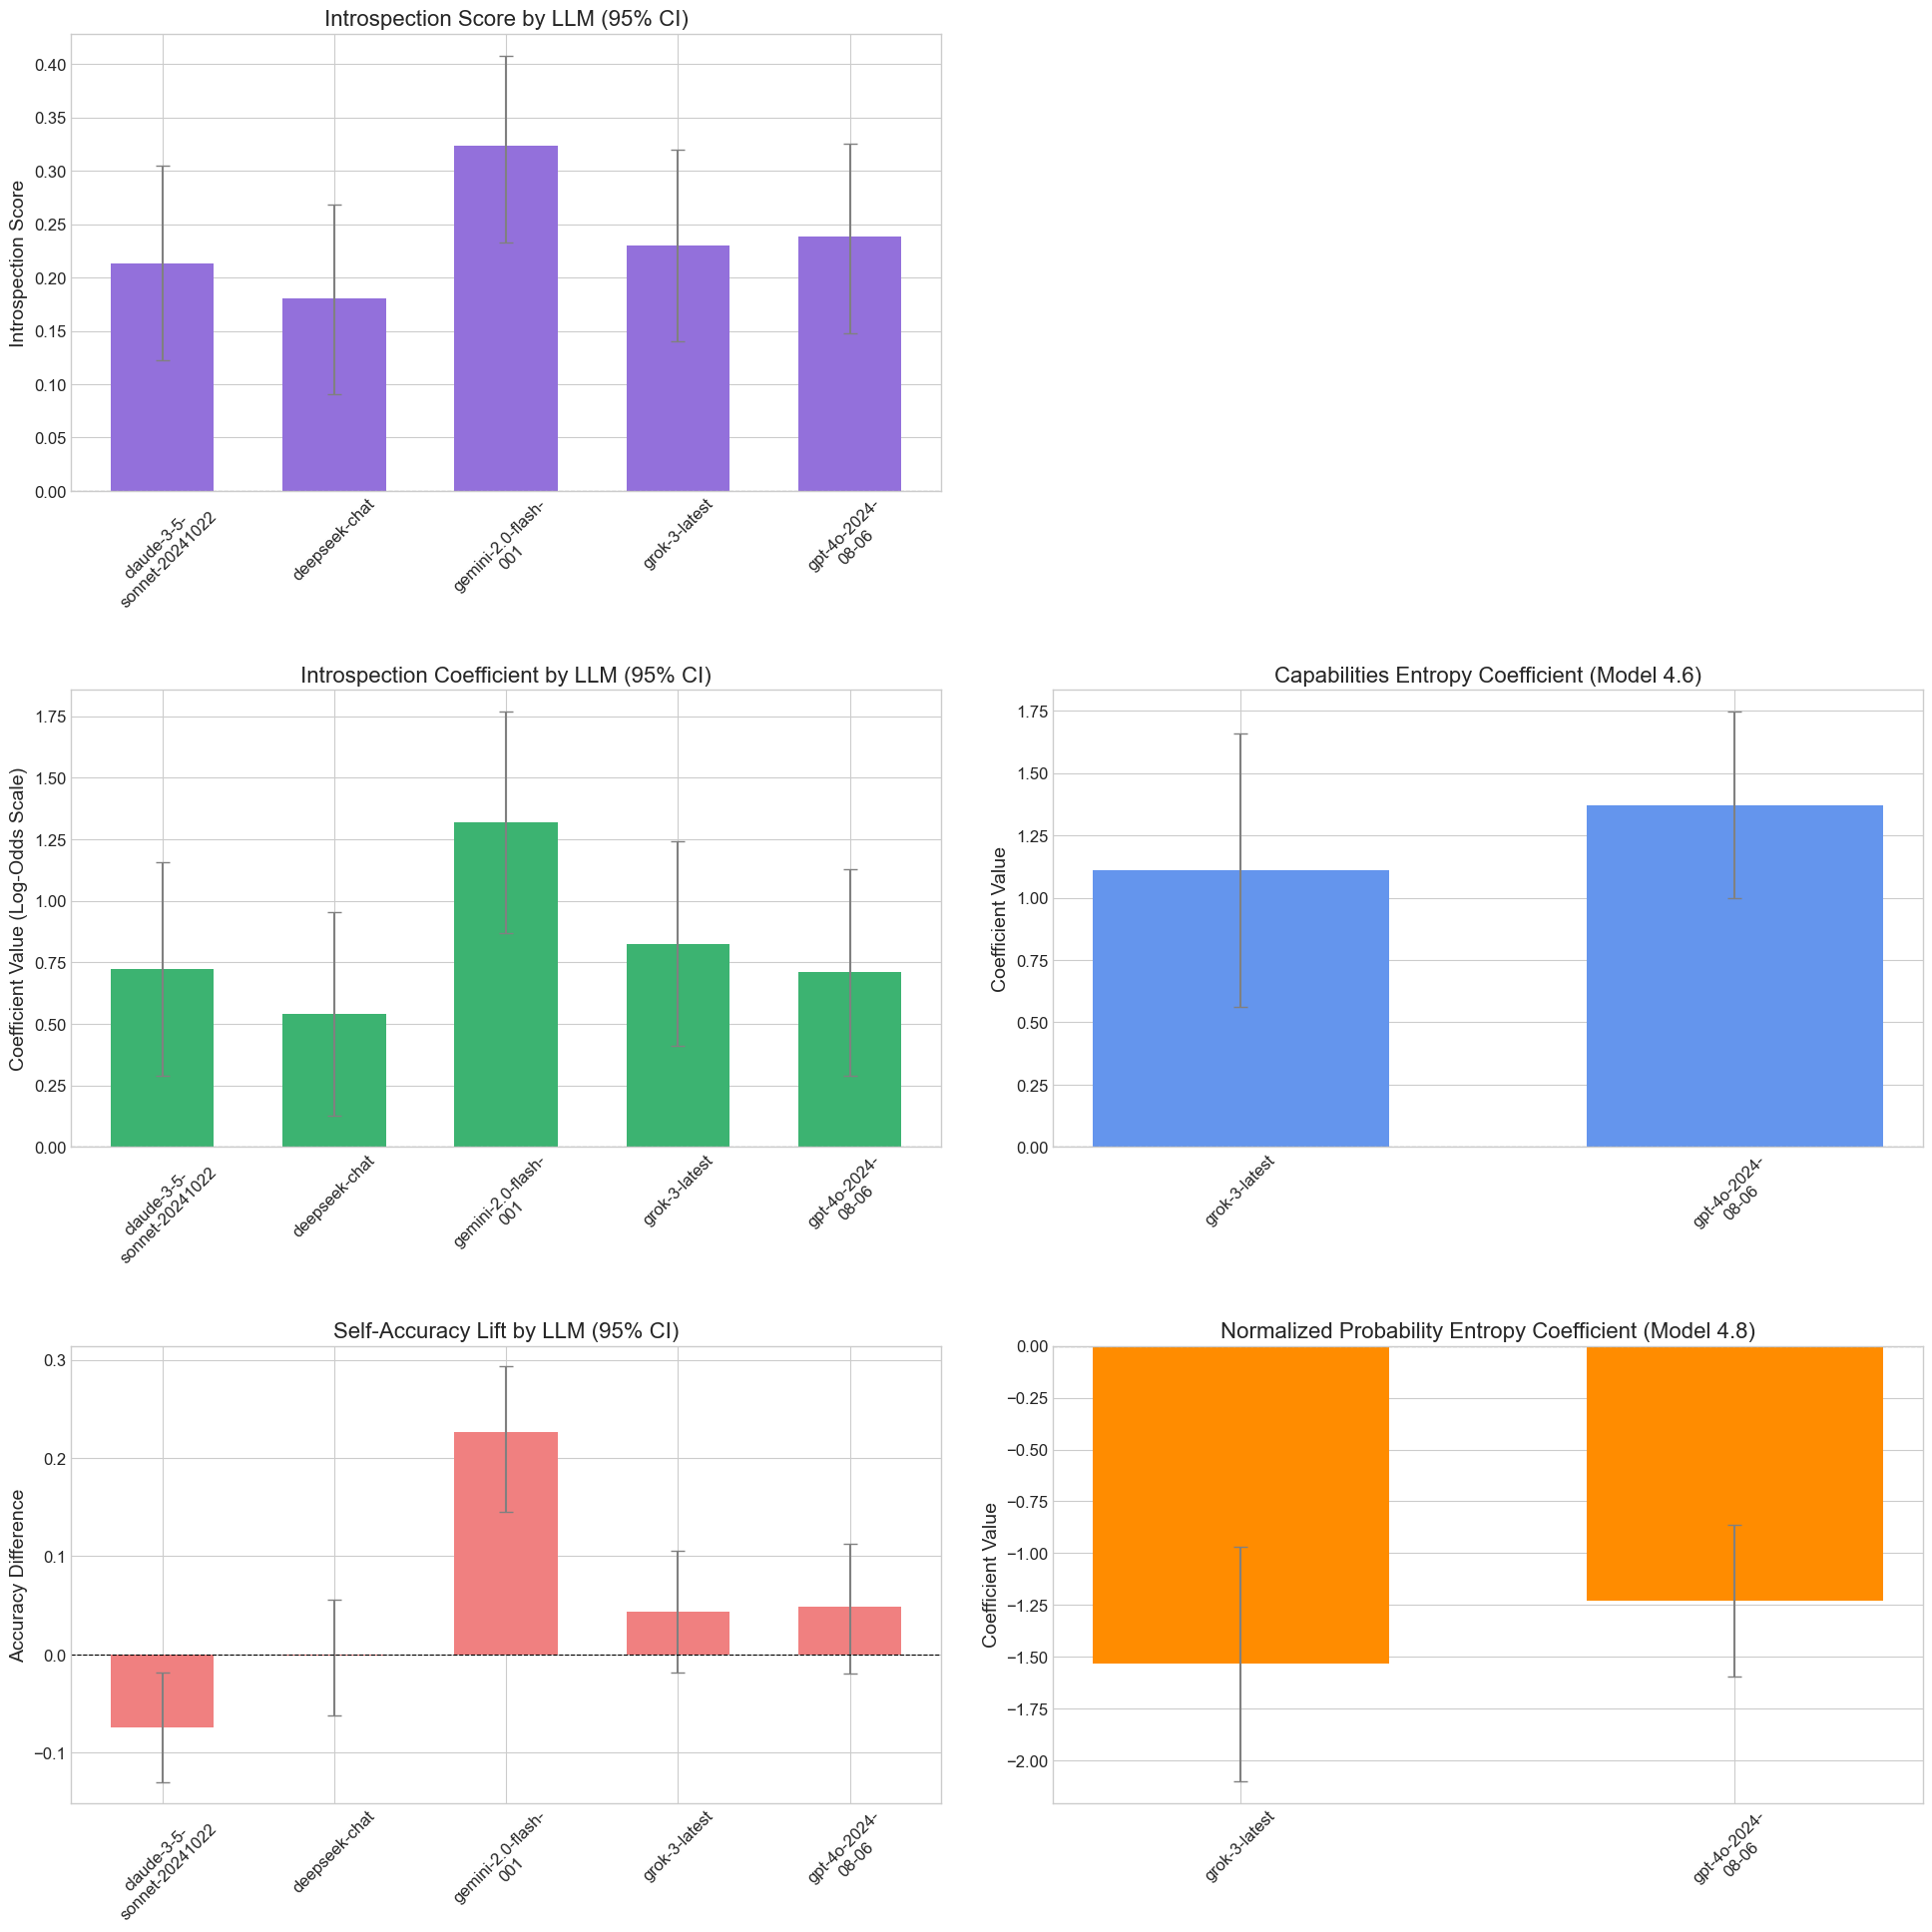

In [77]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
import warnings

# Z-score for 95% CI
Z_SCORE = norm.ppf(0.975)

def parse_analysis_log(log_content, output_file, target_params, model_list, adj_int=True, adj_lift=True):
    
    block_start_regex = re.compile(
        r"--- Analyzing (\S+) \(" + re.escape(target_params) + r", \d+ game files\) ---"
    )

    adj_introspection_regex = re.compile(r"Adjusted introspection score = ([-\d.]+) \[([-\d.]+), ([-\d.]+)\]")
    adj_self_acc_lift_regex = re.compile(r"Adjusted self-acc lift = ([-\d.]+)\s*\[([-\d.]+), ([-\d.]+)")
    raw_introspection_regex = re.compile(r"Introspection score = ([-\d.]+) \[([-\d.]+), ([-\d.]+)\]")
    raw_self_acc_lift_regex = re.compile(r"Self-acc lift = ([-\d.]+)\s*\[([-\d.]+), ([-\d.]+)")
    game_test_change_regex = re.compile(r"Game-Test Change Rate: ([-\d.]+)")
    introspection_regex = adj_introspection_regex if adj_int else raw_introspection_regex
    self_acc_lift_regex = adj_self_acc_lift_regex if adj_lift else raw_self_acc_lift_regex
    prefix_int = "adj" if adj_int else "raw"
    prefix_lift = "adj" if adj_lift else "raw"
    
    # Model section identifiers
    model4_start_regex = re.compile(r"^\s*Model 4.*\(No Interactions\).*:\s*delegate_choice ~")
    model46_start_regex = re.compile(r"^\s*Model 4\.6.*:\s*delegate_choice ~")
    model48_start_regex = re.compile(r"^\s*Model 4\.8.*:\s*delegate_choice ~")
    model7_start_regex = re.compile(r"^\s*Model 7.*:\s*delegate_choice ~")
    
    # Logit regression results marker
    logit_results_regex = re.compile(r"^\s*Logit Regression Results\s*$")
    
    # Coefficient extraction regexes
    si_capability_coef_regex = re.compile(r"^\s*s_i_capability\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)")
    capabilities_entropy_coef_regex = re.compile(r"^\s*capabilities_entropy\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)")
    normalized_prob_entropy_coef_regex = re.compile(r"^\s*normalized_prob_entropy\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)")
    
    # Log-likelihood regex
    log_likelihood_regex = re.compile(r"Log-Likelihood:\s*([-\d.]+)")

    # Cross-tabulation regexes 
    crosstab_title_regex = re.compile(r"^\s*Cross-tabulation of delegate_choice vs\. s_i_capability:$")
    crosstab_col_header_regex = re.compile(r"^\s*s_i_capability\s+\S+\s+\S+")
    crosstab_row_header_label_regex = re.compile(r"^\s*delegate_choice\s*$")
    crosstab_data_row_regex = re.compile(r"^\s*\d+\s+(\d+)\s+(\d+)\s*$")

    analysis_blocks = re.split(r"(?=--- Analyzing )", log_content)

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for block_content in analysis_blocks:
            if not block_content.strip():
                continue

            match_block_start = block_start_regex.search(block_content)
            if match_block_start:
                subject_name = match_block_start.group(1)
                if subject_name not in model_list:
                    print(f"Skipping subject {subject_name} as it is not in the provided model list.")
                    continue
                
                outfile.write(f"Subject: {subject_name}\n")
                
                extracted_info = {
                    f"{prefix_int}_introspection": "Not found",
                    f"{prefix_int}_introspection_ci_low": "Not found",
                    f"{prefix_int}_introspection_ci_high": "Not found",
                    f"{prefix_lift}_self_acc_lift": "Not found",
                    f"{prefix_lift}_self_acc_lift_ci_low": "Not found",
                    f"{prefix_lift}_self_acc_lift_ci_high": "Not found",
                    "model4_si_cap_coef": "Not found",
                    "model4_si_cap_ci_low": "Not found",
                    "model4_si_cap_ci_high": "Not found",
                    "model4_log_lik": "Not found",
                    "model46_cap_entropy_coef": "Not found",
                    "model46_cap_entropy_ci_low": "Not found",
                    "model46_cap_entropy_ci_high": "Not found",
                    "model48_norm_prob_entropy_coef": "Not found",
                    "model48_norm_prob_entropy_ci_low": "Not found",
                    "model48_norm_prob_entropy_ci_high": "Not found",
                    "model7_log_lik": "Not found",
                    "delegation_rate": "Not found",
                    "phase1_accuracy": "Not found",
                    "total_n": "Not found",
                    "game_test_change_rate": "Not found"
                }
                
                # Model parsing states
                in_model4 = False
                in_model46 = False
                in_model48 = False
                in_model7 = False
                found_logit_results = False

                # --- Cross-tab parsing state ---
                parsing_crosstab = False
                expecting_crosstab_col_header = False
                expecting_crosstab_row_header_label = False
                crosstab_data_lines_collected = 0
                temp_crosstab_cells = []

                lines = block_content.splitlines()
                for i, line in enumerate(lines):
                    # Extract adjusted introspection score
                    m = introspection_regex.search(line)
                    if m:
                        extracted_info[f"{prefix_int}_introspection"] = m.group(1)
                        extracted_info[f"{prefix_int}_introspection_ci_low"] = m.group(2)
                        extracted_info[f"{prefix_int}_introspection_ci_high"] = m.group(3)
                        continue
                    
                    # Extract adjusted self-acc lift
                    m = self_acc_lift_regex.search(line)
                    if m:
                        extracted_info[f"{prefix_lift}_self_acc_lift"] = m.group(1)
                        extracted_info[f"{prefix_lift}_self_acc_lift_ci_low"] = m.group(2)
                        extracted_info[f"{prefix_lift}_self_acc_lift_ci_high"] = m.group(3)
                        continue

                    # Extract game test change rate
                    m = game_test_change_regex.search(line)
                    if m:
                        extracted_info["game_test_change_rate"] = m.group(1)
                        continue

                    # Cross-tabulation parsing state machine
                    if not parsing_crosstab and not any([in_model4, in_model46, in_model48, in_model7]) and crosstab_title_regex.match(line):
                        parsing_crosstab = True
                        expecting_crosstab_col_header = True
                        expecting_crosstab_row_header_label = False
                        crosstab_data_lines_collected = 0
                        temp_crosstab_cells = []
                        continue

                    if parsing_crosstab:
                        if expecting_crosstab_col_header and crosstab_col_header_regex.match(line):
                            expecting_crosstab_col_header = False
                            expecting_crosstab_row_header_label = True
                            continue
                        elif expecting_crosstab_row_header_label and crosstab_row_header_label_regex.match(line):
                            expecting_crosstab_row_header_label = False
                            continue
                        else:
                            data_match = crosstab_data_row_regex.match(line)
                            if data_match:
                                temp_crosstab_cells.append(int(data_match.group(1)))
                                temp_crosstab_cells.append(int(data_match.group(2)))
                                crosstab_data_lines_collected += 1
                                if crosstab_data_lines_collected == 2 and len(temp_crosstab_cells) == 4:
                                    # Calculate delegation rate, phase 1 accuracy, and total N
                                    # temp_crosstab_cells = [row0_col0, row0_col1, row1_col0, row1_col1]
                                    total_n = sum(temp_crosstab_cells)
                                    delegation_rate = (temp_crosstab_cells[2] + temp_crosstab_cells[3]) / total_n if total_n > 0 else 0
                                    phase1_accuracy = (temp_crosstab_cells[1] + temp_crosstab_cells[3]) / total_n if total_n > 0 else 0
                                    
                                    extracted_info["delegation_rate"] = str(delegation_rate)
                                    extracted_info["phase1_accuracy"] = str(phase1_accuracy)
                                    extracted_info["total_n"] = str(total_n)
                                    parsing_crosstab = False
                                continue
                            # blank or unexpected line ends crosstab
                            if not line.strip():
                                parsing_crosstab = False
                            continue

                    # Check for model starts
                    if model4_start_regex.search(line):
                        in_model4 = True
                        in_model46 = False
                        in_model48 = False
                        in_model7 = False
                        found_logit_results = False
                        parsing_crosstab = False
                        continue
                    elif model46_start_regex.search(line):
                        in_model4 = False
                        in_model46 = True
                        in_model48 = False
                        in_model7 = False
                        found_logit_results = False
                        parsing_crosstab = False
                        continue
                    elif model48_start_regex.search(line):
                        in_model4 = False
                        in_model46 = False
                        in_model48 = True
                        in_model7 = False
                        found_logit_results = False
                        parsing_crosstab = False
                        continue
                    elif model7_start_regex.search(line):
                        in_model4 = False
                        in_model46 = False
                        in_model48 = False
                        in_model7 = True
                        found_logit_results = False
                        parsing_crosstab = False
                        continue
                    
                    # Check for Logit Regression Results
                    if not parsing_crosstab and logit_results_regex.match(line):
                        found_logit_results = True
                        continue
                    
                    # Extract coefficients and log-likelihood based on current model
                    if not parsing_crosstab:
                        if in_model4 and found_logit_results:
                            # Look for s_i_capability coefficient
                            m = si_capability_coef_regex.match(line)
                            if m:
                                extracted_info["model4_si_cap_coef"] = m.group(1)
                                extracted_info["model4_si_cap_ci_low"] = m.group(5)
                                extracted_info["model4_si_cap_ci_high"] = m.group(6)
                            
                            # Look for log-likelihood
                            m = log_likelihood_regex.search(line)
                            if m:
                                extracted_info["model4_log_lik"] = m.group(1)
                        
                        elif in_model46 and found_logit_results:
                            # Look for capabilities_entropy coefficient
                            m = capabilities_entropy_coef_regex.match(line)
                            if m:
                                extracted_info["model46_cap_entropy_coef"] = m.group(1)
                                extracted_info["model46_cap_entropy_ci_low"] = m.group(5)
                                extracted_info["model46_cap_entropy_ci_high"] = m.group(6)
                        
                        elif in_model48 and found_logit_results:
                            # Look for normalized_prob_entropy coefficient
                            m = normalized_prob_entropy_coef_regex.match(line)
                            if m:
                                extracted_info["model48_norm_prob_entropy_coef"] = m.group(1)
                                extracted_info["model48_norm_prob_entropy_ci_low"] = m.group(5)
                                extracted_info["model48_norm_prob_entropy_ci_high"] = m.group(6)
                        
                        elif in_model7 and found_logit_results:
                            # Look for log-likelihood
                            m = log_likelihood_regex.search(line)
                            if m:
                                extracted_info["model7_log_lik"] = m.group(1)
                    
                        # Reset state if we see a new model or section
                        if line.strip().startswith("Model ") and not any([
                            model4_start_regex.search(line),
                            model46_start_regex.search(line),
                            model48_start_regex.search(line),
                            model7_start_regex.search(line)
                        ]):
                            in_model4 = in_model46 = in_model48 = in_model7 = False
                
                # Validate required fields and write output
                if extracted_info["model4_si_cap_coef"] == "Not found":
                    raise ValueError(f"Model 4 s_i_capability coefficient not found for {subject_name}. Check that Model 4 has Logit Regression Results.")
                if extracted_info["model4_log_lik"] == "Not found":
                    raise ValueError(f"Model 4 Log-Likelihood not found for {subject_name}")
                if extracted_info["model7_log_lik"] == "Not found":
                    raise ValueError(f"Model 7 Log-Likelihood not found for {subject_name}. Check that Model 7 has Logit Regression Results.")
                
                # Warnings for optional fields
                if extracted_info["model46_cap_entropy_coef"] == "Not found":
                    print(f"Warning: Model 4.6 capabilities_entropy coefficient not found for {subject_name}")
                if extracted_info["model48_norm_prob_entropy_coef"] == "Not found":
                    print(f"Warning: Model 4.8 normalized_prob_entropy coefficient not found for {subject_name}")
                
                # Write extracted info
                prefix_int_cln = "Adjusted " if adj_int else "Raw "
                prefix_lift_cln = "Adjusted " if adj_lift else "Raw "
                outfile.write(f"  {prefix_int_cln}introspection score: {extracted_info[f'{prefix_int}_introspection']} [{extracted_info[f'{prefix_int}_introspection_ci_low']}, {extracted_info[f'{prefix_int}_introspection_ci_high']}]\n")
                outfile.write(f"  {prefix_lift_cln}self-acc lift: {extracted_info[f'{prefix_lift}_self_acc_lift']} [{extracted_info[f'{prefix_lift}_self_acc_lift_ci_low']}, {extracted_info[f'{prefix_lift}_self_acc_lift_ci_high']}]\n")
                outfile.write(f"  Model 4 s_i_capability: {extracted_info['model4_si_cap_coef']} [{extracted_info['model4_si_cap_ci_low']}, {extracted_info['model4_si_cap_ci_high']}]\n")
                outfile.write(f"  Model 4 Log-Likelihood: {extracted_info['model4_log_lik']}\n")
                outfile.write(f"  Model 4.6 capabilities_entropy: {extracted_info['model46_cap_entropy_coef']} [{extracted_info['model46_cap_entropy_ci_low']}, {extracted_info['model46_cap_entropy_ci_high']}]\n")
                outfile.write(f"  Model 4.8 normalized_prob_entropy: {extracted_info['model48_norm_prob_entropy_coef']} [{extracted_info['model48_norm_prob_entropy_ci_low']}, {extracted_info['model48_norm_prob_entropy_ci_high']}]\n")
                outfile.write(f"  Model 7 Log-Likelihood: {extracted_info['model7_log_lik']}\n")
                outfile.write(f"  Delegation rate: {extracted_info['delegation_rate']}\n")
                outfile.write(f"  Phase 1 accuracy: {extracted_info['phase1_accuracy']}\n")
                outfile.write(f"  Total N: {extracted_info['total_n']}\n")
                outfile.write(f"  Game-Test Change Rate: {extracted_info['game_test_change_rate']}\n")
                outfile.write("\n")

    print(f"Parsing complete. Output written to {output_file}")


def parse_value(text, pattern, group=1, as_type=float):
    """Helper to extract a value using regex and convert its type."""
    match = re.search(pattern, text)
    if match:
        try:
            return as_type(match.group(group))
        except (ValueError, TypeError):
            print(f"Warning: Could not convert value from '{text}' using pattern '{pattern}' to type {as_type}")
            return None
    return None


def analyze_parsed_data(input_summary_file):
    all_subject_data = []
    current_subject_info = {}

    with open(input_summary_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if line.startswith("Subject:"):
                if current_subject_info.get("subject_name"):
                    all_subject_data.append(current_subject_info)
                current_subject_info = {"subject_name": line.split("Subject:")[1].strip()}
            elif "introspection score:" in line:
                # Parse: "Adjusted introspection score: 0.167 [0.070, 0.262]"
                prefix_int = "adj" if "Adjusted" in line else "raw"
                m = re.search(r":\s*([-\d.]+)\s*\[([-\d.]+),\s*([-\d.]+)\]", line)
                if m:
                    current_subject_info[f"{prefix_int}_introspection"] = float(m.group(1))
                    current_subject_info[f"{prefix_int}_introspection_ci_low"] = float(m.group(2))
                    current_subject_info[f"{prefix_int}_introspection_ci_high"] = float(m.group(3))
            elif "self-acc lift:" in line:
                # Parse: "Adjusted self-acc lift: 0.178 [0.062, 0.280]"
                prefix_lift = "adj" if "Adjusted" in line else "raw"
                m = re.search(r":\s*([-\d.]+)\s*\[([-\d.]+),\s*([-\d.]+)\]", line)
                if m:
                    current_subject_info[f"{prefix_lift}_self_acc_lift"] = float(m.group(1))
                    current_subject_info[f"{prefix_lift}_self_acc_lift_ci_low"] = float(m.group(2))
                    current_subject_info[f"{prefix_lift}_self_acc_lift_ci_high"] = float(m.group(3))
            elif "Model 4 s_i_capability:" in line:
                # Parse: "Model 4 s_i_capability: -0.8796 [-1.451, -0.309]"
                m = re.search(r":\s*([-\d.]+)\s*\[([-\d.]+),\s*([-\d.]+)\]", line)
                if m:
                    current_subject_info["si_coef"] = float(m.group(1))
                    current_subject_info["si_coef_ci_low"] = float(m.group(2))
                    current_subject_info["si_coef_ci_high"] = float(m.group(3))
            elif "Model 4 Log-Likelihood:" in line:
                current_subject_info["loglik4"] = parse_value(line, r":\s*([-\d.]+)", as_type=float)
            elif "Model 4.6 capabilities_entropy:" in line:
                # Parse: "Model 4.6 capabilities_entropy: 2.7523 [1.396, 4.109]"
                m = re.search(r":\s*([-\d.]+)\s*\[([-\d.]+),\s*([-\d.]+)\]", line)
                if m:
                    current_subject_info["cap_entropy_coef"] = float(m.group(1))
                    current_subject_info["cap_entropy_ci_low"] = float(m.group(2))
                    current_subject_info["cap_entropy_ci_high"] = float(m.group(3))
            elif "Model 4.8 normalized_prob_entropy:" in line:
                # Parse: "Model 4.8 normalized_prob_entropy: 4.8797 [2.541, 7.218]"
                m = re.search(r":\s*([-\d.]+)\s*\[([-\d.]+),\s*([-\d.]+)\]", line)
                if m:
                    current_subject_info["norm_prob_entropy_coef"] = float(m.group(1))
                    current_subject_info["norm_prob_entropy_ci_low"] = float(m.group(2))
                    current_subject_info["norm_prob_entropy_ci_high"] = float(m.group(3))
            elif "Model 7 Log-Likelihood:" in line:
                current_subject_info["loglik7"] = parse_value(line, r":\s*([-\d.]+)", as_type=float)
            elif "Delegation rate:" in line:
                current_subject_info["delegation_rate"] = parse_value(line, r":\s*([-\d.]+)", as_type=float)
            elif "Phase 1 accuracy:" in line:
                current_subject_info["phase1_accuracy"] = parse_value(line, r":\s*([-\d.]+)", as_type=float)
            elif "Total N:" in line:
                current_subject_info["total_n"] = parse_value(line, r":\s*(\d+)", as_type=int)
            elif "Game-Test Change Rate:" in line:
                current_subject_info["game_test_change_rate"] = parse_value(line, r":\s*([-\d.]+)", as_type=float)

        if current_subject_info.get("subject_name"):
            all_subject_data.append(current_subject_info)

    results = []
    for data in all_subject_data:
        subject_name = data.get("subject_name", "Unknown")
        
        # Get all the values, using np.nan for missing optional values
        adj_introspection = data.get(f"{prefix_int}_introspection", np.nan)
        adj_introspection_ci_low = data.get(f"{prefix_int}_introspection_ci_low", np.nan)
        adj_introspection_ci_high = data.get(f"{prefix_int}_introspection_ci_high", np.nan)
        
        adj_self_acc_lift = data.get(f"{prefix_lift}_self_acc_lift", np.nan)
        adj_self_acc_lift_ci_low = data.get(f"{prefix_lift}_self_acc_lift_ci_low", np.nan)
        adj_self_acc_lift_ci_high = data.get(f"{prefix_lift}_self_acc_lift_ci_high", np.nan)
        
        si_coef = data.get("si_coef", np.nan)
        si_ci_low = data.get("si_coef_ci_low", np.nan)
        si_ci_high = data.get("si_coef_ci_high", np.nan)
        
        # Reverse the sign of SI coefficient as in original code
        rev_si_coef = -1 * si_coef if not np.isnan(si_coef) else np.nan
        rev_si_ci_low = -1 * si_ci_high if not np.isnan(si_ci_high) else np.nan
        rev_si_ci_high = -1 * si_ci_low if not np.isnan(si_ci_low) else np.nan
        
        cap_entropy_coef = data.get("cap_entropy_coef", np.nan)
        cap_entropy_ci_low = data.get("cap_entropy_ci_low", np.nan)
        cap_entropy_ci_high = data.get("cap_entropy_ci_high", np.nan)
        
        norm_prob_entropy_coef = data.get("norm_prob_entropy_coef", np.nan)
        norm_prob_entropy_ci_low = data.get("norm_prob_entropy_ci_low", np.nan)
        norm_prob_entropy_ci_high = data.get("norm_prob_entropy_ci_high", np.nan)
        
        LL4 = data.get("loglik4", np.nan)
        LL7 = data.get("loglik7", np.nan)
        
        # Calculate likelihood ratio test
        LR_stat = 2 * (LL4 - LL7) if not np.isnan(LL4) and not np.isnan(LL7) else np.nan
        LR_pvalue = chi2.sf(LR_stat, df=1) if not np.isnan(LR_stat) else np.nan

        # Get delegation rate, phase 1 accuracy, and total N
        delegation_rate = data.get("delegation_rate", np.nan)
        phase1_accuracy = data.get("phase1_accuracy", np.nan)
        total_n = data.get("total_n", np.nan)

        results.append({
            "Subject": subject_name,
            f"{prefix_int.capitalize()} Intro": adj_introspection,
            f"{prefix_int.capitalize()}Intro_LB": adj_introspection_ci_low,
            f"{prefix_int.capitalize()}Intro_UB": adj_introspection_ci_high,
            f"{prefix_lift.capitalize()} Acc Lift": adj_self_acc_lift,
            f"{prefix_lift.capitalize()}AccLift_LB": adj_self_acc_lift_ci_low,
            f"{prefix_lift.capitalize()}AccLift_UB": adj_self_acc_lift_ci_high,
            "Cap Coef": rev_si_coef,
            "CapCoef_LB": rev_si_ci_low,
            "CapCoef_UB": rev_si_ci_high,
            "Cap Ent": cap_entropy_coef,
            "CapEnt_LB": cap_entropy_ci_low,
            "CapEnt_UB": cap_entropy_ci_high,
            "Game Ent": norm_prob_entropy_coef,
            "GameEnt_LB": norm_prob_entropy_ci_low,
            "GameEnt_UB": norm_prob_entropy_ci_high,
            "LL_Model4": LL4,
            "LL_Model7": LL7,
            "LR_stat": LR_stat,
            "LR_pvalue": LR_pvalue,
            "Delegation_Rate": delegation_rate,
            "Phase1_Accuracy": phase1_accuracy,
            "Total_N": total_n,
            "Change%": data.get("game_test_change_rate", np.nan)
        })
        
    return pd.DataFrame(results)


def break_subject_name(name, max_parts_per_line=3):
    """Breaks a subject name string by hyphens for better display."""
    parts = name.split('-')
    if len(parts) <= max_parts_per_line:
        return name
    
    wrapped_name = ""
    for i, part in enumerate(parts):
        wrapped_name += part
        if (i + 1) % max_parts_per_line == 0 and (i + 1) < len(parts):
            wrapped_name += "-\n"
        elif (i + 1) < len(parts):
            wrapped_name += "-"
    return wrapped_name


def plot_results(df_results, subject_order=None, dataset_name="GPQA", adj_int=True, adj_lift=True):
    prefix_int = "Adj" if adj_int else "Raw"
    prefix_lift = "Adj" if adj_lift else "Raw"
    prefix_int_cln = "Adjusted " if adj_int else ""
    prefix_lift_cln = "Adjusted " if adj_lift else ""
    if df_results.empty:
        print("No data to plot.")
        return

    # Reorder DataFrame if subject_order is provided
    if subject_order:
        df_results_ordered = df_results.copy()
        df_results_ordered['Subject_Cat'] = pd.Categorical(df_results_ordered['Subject'], categories=subject_order, ordered=True)
        df_results_ordered = df_results_ordered[df_results_ordered['Subject_Cat'].notna()].sort_values('Subject_Cat')
        if df_results_ordered.empty and not df_results.empty:
            print("Warning: None of the subjects in subject_order were found in the data. Plotting all available subjects.")
        elif len(df_results_ordered) < len(df_results):
             print(f"Warning: Plotting only {len(df_results_ordered)} subjects present in the provided order list.")
             df_results = df_results_ordered.drop(columns=['Subject_Cat'])
        else:
            df_results = df_results_ordered.drop(columns=['Subject_Cat'])

    num_subjects = len(df_results)
    if num_subjects == 0:
        print("No subjects to plot after filtering/ordering.")
        return

    # Check if we have entropy coefficients
    has_cap_entropy = not df_results["Cap Ent"].isna().all()
    has_norm_prob_entropy = not df_results["Game Ent"].isna().all()
    has_entropy = has_cap_entropy or has_norm_prob_entropy
    
    # Determine number of columns
    ncols = 2 if has_entropy else 1
    
    # Apply name breaking for x-axis labels
    formatted_subject_names = [break_subject_name(name, max_parts_per_line=3) for name in df_results["Subject"]]

    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        try:
            plt.style.use('seaborn-whitegrid')
        except:
            print("Seaborn whitegrid style not found, using default.")
            pass

    # Create figure with appropriate number of subplots
    if has_entropy:
        fig, axs = plt.subplots(3, 2, figsize=(max(20, num_subjects * 2.0 + 4), 20))
        axs = axs.reshape(3, 2)  # Ensure it's a 2D array
    else:
        fig, axs = plt.subplots(3, 1, figsize=(max(10, num_subjects * 1.0 + 2), 20))
        axs = axs.reshape(3, 1)  # Make it 2D for consistent indexing

    # Font sizes
    title_fontsize = 16
    label_fontsize = 14
    tick_fontsize = 12
    legend_fontsize = 12

    # --- Plot 1: Adjusted Introspection Score ---
    yerr_intro_low = np.nan_to_num(df_results[f"{prefix_int} Intro"] - df_results[f"{prefix_int}Intro_LB"], nan=0.0)
    yerr_intro_high = np.nan_to_num(df_results[f"{prefix_int}Intro_UB"] - df_results[f"{prefix_int} Intro"], nan=0.0)
    yerr_intro_low[yerr_intro_low < 0] = 0
    yerr_intro_high[yerr_intro_high < 0] = 0
    
    axs[0, 0].bar(formatted_subject_names, df_results[f"{prefix_int} Intro"],
                   color='mediumpurple',
                   yerr=[yerr_intro_low, yerr_intro_high], ecolor='gray', capsize=5, width=0.6)
    axs[0, 0].set_ylabel('Introspection Score', fontsize=label_fontsize)
    axs[0, 0].set_title(f'{prefix_int_cln}Introspection Score by LLM (95% CI)', fontsize=title_fontsize)
    axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axs[0, 0].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
    axs[0, 0].tick_params(axis='y', labelsize=tick_fontsize)

    # --- Plot 2: Reversed s_i_capability Coefficient ---
    yerr_si_low = np.nan_to_num(df_results["Cap Coef"] - df_results["CapCoef_LB"], nan=0.0)
    yerr_si_high = np.nan_to_num(df_results["CapCoef_UB"] - df_results["Cap Coef"], nan=0.0)
    yerr_si_low[yerr_si_low < 0] = 0
    yerr_si_high[yerr_si_high < 0] = 0
    
    axs[1, 0].bar(formatted_subject_names, df_results["Cap Coef"],
                   color='mediumseagreen',
                   yerr=[yerr_si_low, yerr_si_high], ecolor='gray', capsize=5, width=0.6)
    axs[1, 0].set_ylabel('Coefficient Value (Log-Odds Scale)', fontsize=label_fontsize)
    axs[1, 0].set_title('Introspection Coefficient by LLM (95% CI)', fontsize=title_fontsize)
    axs[1, 0].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axs[1, 0].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
    axs[1, 0].tick_params(axis='y', labelsize=tick_fontsize)

    # --- Plot 3: Adjusted Self-Accuracy Lift ---
    yerr_acc_lift_low = np.nan_to_num(df_results[f"{prefix_lift} Acc Lift"] - df_results[f"{prefix_lift}AccLift_LB"], nan=0.0)
    yerr_acc_lift_high = np.nan_to_num(df_results[f"{prefix_lift}AccLift_UB"] - df_results[f"{prefix_lift} Acc Lift"], nan=0.0)
    yerr_acc_lift_low[yerr_acc_lift_low < 0] = 0
    yerr_acc_lift_high[yerr_acc_lift_high < 0] = 0
    
    axs[2, 0].bar(formatted_subject_names, df_results[f"{prefix_lift} Acc Lift"],
                   color='lightcoral',
                   yerr=[yerr_acc_lift_low, yerr_acc_lift_high], ecolor='gray', capsize=5, width=0.6)
    axs[2, 0].set_ylabel('Accuracy Difference', fontsize=label_fontsize)
    axs[2, 0].set_title(f'{prefix_lift_cln}Self-Accuracy Lift by LLM (95% CI)', fontsize=title_fontsize)
    axs[2, 0].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axs[2, 0].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
    axs[2, 0].tick_params(axis='y', labelsize=tick_fontsize)

    # If we have entropy coefficients, plot them in the second column
    if has_entropy:
        # Hide the first row, second column (no plot there)
        axs[0, 1].axis('off')
        
        if has_cap_entropy:
            # --- Plot 4: Capabilities Entropy Coefficient ---
            yerr_cap_low = np.nan_to_num(df_results["Cap Ent"] - df_results["CapEnt_LB"], nan=0.0)
            yerr_cap_high = np.nan_to_num(df_results["CapEnt_UB"] - df_results["Cap Ent"], nan=0.0)
            yerr_cap_low[yerr_cap_low < 0] = 0
            yerr_cap_high[yerr_cap_high < 0] = 0
            
            axs[1, 1].bar(formatted_subject_names, df_results["Cap Ent"],
                           color='cornflowerblue',
                           yerr=[yerr_cap_low, yerr_cap_high], ecolor='gray', capsize=5, width=0.6)
            axs[1, 1].set_ylabel('Coefficient Value', fontsize=label_fontsize)
            axs[1, 1].set_title('Capabilities Entropy Coefficient (Model 4.6)', fontsize=title_fontsize)
            axs[1, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
            axs[1, 1].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
            axs[1, 1].tick_params(axis='y', labelsize=tick_fontsize)
        else:
            axs[1, 1].axis('off')
        
        if has_norm_prob_entropy:
            # --- Plot 5: Normalized Probability Entropy Coefficient ---
            yerr_norm_low = np.nan_to_num(df_results["Game Ent"] - df_results["GameEnt_LB"], nan=0.0)
            yerr_norm_high = np.nan_to_num(df_results["GameEnt_UB"] - df_results["Game Ent"], nan=0.0)
            yerr_norm_low[yerr_norm_low < 0] = 0
            yerr_norm_high[yerr_norm_high < 0] = 0
            
            axs[2, 1].bar(formatted_subject_names, df_results["Game Ent"],
                           color='darkorange',
                           yerr=[yerr_norm_low, yerr_norm_high], ecolor='gray', capsize=5, width=0.6)
            axs[2, 1].set_ylabel('Coefficient Value', fontsize=label_fontsize)
            axs[2, 1].set_title('Normalized Probability Entropy Coefficient (Model 4.8)', fontsize=title_fontsize)
            axs[2, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
            axs[2, 1].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
            axs[2, 1].tick_params(axis='y', labelsize=tick_fontsize)
        else:
            axs[2, 1].axis('off')

    plt.tight_layout(pad=3.0, h_pad=4.0)
    plt.savefig(f"subject_analysis_charts_{dataset_name}.png", dpi=300)
    print(f"Charts saved to subject_analysis_charts_{dataset_name}.png")



game_type = "aop" #"dg"#
dataset = "GPQA"
if game_type == "dg":
    target_params = "Feedback_False, Non_Redacted, NoSubjAccOverride, NoSubjGameOverride, NotRandomized, WithHistory, NotFiltered"#
    if dataset != "GPSA" and dataset!= "SimpleMC": target_params = target_params.replace(", NoSubjGameOverride", "")
else:
    target_params = "NoMsgHist, NoQCtr, NoPCtr, NoSCtr"
model_list = ['claude-3-5-sonnet-20241022', 'deepseek-chat', 'gemini-2.0-flash-001', 'grok-3-latest', 'gpt-4o-2024-08-06', 'meta-llama-Meta-Llama-3.1-405B-Instruct', 'claude-3-haiku-20240307', 'claude-3-sonnet-20240229', 'gemini-2.5-flash-preview-04-17', 'gemini-1.5-pro']
#    model_list = ['claude-3-5-sonnet-20241022', 'gemini-2.0-flash-001', 'deepseek-chat', 'grok-3-latest', 'gpt-4o-2024-08-06', 'meta-llama-Meta-Llama-3.1-405B-Instruct', 'claude-3-haiku-20240307']
show_adjusted_introspection = False
show_adjusted_self_acc_lift = False

suffix = f"_{game_type}_full"
if "Feedback_True" in target_params: suffix += "_fb"
if "WithHistory" in target_params: suffix += "_hist" 
else: suffix += "_sum"
input_log_filename = f"analysis_log_multi_logres_{game_type}_{dataset.lower()}.txt"
output_filename = f"{input_log_filename.split('.')[0]}{suffix}_parsed.txt"

#    model_list = ['grok-3-latest', 'gemini-1.5-pro', 'claude-3-7-sonnet-20250219', 'gemini-2.0-flash-001', 'claude-3-5-sonnet-20241022', 'claude-3-opus-20240229', 'gpt-4-turbo-2024-04-09', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307']
#    model_list = ['claude-3-7-sonnet-20250219', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gemini-2.0-flash-001', 'gemini-1.5-pro', 'claude-3-opus-20240229', 'gpt-4-turbo-2024-04-09', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307']
#    model_list = ['claude-3-7-sonnet-20250219', 'grok-3-latest', 'gemini-2.0-flash-001', 'claude-3-5-sonnet-20241022', 'gemini-1.5-pro', 'claude-3-opus-20240229', 'gpt-4-turbo-2024-04-09', 'claude-3-haiku-20240307', 'claude-3-sonnet-20240229']

try:
    with open(input_log_filename, 'r', encoding='utf-8') as f:
        log_content_from_file = f.read()
    parse_analysis_log(log_content_from_file, output_filename, target_params, model_list, adj_int=show_adjusted_introspection, adj_lift=show_adjusted_self_acc_lift)

    df_results = analyze_parsed_data(output_filename)
    print("\n--- Calculated Data ---")
    print(df_results.to_string(formatters={"LR_pvalue": lambda p: ("" if pd.isna(p) else f"{p:.1e}" if p < 1e-4 else f"{p:.4f}")}))
    
    if not df_results.empty:
        plot_results(df_results, subject_order=model_list, dataset_name=f"{dataset}{suffix}", adj_int=show_adjusted_introspection, adj_lift=show_adjusted_self_acc_lift)
    else:
        print("No results to plot.")

except FileNotFoundError:
    print(f"Error: Input log file '{input_log_filename}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [1]:
"""
Second-Chance Game - testing a model's ability to change its answer when given feedback.

Features:
- Uses capabilities data to select questions the model got wrong
- Presents each with history showing model already answered incorrectly
- Analyzes how often the model changes its answer
- Can optionally show or redact the model's original answer
"""

import random
import time
import json
from base_game_class import BaseGameClass
from scipy.stats import binomtest

class SecondChanceGame(BaseGameClass):
    """
    Game class for the Second-Chance experiment.
    """
    def __init__(self, subject_id, subject_name, dataset, capabilities_file_path, 
                 num_questions=None, show_original_answer=True, is_human_player=False, seed=None, temperature=0.0):
        """
        Initialize the game with configuration parameters.
        
        Args:
            subject_id (str): Identifier for the subject/session
            subject_name (str): Name of the subject (model name for LLMs)
            capabilities_file_path (str): Path to stored capabilities/phase1 results
            num_questions (int): Number of questions to present
            show_original_answer (bool): Whether to show the original answer or redact it
            is_human_player (bool): Whether the subject is a human player or an LLM
        """
        super().__init__(subject_id, subject_name, is_human_player, "secondchance_game_logs")
        # Store configuration parameters
        self.dataset = dataset
        self.capabilities_file_path = capabilities_file_path
        self.num_questions = num_questions
        self.show_original_answer = show_original_answer
        self.is_human_player = is_human_player
        self.temperature = temperature
        if seed is not None:
            random.seed(seed)
        self.is_short_answer = True if self.dataset.lower() in ["simpleqa", "gpsa"] else False
                
        # Initialize state variables
        self.capabilities_data = None
        self.wrong_questions = []
        self.selected_questions = []
        self.game_results = {}
        self.message_history = []
                
        # Initialize log file
        setup_log_str = f"Second-Chance Game Log for Subject: {subject_id}\n"
        setup_log_str += f"Configuration: Questions={num_questions}, Show Original Answer={show_original_answer}\n"
        setup_log_str += f"Timestamp: {time.strftime('%Y-%m-%d %H:%M:%S')}"
        self._log(setup_log_str)
        
    def load_capabilities_data(self):
        """
        Load capabilities data from the provided file path
        and extract questions the subject got wrong
        """
        try:
            self._log(f"Loading capabilities data from: {self.capabilities_file_path}")
            with open(self.capabilities_file_path, 'r', encoding='utf-8') as f:
                self.capabilities_data = json.load(f)
            
            # Extract results from either AOP game or regular capabilities measurement
            if 'phase1_results' in self.capabilities_data:
                capabilities_results = self.capabilities_data['phase1_results']
            else:
                capabilities_results = self.capabilities_data.get('results', {})
            
            if not capabilities_results:
                raise ValueError("No results found in capabilities data file")
            
            # Find questions that were answered incorrectly
            for q_id, result in capabilities_results.items():
                if isinstance(result, dict) and not result.get('is_correct', True):
                    question_data = result
                    question_data['id'] = q_id
                    question_data['correct_answer'] = result.get('correct_answer_label')
                    question_data['original_answer'] = result.get('subject_answer')
                    
                    # Add to wrong questions list
                    self.wrong_questions.append(question_data)
            
            self._log(f"Found {len(self.wrong_questions)} questions that were answered incorrectly")
            
            if self.num_questions and len(self.wrong_questions) < self.num_questions:
                self._log(f"Warning: Only {len(self.wrong_questions)} wrong questions available, but {self.num_questions} requested")
                self.num_questions = len(self.wrong_questions)
            if not self.num_questions:
                self.num_questions = len(self.wrong_questions)
            
            return True
        except Exception as e:
            self._log(f"Error loading capabilities data: {e}")
            return False
    
    def select_questions(self):
        """
        Select a subset of questions for the game
        """
        if not self.wrong_questions:
            self._log("Error: No wrong questions available. Load capabilities data first.")
            return False
        
        # Determine how many questions to use
        num_to_use = min(self.num_questions, len(self.wrong_questions))
        
        # Randomly select questions
        self.selected_questions = random.sample(self.wrong_questions, num_to_use)
        self._log(f"Selected {len(self.selected_questions)} questions for the game")
        
        return True
    
    def run_game(self):
        """
        Run the Second-Chance Game
        """
        # Load capabilities data
        if not self.capabilities_data:
            if not self.load_capabilities_data():
                return False
        
        # Select questions
        if not self.selected_questions:
            if not self.select_questions():
                return False
        
        self._log("\n" + "="*10 + " Starting Second-Chance Game " + "="*10)
        
        # Initialize state
        message_history = []
        probs = None
        changed_answers = 0
        correct_after_feedback = 0
        
        # Process each question
        for i, question in enumerate(self.selected_questions):
            q_id = question.get('id', f"q_{i}")
            original_answer = question.get('original_answer')
            correct_answer = question.get('correct_answer')
            
            if not original_answer or not correct_answer:
                self._log(f"Warning: Missing data for question {q_id}, skipping")
                continue
            
            # Format question
            q_text = self._present_question(question)
                        
            self._log(f"\nPresenting question {i+1}/{len(self.selected_questions)}")
            self._log(f"Original answer: {original_answer}, Correct answer: {correct_answer}")
            
            # Get subject's answer
            if self.is_human_player:
                original_feedback = f"You previously answered this question and selected option {original_answer}, which was incorrect."
                redacted_feedback = f"You previously answered this question and selected [redacted], which was incorrect."
                feedback = original_feedback if self.show_original_answer else redacted_feedback
                prompt = f"{q_text}\n\n{feedback}\n\nPlease try again. Select the correct answer (A, B, C, or D): "
                print(prompt)
                new_answer = self._get_subject_answer(
                    list(question["options"].keys()), 
                    "Your answer (A, B, C, or D): "
                )
                if new_answer is None:
                    return False
            else:
                # For LLM subject
                if self.is_short_answer:
                    setup_prompt = "I'm going to ask you a series of short answer questions. For each one, respond as succinctly as possible. Answer as best you can, even if you're not certain."
                    llm_prompt = q_text + "\nYour answer: "
                else:
                    setup_prompt = "I'm going to ask you a series of multiple choice questions. For each one, select the answer you think is best."
                    llm_prompt = q_text + "\nYour choice (A, B, C, or D): "
                message_history = [{"role": "user", "content": setup_prompt + "\n\n" + llm_prompt}]
                content = original_answer if self.show_original_answer else "[redacted]"
                message_history.append({"role": "assistant", "content": content})
                content = "Your answer was incorrect. Choose again.\n\n" + llm_prompt # I lost your original answer, but I know it was wrong. Try to figure out what your first choice would have been, and then pick a different answer\n\n" + llm_prompt
                #message_history.append({"role": "user", "content": content})
                
                # Get the answer without accumulating history
                new_answer, _, probs = self._get_llm_answer(
                    list(question["options"].keys()) if not self.is_short_answer else None,
                    content,
                    message_history=message_history,
                    keep_appending=False,
                    setup_text="Respond ONLY with your answer\n" if self.is_short_answer else None,
                    MAX_TOKENS=1 if not self.is_short_answer else None,
                    temp = self.temperature
                )
            
            # Check if answer was changed
            answer_changed = (new_answer != original_answer) and new_answer in question["options"]
            if answer_changed:
                changed_answers += 1
                
            # Check if new answer is correct
            is_correct = (new_answer == correct_answer)
            if is_correct:
                correct_after_feedback += 1
            
            # Store result
            self.game_results[q_id] = {
                "question": question,
                "original_answer": original_answer,
                "new_answer": new_answer,
                "correct_answer": correct_answer,
                "answer_changed": answer_changed,
                "is_correct": is_correct,
                "probs": probs
            }
            
            self._log(f"New answer: {new_answer}, Changed: {answer_changed}, Correct: {is_correct}")
            
        # Save results
        self._save_results()
        
        # Analyze results
        self.analyze_results()
        
        return True
    
    def _save_results(self):
        """Save game results to file"""
        game_data = {
            "subject_id": self.subject_id,
            "subject_name": self.subject_name,
            "show_original_answer": self.show_original_answer,
            "num_questions": self.num_questions,
            "timestamp": time.time(),
            "results": self.game_results,
        }
            
        with open(self.game_data_filename, 'w', encoding='utf-8') as f:
            json.dump(game_data, f, indent=2, ensure_ascii=False)
            
        self._log(f"Game data saved to: {self.game_data_filename}")
    
    def analyze_results(self):
        """
        Analyze game results and generate statistics
        """
        if not self.game_results:
            raise ValueError("No game results to analyze. Run the game first.")
        
        # Create analysis
        analysis = "\n" + "="*10 + " Results Analysis " + "="*10 + "\n"
        analysis += f"Subject ID: {self.subject_id}\n"
        analysis += f"Original answers were {'shown' if self.show_original_answer else 'redacted'}\n"
        
        # Basic stats
        total_questions = len(self.game_results)
        changed_answers = sum(1 for r in self.game_results.values() if r.get('answer_changed'))
        correct_answers = sum(1 for r in self.game_results.values() if r.get('is_correct'))
        
        # Only count valid responses in the denominator
        valid_responses = sum(1 for r in self.game_results.values() if r.get('new_answer') in ["A", "B", "C", "D"])
        change_rate = changed_answers / valid_responses if valid_responses > 0 else 0
        accuracy = correct_answers / total_questions if total_questions > 0 else 0
        
        analysis += f"Total questions: {total_questions}\n"
        analysis += f"Answer change rate: {change_rate:.2%} ({changed_answers}/{valid_responses})\n"
        analysis += f"Accuracy after feedback: {accuracy:.2%} ({correct_answers}/{total_questions})\n"
        
        # Count how many changed answers were correct
        changed_and_correct = sum(1 for r in self.game_results.values() 
                                 if r.get('answer_changed') and r.get('is_correct'))
        
        # Count how many unchanged answers were correct
        unchanged_and_correct = sum(1 for r in self.game_results.values() 
                                   if not r.get('answer_changed') and r.get('is_correct'))
        
        if changed_answers > 0:
            changed_accuracy = changed_and_correct / changed_answers
            analysis += f"Accuracy when answer was changed: {changed_accuracy:.2%} ({changed_and_correct}/{changed_answers})\n"
        
        if total_questions - changed_answers > 0:
            unchanged_accuracy = unchanged_and_correct / (total_questions - changed_answers)
            analysis += f"Accuracy when answer was not changed: {unchanged_accuracy:.2%} ({unchanged_and_correct}/{total_questions - changed_answers})\n"
        
        # Statistical significance tests
        analysis += "\n--- Statistical Analysis ---\n"
        
        # Test if accuracy is better than random guessing (25%)
        binom_result = binomtest(k=correct_answers, n=total_questions, p=0.25)
        p_value = binom_result.pvalue
        
        analysis += f"Binomial test for accuracy vs. random guessing (25%): p-value = {p_value:.4f}\n"
        
        if p_value < 0.05:
            if accuracy > 0.25:
                analysis += "Interpretation: Accuracy is SIGNIFICANTLY HIGHER than random guessing (p < 0.05)\n"
            else:
                analysis += "Interpretation: Accuracy is SIGNIFICANTLY LOWER than random guessing (p < 0.05)\n"
        else:
            analysis += "Interpretation: No significant difference from random guessing (p >= 0.05)\n"
        
        
        # Print and log
        print(analysis)
        with open(self.log_filename, 'a', encoding='utf-8') as f:
            f.write(analysis)
            
        # Return for further use
        return analysis

def main(model_dataset_dict):
    """
    Main function to run the Second-Chance Game
    """
    # Configuration
    IS_HUMAN = False
    SHOW_ORIGINAL_ANSWER = False
    NUM_QUESTIONS = None  # Use all wrong questions if None
    seed = 42
    TEMPERATURE = 0.0 
    for SUBJECT_NAME, datasets in model_dataset_dict.items():
        for DATASET in datasets:
    
            if DATASET == "SimpleQA":
        #        CAPABILITES_TEST_FILE = get_latest_capabilities_file(SUBJECT_NAME, DATASET)
                CAPABILITIES_FILE = f"./compiled_results_sqa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
            elif DATASET == "GPSA":
                CAPABILITIES_FILE = f"./compiled_results_gpsa/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
            elif DATASET == "SimpleMC":
                CAPABILITIES_FILE = f"./compiled_results_smc/{SUBJECT_NAME.replace("/","-")}_phase1_compiled.json"
            else:
                CAPABILITIES_FILE = f"./completed_results_{DATASET.lower()}/{SUBJECT_NAME.replace("/","-")}_phase1_completed.json"
                
            settings_suffix=""
            if SHOW_ORIGINAL_ANSWER:
                settings_suffix += "_shown"
            else:
                settings_suffix += "_redacted"
            settings_suffix += f"_temp{TEMPERATURE}"

            SUBJECT_ID = f"{SUBJECT_NAME.replace('/', '-')}_{DATASET}{settings_suffix}"
            try:
                
                # Create game instance
                game = SecondChanceGame(
                    subject_id=SUBJECT_ID,
                    subject_name=SUBJECT_NAME,
                    dataset = DATASET,
                    capabilities_file_path=CAPABILITIES_FILE,
                    num_questions=NUM_QUESTIONS,
                    show_original_answer=SHOW_ORIGINAL_ANSWER,
                    is_human_player=IS_HUMAN,
                    seed=seed,
                    temperature=TEMPERATURE
                )
                
                # Run the game
                success = game.run_game()
                
                if success:
                    print("\nSecond-Chance game completed successfully.")
                else:
                    print("\nSecond-Chance game failed.")
                    
            except Exception as e:
                print(f"Error during execution: {e}")
                import traceback
                traceback.print_exc()
            
            print("\nExecution completed.")

model_dataset_dict = {
    "claude-3-haiku-20240307": ["GPSA", "SimpleQA"],
    "claude-3-sonnet-20240229": ["GPSA", "SimpleQA"],
    "gemini-1.5-pro": ["SimpleMC", "GPQA", "GPSA", "SimpleQA"],
    "gemini-2.5-flash-preview-04-17": [ "GPSA", "SimpleQA"],
    }
main(model_dataset_dict)

/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Provider: Anthropic
Second-Chance Game Log for Subject: claude-3-haiku-20240307_GPSA_redacted_temp0.0
Configuration: Questions=None, Show Original Answer=False
Timestamp: 2025-06-23 08:20:13
Loading capabilities data from: ./compiled_results_gpsa/claude-3-haiku-20240307_phase1_compiled.json
Found 409 questions that were answered incorrectly
Selected 409 questions for the game

========== Starting Second-Chance Game ==========

Presenting question 1/409
Original answer: The number of revolutions the proton makes in the synchrocyclotron can be calculated using the given information.

The kinetic energy of the proton after the two accelerations is $T_1 = 950 MeV$. The initial kinetic energy is negligible, i.e., $T \simeq 0$.

The formula for the alternating voltage applied in the accelerator is:
$U(t) = U_0 \cos[2\pi\nu(\alpha)t + \Phi_0]$, where $\Phi_0 = \pi/4$ and $U_0 = 190 kV$.

To find the number of revolutions, we can use the formula:
$N = \frac{T_1}{2\pi\nu(\alpha)U_0/e}$

where $

In [5]:
#!/usr/bin/env python3
"""
Script to evaluate if a new_answer is semantically the same as an original_answer by:
1. Checking for exact matches after normalization.
2. Using LLM panel voting for non-exact matches to determine semantic equivalence.
"""

import json
import os
import re
import sys
import time
from collections import Counter
from base_game_class import BaseGameClass
import random

# For normalizing text
def normalize_text(text):
    """Normalize text for comparison."""
    if not text:
        return ""
    text = str(text).lower() # Ensure text is string
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Check if answers match using normalization
def answers_match(answer1, answer2):
    """Check if two answers match after normalization."""
    return normalize_text(answer1) == normalize_text(answer2)

class AnswerChangeEvaluator:
    def __init__(self, judge_models):
        """
        Initialize the evaluator.
        
        Args:
            judge_models: List of model names to use as judges
        """
        self.judge_models = judge_models
        self.model_clients = {}

        for model_name in self.judge_models:
            judge_subject_id = f"judge_{model_name}_{int(time.time())}"
            self.model_clients[model_name] = BaseGameClass(
                subject_id=judge_subject_id,
                subject_name=model_name,
                is_human_player=False,
                log_dir="evaluation_logs" # Logs for the evaluator's LLM calls
            )
    
    def get_llm_judgment(self, question_text, original_answer, new_answer, judge_model):
        """Get LLM judgment on whether new_answer is semantically the same as original_answer."""
        
        option_labels = ["A", "B"] # Fixed order for YES/NO
        # Judgments: YES (same), NO (different)
        # The actual judgment strings will be mapped from these labels
        possible_judgments_map = {
            "SAME": "The new answer is semantically the same as the original answer.",
            "DIFFERENT": "The new answer is semantically different from the original answer."
        }
        
        # Randomize which label (A or B) corresponds to SAME vs DIFFERENT
        actual_judgments_for_options = random.sample(list(possible_judgments_map.keys()), len(possible_judgments_map))
        label_to_judgment_meaning = dict(zip(option_labels, actual_judgments_for_options))

        options_text_parts = []
        for label in option_labels:
            judgment_meaning_key = label_to_judgment_meaning[label]
            display_text = possible_judgments_map[judgment_meaning_key]
            options_text_parts.append(f"{label}: {display_text}")
        options_text = "\n".join(options_text_parts)
        
        prompt = f"""
You are an expert evaluator. Your task is to determine if a subject's `new_answer` is semantically the same as their `original_answer` for a given `question_text`.
Focus on semantic equivalence. Ignore minor wording or punctuation differences if the core meaning is the same.

- If the `new_answer` conveys the same essential information or meaning as the `original_answer`, they are considered "SAME".
- If the `new_answer` conveys different information, adds substantive new information that changes the core meaning, or omits substantive information from the `original_answer` leading to a different core meaning, they are considered "DIFFERENT".
- If either answer is not a substantive attempt (e.g., blank, "I don't know"), consider that. For example:
    - If `original_answer` is "Paris" and `new_answer` is "I don't know", they are "DIFFERENT".
    - If `original_answer` is "I don't know" and `new_answer` is also "I don't know" (or blank), they are "SAME" in their non-attempt.
    - If `original_answer` is blank and `new_answer` is "Paris", they are "DIFFERENT".

Question Text (for context): {question_text}
Original Answer: {original_answer}
New Answer: {new_answer}

Based on the definitions above, is the new answer semantically the same as the original answer?
{options_text}

Choose the single best option (A or B).
"""
        
        client = self.model_clients[judge_model]
        
        try:
            label_response, _, _ = client._get_llm_answer(
                options=option_labels,
                q_text=prompt,
                message_history=[],
                keep_appending=False
            )
            
            if label_response in label_to_judgment_meaning:
                # Return the underlying meaning ("SAME" or "DIFFERENT")
                return label_to_judgment_meaning[label_response] 
            else:
                print(f"Warning: Unexpected label response '{label_response}' from {judge_model} for Q: {question_text[:50]}... Orig: {str(original_answer)[:50]}... New: {str(new_answer)[:50]}...")
                return None
        
        except Exception as e:
            print(f"Error getting judgment from {judge_model} for Q: {question_text[:50]}... Orig: {str(original_answer)[:50]}... New: {str(new_answer)[:50]}... Error: {e}")
            return None

    def _perform_evaluation_for_item(self, question_id, question_text, original_answer, new_answer, file_subject_id_for_exclusion):
        """
        Performs evaluation for a single item to determine if the answer changed.
        Handles exact match and LLM panel evaluation.

        Returns:
            dict: {
                "answer_changed": True/False/None, (True if different, False if same)
                "evaluation_method": str,
                "judgments": dict
            }
        """
        # Step 1: Check for exact match (after normalization)
        if answers_match(new_answer, original_answer):
            print(f"QID {question_id}: Exact match (Answer Unchanged)")
            return {
                "answer_changed": False, # False because answers are the same
                "evaluation_method": "exact_match_unchanged",
                "judgments": {}
            }

        # Step 2: LLM panel evaluation if not an exact match
        print(f"Evaluating QID {question_id} using LLM panel. Orig: '{str(original_answer)[:50]}...' New: '{str(new_answer)[:50]}...'")
        model_judgments_dict = {}
        
        self_judging_models = [model for model in self.judge_models if model.lower() in file_subject_id_for_exclusion.lower()]
        valid_judge_models = [m for m in self.judge_models if m not in self_judging_models]

        if not valid_judge_models:
            print(f"QID {question_id}: Skipping LLM evaluation as no valid judges were identified (file_subject_id: {file_subject_id_for_exclusion}).")
            return {
                "answer_changed": None, # Cannot determine
                "evaluation_method": "no_valid_judges",
                "judgments": {}
            }
        
        print(f"Valid judges for QID {question_id} (file_subject_id: {file_subject_id_for_exclusion}): {valid_judge_models}")

        for judge_model in valid_judge_models:
            print(f"QID {question_id}: Querying {judge_model}...")
            judgment_meaning = self.get_llm_judgment(question_text, original_answer, new_answer, judge_model)
            if judgment_meaning: # "SAME" or "DIFFERENT"
                model_judgments_dict[judge_model] = judgment_meaning
            else:
                print(f"QID {question_id}: No judgment meaning received from {judge_model}")
        
        # Step 3: Determine plurality decision
        if not model_judgments_dict:
            print(f"QID {question_id}: No LLM judgments received for evaluation.")
            return {
                "answer_changed": None, # Cannot determine
                "evaluation_method": "llm_no_judgments_received",
                "judgments": {}
            }

        judgments_list = list(model_judgments_dict.values())
        judgment_counts = Counter(judgments_list)
        most_common_items = judgment_counts.most_common()
        
        if not most_common_items:
            print(f"QID {question_id}: No judgments recorded despite attempting LLM eval.")
            return {
                "answer_changed": None,
                "evaluation_method": "llm_no_judgments_recorded",
                "judgments": model_judgments_dict
            }

        most_common_judgment_meaning, count = most_common_items[0]
        is_tie = len(most_common_items) > 1 and most_common_items[0][1] == most_common_items[1][1]
        
        final_answer_changed_status = None
        eval_method_suffix = "llm_plurality"

        if is_tie:
            print(f"QID {question_id}: Tie in judgments: {dict(judgment_counts)}")
            final_answer_changed_status = None # Undetermined due to tie
            eval_method_suffix = "llm_tie_undetermined"
        else:
            if most_common_judgment_meaning == "SAME":
                final_answer_changed_status = False # Not changed
            elif most_common_judgment_meaning == "DIFFERENT":
                final_answer_changed_status = True # Changed
            # If other judgment meanings were introduced, they'd be handled here.
            
            print(f"QID {question_id}: Plurality vote: {most_common_judgment_meaning} ({count}/{len(judgments_list)}) -> Answer Changed: {final_answer_changed_status}")
        
        return {
            "answer_changed": final_answer_changed_status,
            "evaluation_method": eval_method_suffix,
            "judgments": model_judgments_dict
        }

    def evaluate_answer_changes_in_file(self, game_data_file, output_file=None):
        """
        Evaluate answer changes from the given game data file.
        Updates the 'answer_changed' field based on semantic comparison of 
        'original_answer' and 'new_answer'.
        
        Args:
            game_data_file: Path to the game data file (JSON format)
            output_file: Path to save the updated results (if None, modifies input file name)
        """
        with open(game_data_file, 'r', encoding='utf-8') as f:
            game_data = json.load(f)
        
        if output_file is None:
            base, ext = os.path.splitext(game_data_file)
            output_file = f"{base}_evaluated{ext}"
        
        if "results" not in game_data or not isinstance(game_data["results"], dict):
            print(f"Error: 'results' key not found or is not a dictionary in {game_data_file}")
            return None

        results_dict = game_data["results"]
        total_items = len(results_dict)
        
        # Statistics
        stats = {
            "total_items_processed": 0,
            "exact_match_unchanged": 0, # new_answer == original_answer (exact)
            "llm_confirmed_unchanged": 0, # LLM plurality says SAME
            "llm_confirmed_changed": 0,   # LLM plurality says DIFFERENT
            "llm_undetermined_tie": 0,
            "llm_no_valid_judges": 0,
            "llm_no_judgments_received": 0,
            "skipped_missing_data": 0
        }
        
        file_subject_id_for_exclusion = game_data.get("subject_id", "")

        for question_id, item_data in results_dict.items():
            stats["total_items_processed"] += 1
            
            original_answer = item_data.get("original_answer")
            new_answer = item_data.get("new_answer")
            # Question text for context, handle if 'question' key or nested 'question' text is missing
            question_details = item_data.get("question", {}) 
            question_text = question_details.get("question", "N/A") if isinstance(question_details, dict) else "N/A"


            if original_answer is None or new_answer is None: # Allow empty strings, but not None
                print(f"Skipping QID {question_id} due to missing original_answer or new_answer.")
                item_data["answer_changed_evaluation"] = {
                    "answer_changed": None,
                    "evaluation_method": "skipped_missing_data",
                    "judgments": {}
                }
                stats["skipped_missing_data"] += 1
                continue
            
            evaluation_outcome = self._perform_evaluation_for_item(
                question_id,
                question_text,
                original_answer,
                new_answer,
                file_subject_id_for_exclusion
            )
            
            # Store evaluation results in a new sub-dictionary to avoid overwriting other fields
            # and to clearly separate this specific evaluation.
            item_data["answer_changed_evaluation_details"] = {
                "evaluation_method": evaluation_outcome["evaluation_method"],
                "judgments": evaluation_outcome["judgments"]
            }
            # Update the primary 'answer_changed' field
            item_data["answer_changed"] = evaluation_outcome["answer_changed"]


            # Update statistics based on the new evaluation outcome
            method = evaluation_outcome["evaluation_method"]
            changed_status = evaluation_outcome["answer_changed"]

            if method == "exact_match_unchanged":
                stats["exact_match_unchanged"] += 1
            elif method == "llm_plurality":
                if changed_status is True:
                    stats["llm_confirmed_changed"] += 1
                elif changed_status is False:
                    stats["llm_confirmed_unchanged"] += 1
                # If changed_status is None from plurality (should not happen with current logic if not tie)
            elif method == "llm_tie_undetermined":
                stats["llm_undetermined_tie"] += 1
            elif method == "no_valid_judges":
                stats["llm_no_valid_judges"] += 1
            elif method == "llm_no_judgments_received" or method == "llm_no_judgments_recorded":
                 stats["llm_no_judgments_received"] += 1
            # 'skipped_missing_data' is handled above
        
        # Calculate overall summary statistics for answer changes
        num_determined_changed = sum(1 for res_item in results_dict.values() if res_item.get("answer_changed") is True)
        num_determined_unchanged = sum(1 for res_item in results_dict.values() if res_item.get("answer_changed") is False)
        num_undetermined = total_items - (num_determined_changed + num_determined_unchanged)
        
        total_comparisons_made = num_determined_changed + num_determined_unchanged
        
        game_data["answer_change_evaluation_summary"] = {
            "total_items_in_file": total_items,
            "total_items_processed_for_change": stats["total_items_processed"],
            "items_determined_changed": num_determined_changed,
            "items_determined_unchanged": num_determined_unchanged,
            "items_undetermined_change_status": num_undetermined,
            "percentage_changed_of_determined": (num_determined_changed / total_comparisons_made * 100) if total_comparisons_made > 0 else "N/A",
            "detailed_stats": stats
        }
        
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(game_data, f, indent=2)
        
        print("\n--- Answer Change Evaluation Summary ---")
        print(f"Input file: {game_data_file}")
        print(f"Total items in results: {total_items}")
        print(f"Items processed for change: {stats['total_items_processed']}")
        print(f"  Exact match (Unchanged): {stats['exact_match_unchanged']}")
        print(f"  LLM Plurality - Confirmed Unchanged: {stats['llm_confirmed_unchanged']}")
        print(f"  LLM Plurality - Confirmed Changed: {stats['llm_confirmed_changed']}")
        print(f"  LLM Undetermined (Tie): {stats['llm_undetermined_tie']}")
        print(f"  LLM Skipped (No valid judges): {stats['llm_no_valid_judges']}")
        print(f"  LLM Skipped (No/Invalid judgments received): {stats['llm_no_judgments_received']}")
        print(f"  Skipped (Missing critical data): {stats['skipped_missing_data']}")
        print("-" * 20)
        print(f"Final Count - Changed: {num_determined_changed}")
        print(f"Final Count - Unchanged: {num_determined_unchanged}")
        print(f"Final Count - Undetermined: {num_undetermined}")
        if total_comparisons_made > 0:
            print(f"Percentage Changed (of determined): {game_data['answer_change_evaluation_summary']['percentage_changed_of_determined']:.2f}%")
        else:
            print("Percentage Changed (of determined): N/A")
        print(f"Results saved to: {output_file}")
        
        return output_file

test_data_file = "./secondchance_game_logs/gemini-1.5-pro_GPSA_redacted_temp0.0_1750683568_game_data.json"

judge_models = ["deepseek-chat", "claude-3-5-sonnet-20241022", "gpt-4o-2024-08-06"]#["grok-3-latest", "gemini-2.0-flash-001", "gpt-4o-2024-08-06", "claude-3-5-sonnet-20241022", "deepseek-chat"]

print(f"Evaluating answer changes in {test_data_file} using models: {judge_models}")

evaluator = AnswerChangeEvaluator(judge_models)
evaluator.evaluate_answer_changes_in_file(test_data_file)


Evaluating answer changes in ./secondchance_game_logs/gemini-1.5-pro_GPSA_redacted_temp0.0_1750683568_game_data.json using models: ['deepseek-chat', 'claude-3-5-sonnet-20241022', 'gpt-4o-2024-08-06']
Provider: DeepSeek
Provider: Anthropic
Provider: OpenAI
QID gpqa_train_rec055vn3qEqKHHTc: Exact match (Answer Unchanged)
QID gpqa_train_rec5eA17Qr1ucNLUf: Exact match (Answer Unchanged)
Evaluating QID gpqa_train_recqsFHvKKo8SGB3S using LLM panel. Orig: '-(ħ²b²/3) *  ∫_{-b}^{b} (b²-x²) d²/dx² (b²-x²) dx ...' New: 'ħ²b² / 21...'
Valid judges for QID gpqa_train_recqsFHvKKo8SGB3S (file_subject_id: gemini-1.5-pro_GPSA_redacted_temp0.0): ['deepseek-chat', 'claude-3-5-sonnet-20241022', 'gpt-4o-2024-08-06']
QID gpqa_train_recqsFHvKKo8SGB3S: Querying deepseek-chat...
In model_call, provider=DeepSeek, attempt=1
{'B': 1.0, '<｜end▁of▁sentence｜>': 0.0}
QID gpqa_train_recqsFHvKKo8SGB3S: Querying claude-3-5-sonnet-20241022...
In model_call, provider=Anthropic, attempt=1
QID gpqa_train_recqsFHvKKo8SGB3S: 

'./secondchance_game_logs/gemini-1.5-pro_GPSA_redacted_temp0.0_1750683568_game_data_evaluated.json'

In [1]:
import time
import json
from load_and_format_datasets import load_and_format_dataset
from base_game_class import BaseGameClass
import random

class CapabilitiesTest(BaseGameClass):
    """
    Just ask independent multiple-choice or short answer questions and record responses.
    """
    def __init__(self, subject_id, subject_name, questions, n_questions=None, is_human_player=False, resume_from=None, temperature=0.0):
        """
        Args:
            subject_id (str): Identifier for the subject/session
            subject_name (str): Name of the subject (model name for LLMs)
            questions (list): Formatted questions to use
            n_questions (int): How many questions to use
            is_human_player (bool): Whether the subject is a human player or an LLM
            resume_from (string): Filename to resume from (in case game got interrupted)
        """
        super().__init__(subject_id, subject_name, is_human_player, "capabilities_test_logs")
        self.n_questions = len(questions) if not n_questions else n_questions

        # Set up state variables
        self.results = {}
        self.questions = []
        self.correct_count = 0
        self.total_count = 0
        self.accuracy = None
        self.temperature = temperature
        self.log_suffix = "_test_data"            

        if len(questions) < self.n_questions:
            raise ValueError(f"Not enough questions provided ({len(questions)}); ({self.n_questions} needed)")
        
        # Take the first n_questions
        self.questions = questions[:self.n_questions]
        self._log(f"Using {len(self.questions)} provided questions")

        if resume_from and resume_from != "":
            try:
                with open(resume_from, "r") as f:
                    prev_data = json.load(f)
            except Exception as e:
                print(f"Error opening resume file: {str(e)}")
                return False
            self.results = prev_data["results"]
            self._log(f"Resuming from {resume_from} holding {len(self.results)} questions")
            for rdict in self.results.values():
                if rdict["is_correct"] == True: self.correct_count +=1
                self.total_count += 1
            self.questions = [q for q in self.questions if q["id"] not in self.results]

    def _save_data(self):
        """Save data to file"""
        data = {
            "subject_id": self.subject_id,
            "timestamp": time.time(),
            "accuracy": self.accuracy,
            "results": self.results,
        }
                    
        filename = f"{self.log_base_name}{self.log_suffix}.json"
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
            
        self._log(f"Data saved to: {filename}")
    
    def run_capabilities_measurement(self):
        """
        This measures a subject's performance on multiple choice questions and saves the results to a file.
        
        Returns:
            bool: True if completed successfully, False otherwise
            str: Path to the capabilities data file
        """
        start_message = f"\nStarting Capabilities Measurement for Subject: {self.subject_id}"
        self._log(start_message)
        self._log(f"Configuration: Questions={self.n_questions}")
        self._log("\n" + "="*10 + " Starting Capability Measuring " + "="*10)
        
        # Initialize state
        probs = None
        log_interval = 10
        
        # Process each question
        for i, question in enumerate(self.questions):
            q_text = self._present_question(question)

            # Get subject's answer
            if self.is_human_player:
                print(q_text)
                subject_answer = self._get_subject_answer(
                    list(question["options"].keys()), 
                    "Your answer (A, B, C, or D): "
                )
                if subject_answer is None:
                    return False
            else:
                # For LLM subject
                llm_prompt = q_text + "\nYour choice (A, B, C, or D): "
                setup_prompt = "I'm going to ask you a series of multiple choice questions. For each one, select the answer you think is best. Respond only with the letter of your choice; do NOT output any other text."
                if False:#question['id'] == "gpqa_train_rec42yAdAZnQgoibP" or question['id'] == "gpqa_train_recnTTKdBzfuoZ7w7": 
                    subject_answer = ""
                    probs = None
                else:
                    subject_answer, _, probs = self._get_llm_answer(
                        list(question["options"].keys()),
                        setup_prompt + "\n\n" + llm_prompt,
                        [], # no history
                        keep_appending=False,
                        MAX_TOKENS=None,#1,
                        temp=self.temperature
                    )
            
            # Check correctness
            if len(subject_answer) == 0:
                subject_decision = subject_answer
            else:
                arr=subject_answer.split()
                if arr[0] in list(question["options"].keys()):
                    subject_decision = arr[0]
                elif arr[-1] in list(question["options"].keys()):
                    subject_decision = arr[-1]
                else:
                    subject_decision = subject_answer

            is_correct = (subject_decision == question["correct_answer"])
            if is_correct:
                self.correct_count += 1
            
            # Store result
            if subject_decision != "":
                self.results[question["id"]] = {
                    "question": question,
                    "subject_answer": subject_decision,
                    "is_correct": is_correct,
                    "probs": probs 
                }
            self.total_count += 1
            print(f"Completed question {self.total_count}/{len(self.questions)}")
            self.accuracy = self.correct_count / self.total_count 
            if (i+1)%log_interval == 0: self._save_data()
            
        # Calculate accuracy
        self.accuracy = self.correct_count / len(self.questions)
        
        # Summary
        summary = f"\nCapabilities Test Complete. Accuracy: {self.accuracy:.2%} ({self.correct_count}/{len(self.questions)})"
        self._log(summary)
        
        self._save_data()
                    
        # Return the path to the capabilities data file
        capabilities_file_path = f"{self.log_base_name}{self.log_suffix}.json"
        self._log(f"Capabilities measurement completed. Results saved to: {capabilities_file_path}")
        return True, capabilities_file_path

    def run_capabilities_measurement_sa(self):
        """
        This measures a subject's performance on short answer questions and saves the results to a file.
        
        Returns:
            bool: True if completed successfully, False otherwise
            str: Path to the capabilities data file
        """
        start_message = f"\nStarting Capabilities Measurement for Subject: {self.subject_id}"
        self._log(start_message)
        self._log(f"Configuration: Questions={self.n_questions}")
        self._log("\n" + "="*10 + " Starting Capability Measuring " + "="*10)
        
        # Initialize state
        probs = None
        log_interval = 10
        self.accuracy = None
        
        # Process each question
        for i, question in enumerate(self.questions):
            q_text = self._present_question(question)

            # Get subject's answer
            if self.is_human_player:
                print(q_text)
                subject_answer = self._get_subject_answer(
                    list(question["options"].keys()), 
                    "Your answer: "
                )
                if subject_answer is None:
                    return False
            else:
                # For LLM subject
                llm_prompt = q_text + "\nYour answer: "
                setup_prompt = "I'm going to ask you a series of short answer questions. For each one, respond as succinctly as possible. Answer as best you can, even if you're not certain."
                if False:#question['id'] == "gpqa_train_rec42yAdAZnQgoibP" or question['id'] == "gpqa_train_recnTTKdBzfuoZ7w7": 
                    subject_answer = ""
                    probs = None
                else:
                    subject_answer, _, probs = self._get_llm_answer(
                        None,
                        setup_prompt + "\n\n" + llm_prompt,
                        [], # no history
                        keep_appending=False,
                        MAX_TOKENS=None,
                        temp=self.temperature
                    )
                        
            # Store result
            if subject_answer != "":
                self.results[question["id"]] = {
                    "question": question,
                    "subject_answer": subject_answer,
                    "is_correct": None,
                    "probs": probs 
                }
            self.total_count += 1
            print(f"Completed question {self.total_count}/{len(self.questions)}")
            if (i+1)%log_interval == 0: self._save_data()
            
        # Summary
        summary = f"\nCapabilities Test Complete."
        self._log(summary)
        
        self._save_data()
                    
        # Return the path to the capabilities data file
        capabilities_file_path = f"{self.log_base_name}{self.log_suffix}.json"
        self._log(f"Capabilities measurement completed. Results saved to: {capabilities_file_path}")
        return True, capabilities_file_path

IS_HUMAN = False
DATASET_NAME = "GPQA"    # "TruthfulQA" or "GPQA" or "MMLU or SimpleQA" or "SimpleMC" or "GPSA"
subject_name = "gemini-2.5-flash-preview-04-17"#'gemini-2.0-flash-001'#"deepseek-chat"#"claude-3-sonnet-20240229"#"claude-3-haiku-20240307"#"gemini-1.5-pro"#"claude-3-5-sonnet-20241022" #"claude-sonnet-4-20250514"#"gpt-4o-2024-08-06"#"grok-3-latest"#"meta-llama/Meta-Llama-3.1-405B-Instruct"#"meta-llama/Meta-Llama-3.1-405B"#"gemini-2.5-pro-exp-03-25"#"claude-3-7-sonnet-20250219"#"gpt-4-turbo-2024-04-09"#"Chris"#
resume_from = None#"./capabilities_test_logs/meta-llama-Meta-Llama-3.1-405B-Instruct_GPQA_447_1746367623_test_data.json" 
temp = 0.0
seed = 42

N_QUESTIONS = 447 if DATASET_NAME.startswith("GP") else 500#   # Number of questions for capabilities measurement
SUBJECT_ID = f"{subject_name.replace('/', '-')}_{DATASET_NAME}_{N_QUESTIONS}"
try:
    # Load questions for capabilities measurement
    print(f"Loading {N_QUESTIONS} questions for capabilities measurement...")
    formatted_questions = load_and_format_dataset(DATASET_NAME, N_QUESTIONS)

    random.seed(seed)
    random.shuffle(formatted_questions)
        
    
    # Create game instance for capabilities measurement
    game = CapabilitiesTest(
        subject_id=SUBJECT_ID,
        subject_name=subject_name,
        questions=formatted_questions,
        n_questions=N_QUESTIONS,
        is_human_player=IS_HUMAN,
        resume_from=resume_from,
        temperature=temp
    )
                
    # Run capabilities measurement
    if DATASET_NAME == "SimpleQA" or DATASET_NAME == "GPSA": success, capabilities_file = game.run_capabilities_measurement_sa()
    else: success, capabilities_file = game.run_capabilities_measurement()
    
    if success:
        print(f"\nCapabilities measurement completed successfully.")
        print(f"Results saved to: {capabilities_file}")
    else:
        print("\nCapabilities measurement failed.")
        
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()

print("\nExecution completed.")



/Users/christopherackerman/repos/self_awareness/venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading 447 questions for capabilities measurement...
Attempting to load GPQA (train split)...
GPQA Dataset loaded successfully.
Formatting 447 questions from GPQA...
Successfully formatted 447 unique questions from GPQA.
Provider: Google
Using 447 provided questions

Starting Capabilities Measurement for Subject: gemini-2.5-flash-preview-04-17_GPQA_447
Configuration: Questions=447

========== Starting Capability Measuring ==========
In model_call, provider=Google, attempt=1
Thread execution error: TimeoutError: 
Timeout on attempt 1, retrying…
In model_call, provider=Google, attempt=2
Thread execution error: TimeoutError: 
Timeout on attempt 2, retrying…
In model_call, provider=Google, attempt=3
{'To': 0.6972077496555182, 'The': 0.1551706810250506, 'A': 0.13840972097589804, 'D': 0.0034309201104581978}
Failed to get valid response for text: I'm going to ask you a series of multiple choice questions. For each one, select the answer you think is best. Respond only with the letter of your

KeyboardInterrupt: 